Author: Lijing Wang (lijing52@stanford.edu), 2022

In [ ]:
pip install geostatspy

In [ ]:
pip install gstools

In [ ]:
pip install earthpy

In [195]:
# load necessary modules
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

from numpy.random import uniform as uniform
from scipy.stats import norm
import geostatspy.geostats as geostats 

from methods.explicit_perturb_2D import *
from utils.trend_RBF import *
from utils.GStatSim import *

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

plt.rcParams.update({'font.size': 15})

# Load data

In [9]:
# Load data
## 1. Radar/bed
radar = np.loadtxt('../data/Case1_Greenland/sample_region_radar_data.csv', delimiter=',',skiprows=1)
## 2. Surface
surface = np.loadtxt('../data/Case1_Greenland/sample_region_surface_data.csv', delimiter=',',skiprows=1)

Text(0, 0.5, 'Y (m)')

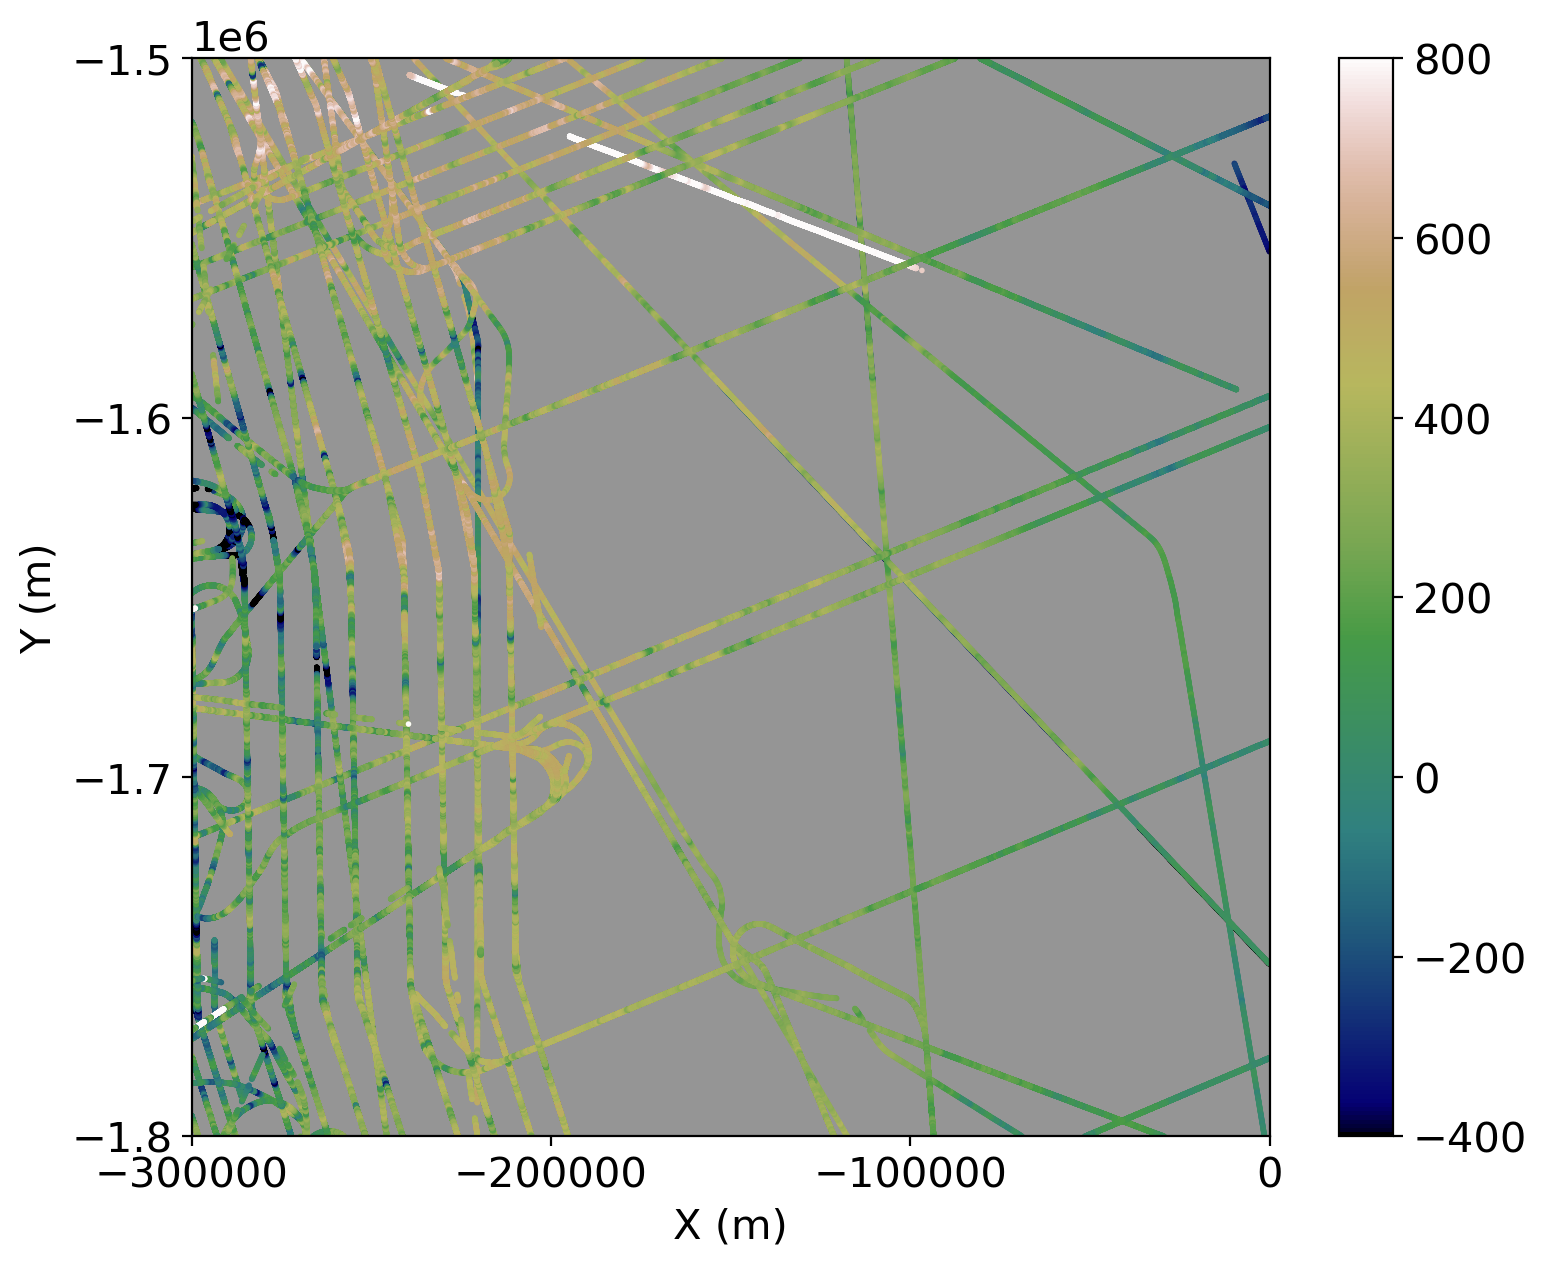

In [10]:
fig, ax = plt.subplots(figsize = (9,7)) 
plt.locator_params(nbins=4)
plt.imshow(np.zeros((1,1)),extent = [-300000,0,-1.8e6, -1.5e6],cmap = 'Greys',vmin = -1, vmax = 1)
sc = plt.scatter(x = radar[:,0],y = radar[:,1], c = radar[:,2], s = 1,  cmap='gist_earth',vmin = -400,vmax = 800)
plt.colorbar(sc)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

## Resolution and data grid

In [12]:
origin = np.array([-300000,-1800000])
resolution = np.array([2000,2000])
num_of_grids = np.array(300000/resolution+1,dtype = 'int64')

resize_data = np.copy(radar)
resize_data[:,:2] = np.round((resize_data[:,:2]-origin)/resolution)

data = np.zeros((num_of_grids[0],num_of_grids[1]))
data[:] = np.nan

for i in range(radar.shape[0]):
    data[int(resize_data[i,1]),int(resize_data[i,0])] = radar[i,2]

In [13]:
num_x = num_of_grids[0]
num_y = num_of_grids[1]

x = np.arange(num_x)
y = np.arange(num_y)

# Trend estimation, RBF

- Impacted by outliers? If we have a large smooth factor, we can smooth out the outliers. But the outliers still contribute to the trend

- It will be extremely slow if we have very fine grids.

In [14]:
data_DF = np.array([np.where(~np.isnan(data))[1],np.where(~np.isnan(data))[0], data[~np.isnan(data)]])
data_DF = pd.DataFrame(data_DF.T, columns = ['X','Y','data'])

In [15]:
trend_rbf = trend_estimation_rbf(data_DF, x, y, smooth = 50)

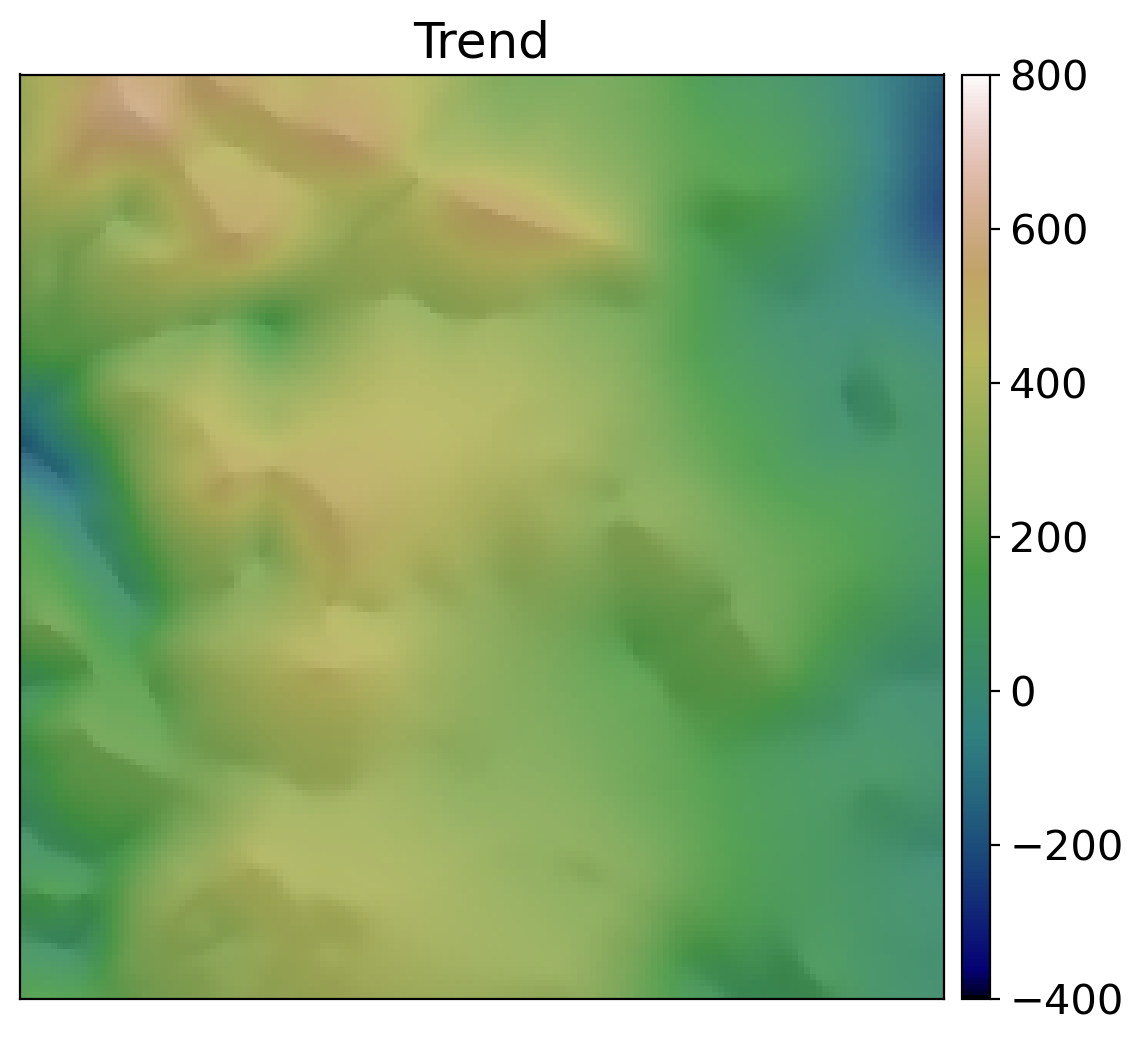

In [16]:
hillshade = es.hillshade(trend_rbf[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_rbf[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Trend",
    vmin = -400, vmax = 800,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Outlier detection
 If we plot a quantile-quantile plot for a residual vs Guassian distribution the outlier will deviate from that straight line.  

In [17]:
data_idx = ~np.isnan(data)
norm_quantile,residual,deviation,threshold,outlier_matrix = residual_quantile(trend_rbf, 
                                                                              data, 
                                                                              data_idx,outlier_proportion = 0.04)

Text(0.5, 1.0, 'QQ plot of residual')

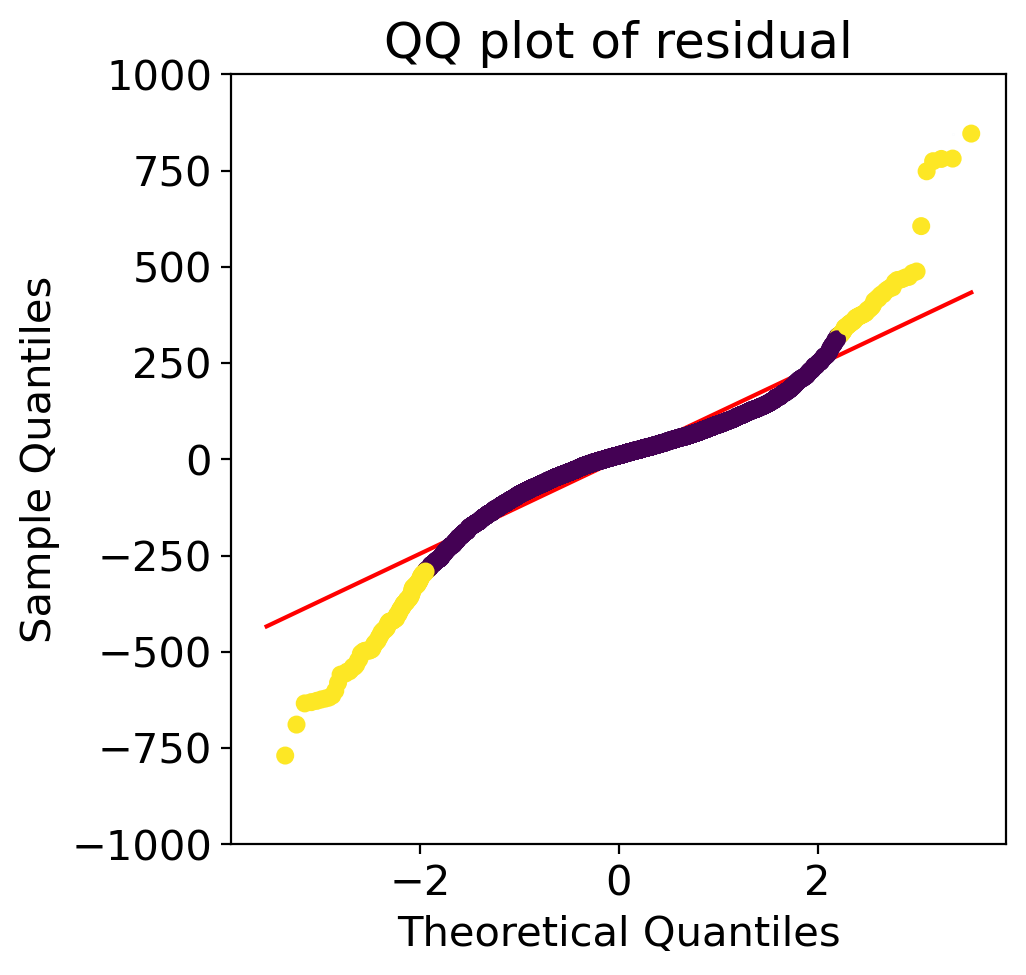

In [18]:
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (5, 5) 
fig = sm.qqplot(residual, line="r",marker = ".",ms = 0.01)
plt.scatter(norm_quantile,residual,c= (deviation>threshold)*1,zorder = 1000,s = 30)
plt.ylim(-1000,1000)
plt.xlim(-3.9,3.9)
plt.title('QQ plot of residual')

In [19]:
data[outlier_matrix==1] = np.nan

Text(0, 0.5, 'Y (m)')

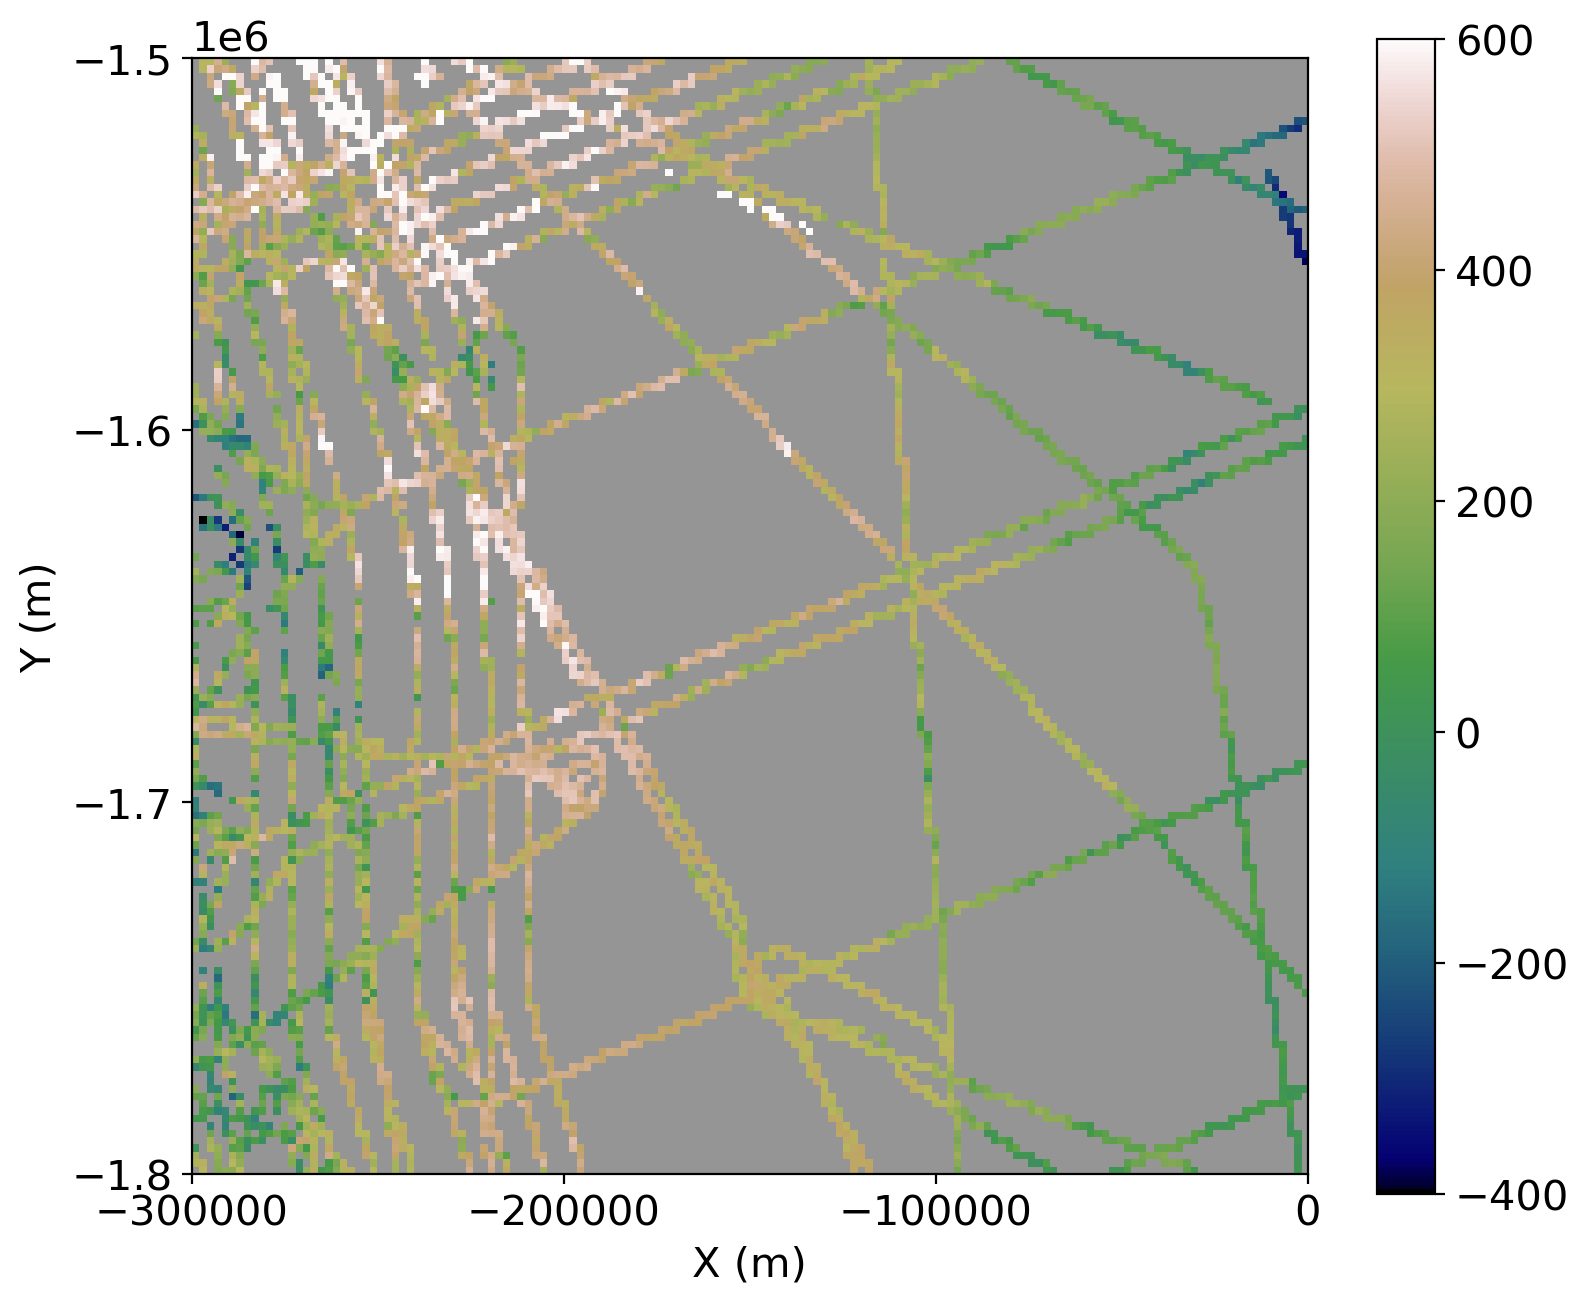

In [20]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.locator_params(nbins=4)
plt.imshow(np.zeros((1,1)),extent = [-300000,0,-1.8e6, -1.5e6],cmap = 'Greys',vmin = -1, vmax = 1)
plt.imshow(data,origin = 'lower',vmin = -400,vmax = 600,extent = [-300000,0,-1.8e6, -1.5e6], cmap = 'gist_earth')
plt.colorbar()
#plt.axis('off')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

In [21]:
data_DF = np.array([np.where(~np.isnan(data))[1],np.where(~np.isnan(data))[0], data[~np.isnan(data)]])
data_DF = pd.DataFrame(data_DF.T, columns = ['X','Y','data'])
trend_rbf = trend_estimation_rbf(data_DF, x, y, smooth = 500)

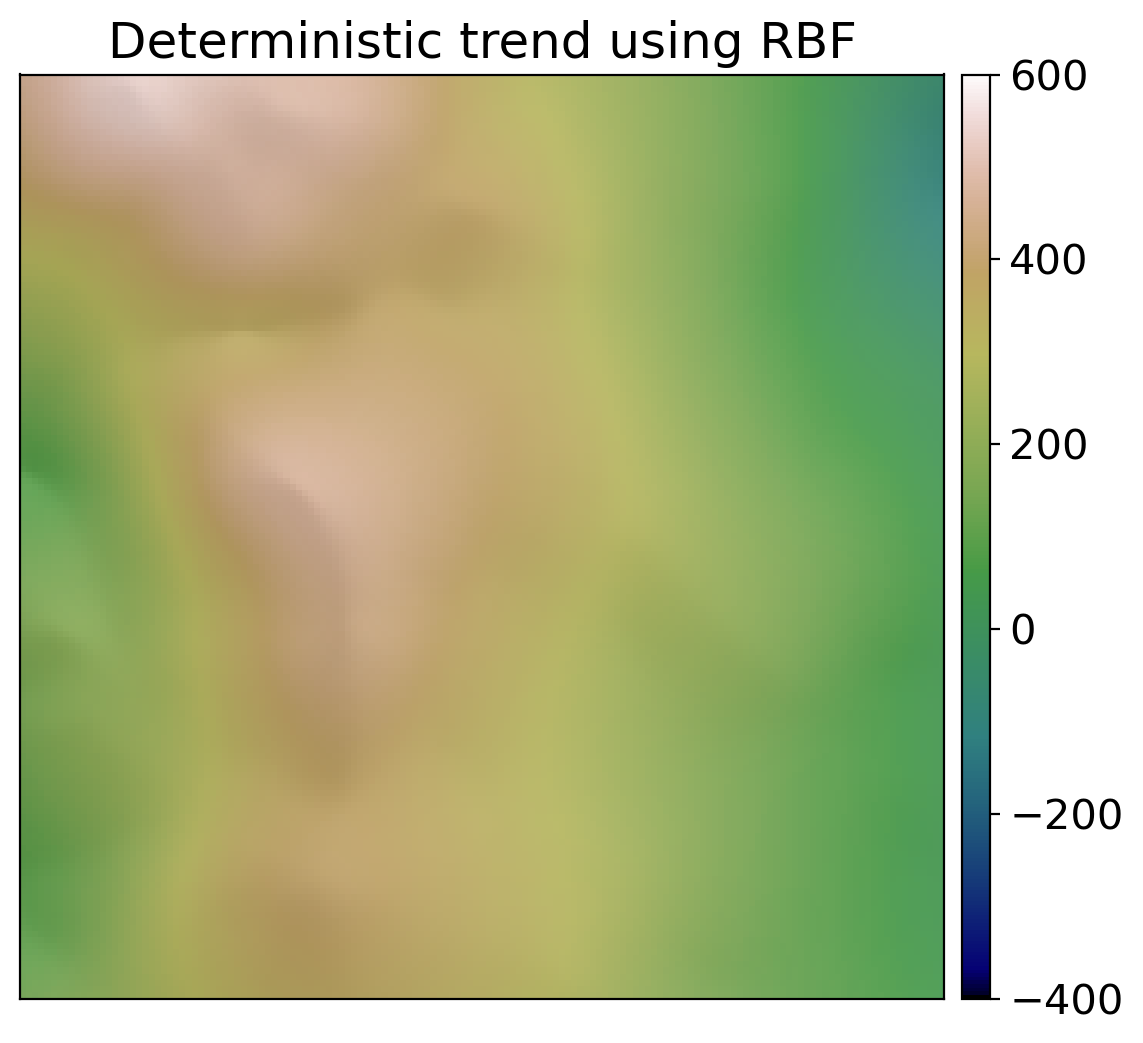

In [22]:
hillshade = es.hillshade(trend_rbf[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_rbf[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Deterministic trend using RBF",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

In [23]:
# np.save('../data/Greenland_DigitalElevationModel/trend_rbf.npy',trend_rbf)

# Trend estimation, McMC

In [24]:
# Initial trend, set as the mean 
trend_init = np.zeros(data.shape)
trend_init[:] = np.nanmean(data)

loss_prev = loss_function_hard_data(trend_init,data,data_idx)

In [25]:
[trend_cache, loss_cache] = non_stationary_2D(trend_init, data, loss_prev, x,y, range_min = [75,75],range_max = [75,75],
                                              high_step = 20,  
                                              sigma = 500, iter_num = 4000)

  0%|          | 1/4000 [00:00<15:42,  4.24it/s]

iter0: [33111.21145511]


  3%|▎         | 101/4000 [00:22<14:12,  4.58it/s]

iter100: [19117.17042807]


  5%|▌         | 201/4000 [00:44<14:09,  4.47it/s]

iter200: [14506.04173518]


  8%|▊         | 301/4000 [01:06<14:00,  4.40it/s]

iter300: [14349.47423361]


 10%|█         | 401/4000 [01:28<12:55,  4.64it/s]

iter400: [13763.30609525]


 13%|█▎        | 501/4000 [01:49<12:35,  4.63it/s]

iter500: [13546.18279176]


 15%|█▌        | 601/4000 [02:11<12:11,  4.65it/s]

iter600: [13154.98921849]


 18%|█▊        | 701/4000 [02:33<11:57,  4.60it/s]

iter700: [13127.56527587]


 20%|██        | 801/4000 [02:55<11:29,  4.64it/s]

iter800: [13011.62464354]


 23%|██▎       | 901/4000 [03:17<11:07,  4.65it/s]

iter900: [13107.1196643]


 25%|██▌       | 1001/4000 [03:39<10:45,  4.65it/s]

iter1000: [13024.27646893]


 28%|██▊       | 1101/4000 [04:00<10:28,  4.61it/s]

iter1100: [12966.71500747]


 30%|███       | 1201/4000 [04:22<10:02,  4.65it/s]

iter1200: [13078.12067215]


 33%|███▎      | 1301/4000 [04:43<10:01,  4.49it/s]

iter1300: [13089.55334414]


 35%|███▌      | 1401/4000 [05:05<09:31,  4.55it/s]

iter1400: [12963.42122111]


 38%|███▊      | 1501/4000 [05:27<09:15,  4.50it/s]

iter1500: [12970.76950711]


 40%|████      | 1601/4000 [05:49<08:35,  4.65it/s]

iter1600: [12981.0375749]


 43%|████▎     | 1701/4000 [06:11<08:44,  4.38it/s]

iter1700: [12934.71708705]


 45%|████▌     | 1801/4000 [06:33<08:28,  4.32it/s]

iter1800: [13004.14666535]


 48%|████▊     | 1901/4000 [06:55<07:32,  4.63it/s]

iter1900: [13056.08112833]


 50%|█████     | 2001/4000 [07:17<07:14,  4.61it/s]

iter2000: [13017.79190379]


 53%|█████▎    | 2101/4000 [07:40<07:03,  4.48it/s]

iter2100: [13068.86839516]


 55%|█████▌    | 2201/4000 [08:03<06:26,  4.66it/s]

iter2200: [13101.61972328]


 58%|█████▊    | 2301/4000 [08:24<06:15,  4.52it/s]

iter2300: [13030.49398392]


 60%|██████    | 2401/4000 [08:47<06:10,  4.32it/s]

iter2400: [12918.20183819]


 63%|██████▎   | 2501/4000 [09:09<05:32,  4.50it/s]

iter2500: [12951.42046495]


 65%|██████▌   | 2601/4000 [09:31<05:02,  4.62it/s]

iter2600: [12956.59280885]


 68%|██████▊   | 2701/4000 [09:53<04:59,  4.34it/s]

iter2700: [13012.07330627]


 70%|███████   | 2801/4000 [10:15<04:24,  4.53it/s]

iter2800: [12931.32328142]


 73%|███████▎  | 2901/4000 [10:37<03:56,  4.64it/s]

iter2900: [13048.65692219]


 75%|███████▌  | 3001/4000 [10:59<03:33,  4.68it/s]

iter3000: [13026.49400131]


 78%|███████▊  | 3101/4000 [11:21<03:18,  4.53it/s]

iter3100: [12941.25116096]


 80%|████████  | 3201/4000 [11:44<03:16,  4.07it/s]

iter3200: [12895.74121109]


 83%|████████▎ | 3301/4000 [12:06<02:51,  4.08it/s]

iter3300: [12926.67067357]


 85%|████████▌ | 3401/4000 [12:28<02:08,  4.64it/s]

iter3400: [12859.49514805]


 88%|████████▊ | 3501/4000 [12:50<01:48,  4.61it/s]

iter3500: [12865.13825648]


 90%|█████████ | 3601/4000 [13:13<01:27,  4.55it/s]

iter3600: [12869.42384871]


 93%|█████████▎| 3701/4000 [13:35<01:05,  4.58it/s]

iter3700: [12950.91471969]


 95%|█████████▌| 3801/4000 [13:57<00:44,  4.51it/s]

iter3800: [13039.66501916]


 98%|█████████▊| 3901/4000 [14:19<00:21,  4.65it/s]

iter3900: [12993.04385199]


100%|██████████| 4000/4000 [14:41<00:00,  4.54it/s]


## Trace plot

Text(0, 0.5, 'Loss')

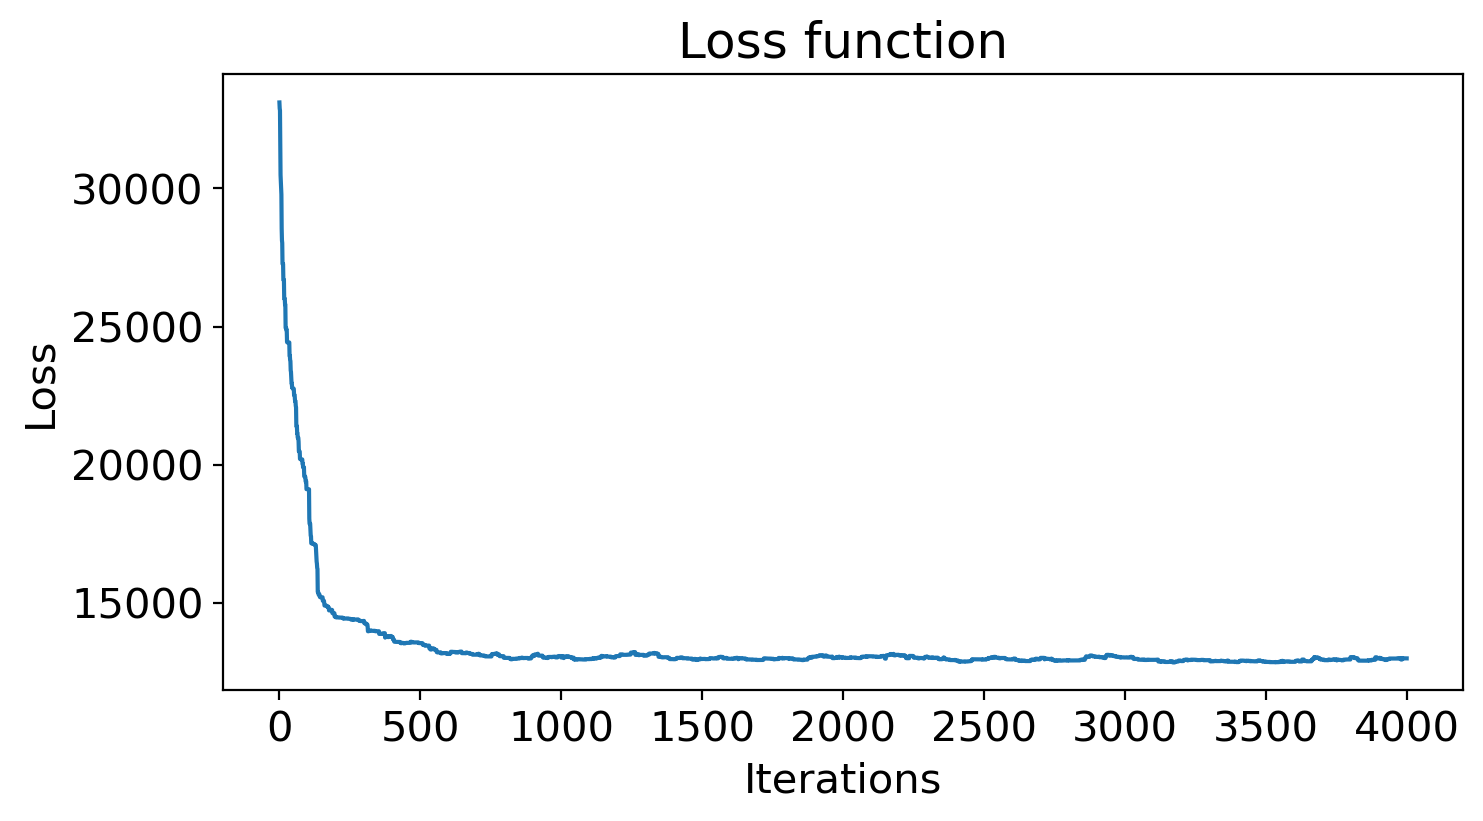

In [26]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(loss_cache[:])
plt.title('Loss function')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [115]:
# cut_off = 20000
# cut_off = 4000
cut_off = 3500


In [84]:
test = np.array([[1, 2], [3,4]])
x = 1
print(test.shape)
print(np.mean(test, axis=0))
print(np.mean(test[x:,:], axis=0))

(2, 2)
[2. 3.]
[3. 4.]


(4000, 151, 151)


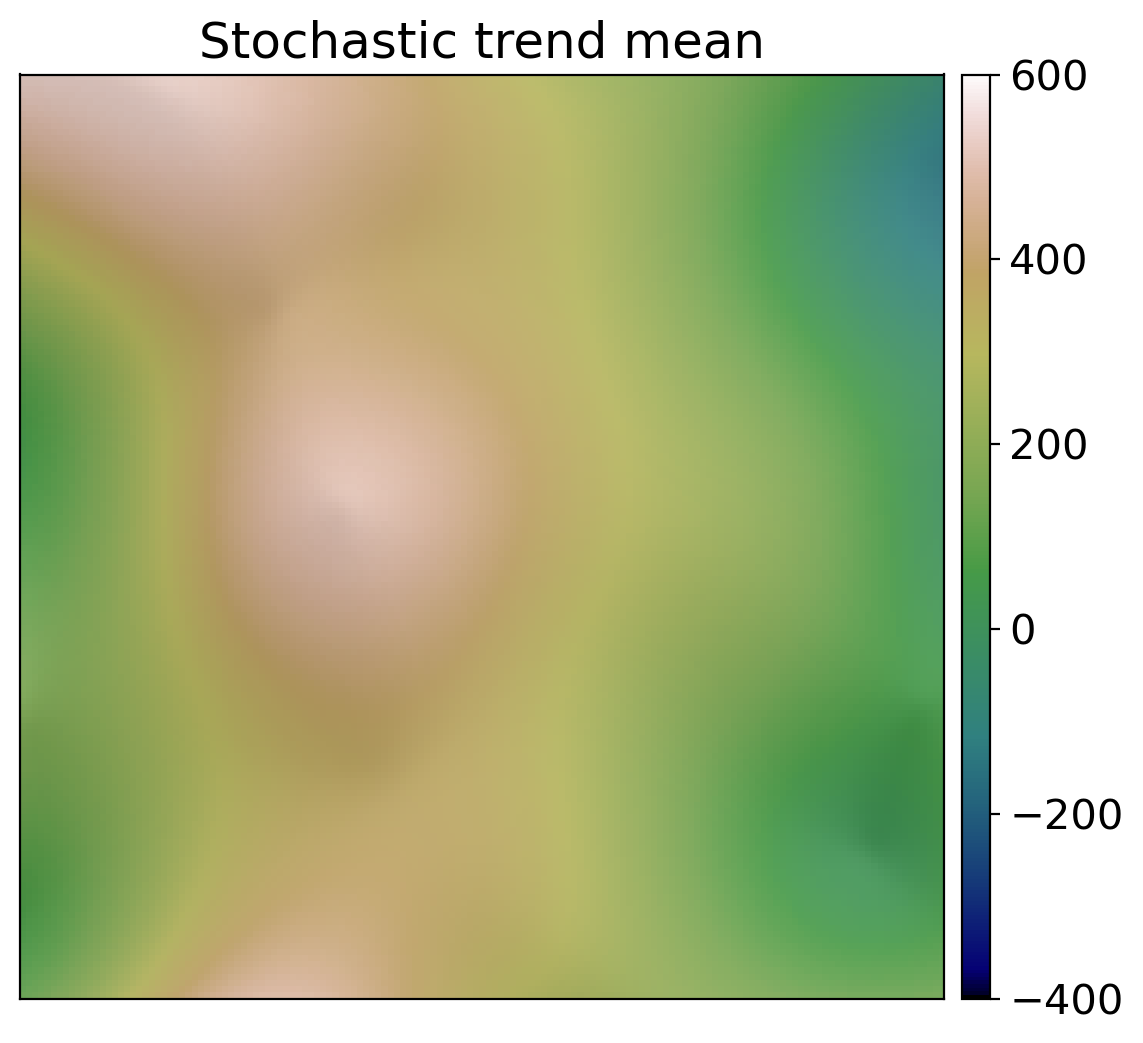

In [116]:
trendmean = np.mean(trend_cache[cut_off:,:,:],axis = 0)

print(trend_cache.shape)

hillshade = es.hillshade(trendmean[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trendmean[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Stochastic trend mean",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

(-0.5, 150.5, -0.5, 150.5)

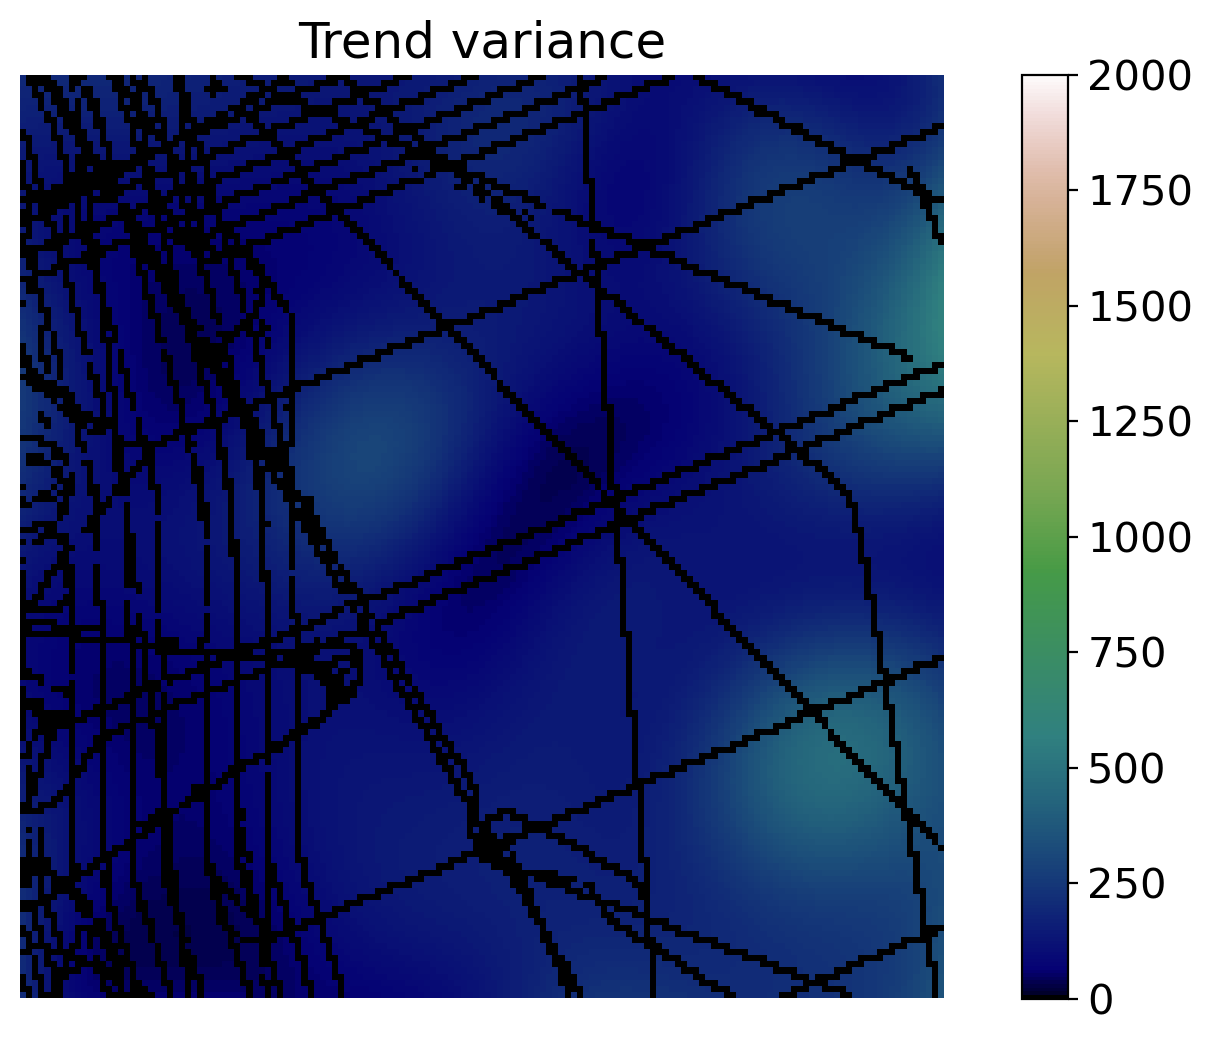

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))
trendvar = np.var(trend_cache[cut_off:,:,:],axis = 0)

plt.imshow(trendvar,origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 2000)
plt.colorbar()
plt.imshow(data,origin = 'lower',vmin = 0,vmax = 0, cmap = 'gist_earth')

plt.title('Trend variance')

plt.axis('off')

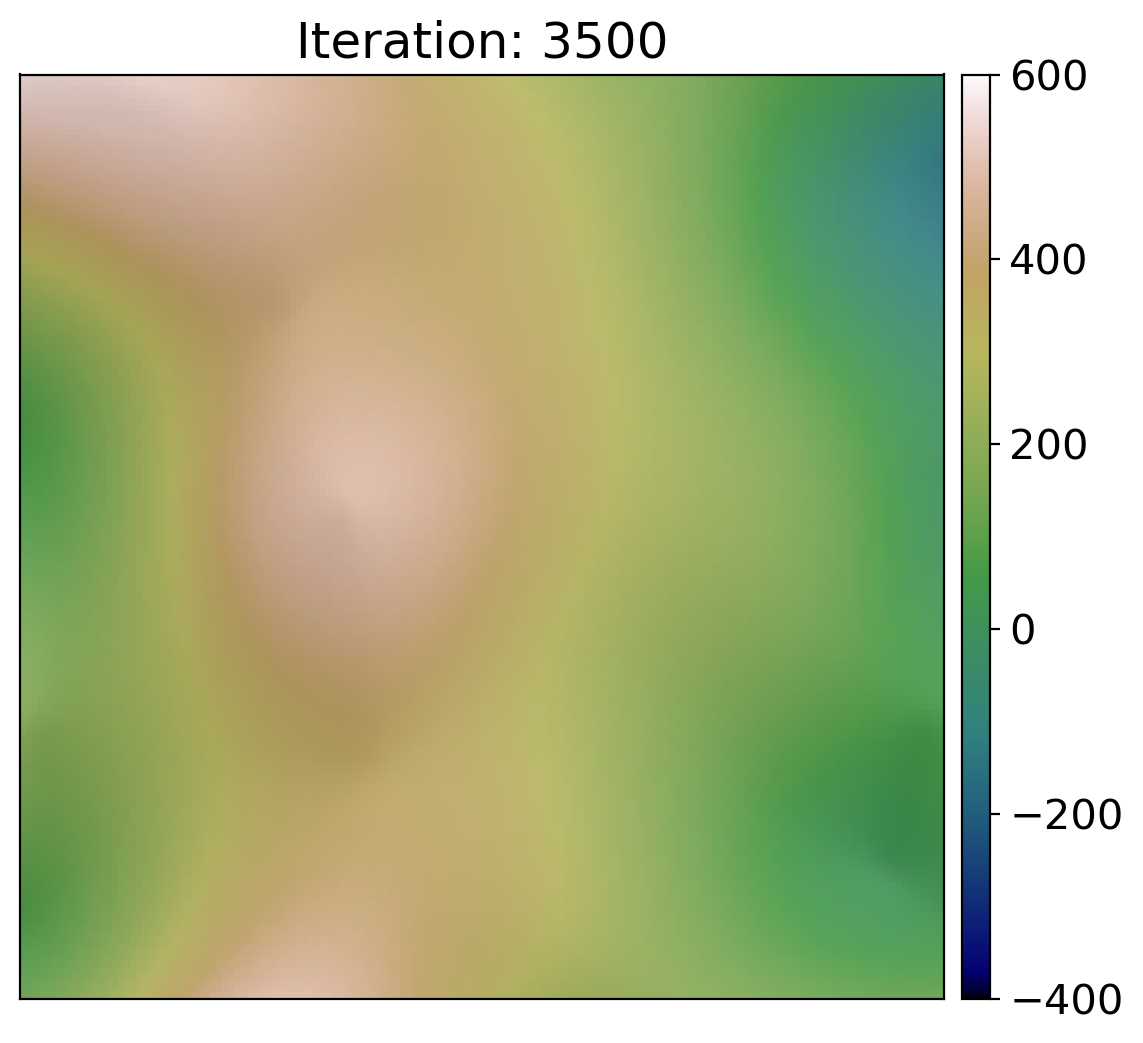

In [119]:
# not sure why trend # is not matching up
# idx = 40000
idx = 3500
hillshade = es.hillshade(trend_cache[idx,::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    trend_cache[idx,::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="Iteration: "+str(idx),
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

## Convergence test

In [120]:
def Gelmen_Rubin_Diagnostic(chain1, chain2, burn_in = 10000,length = 20000):
    
    n = chain1[burn_in:burn_in+length].shape[0]
    
    W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2)/2
    mean1 = chain1[burn_in:burn_in+length].mean()
    mean2 = chain2[burn_in:burn_in+length].mean()
    mean = (mean1 + mean2)/2
    B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
    var_theta = (1 - 1/n) * W + 1/n*B
    
    return np.sqrt(var_theta/W)

In [121]:
# iter_num = 50000
iter_num = 4000
trend_cache_mean = np.mean(trend_cache.reshape(iter_num,-1),axis = 1)
trend_cache_std = np.std(trend_cache.reshape(iter_num,-1),axis = 1)

print(trend_cache_mean)
print(trend_cache_std)

[301.45917357 297.55103927 298.55938931 ... 265.9132016  265.9132016
 265.9132016 ]
[ 11.97811532  16.47767628  17.10518454 ... 147.32336545 147.32336545
 147.32336545]


In [126]:
Gelmen_Rubin_Diagnostic(trend_cache_mean[200:350],
                        trend_cache_mean[350:399],burn_in = 0,length = 150)

1.312865781322622

In [ ]:
Gelmen_Rubin_Diagnostic(trend_cache_std[20000:35000],
                        trend_cache_std[35000:50000],burn_in = 0,length = 15000)

Text(0.5, 1.0, 'Trend')

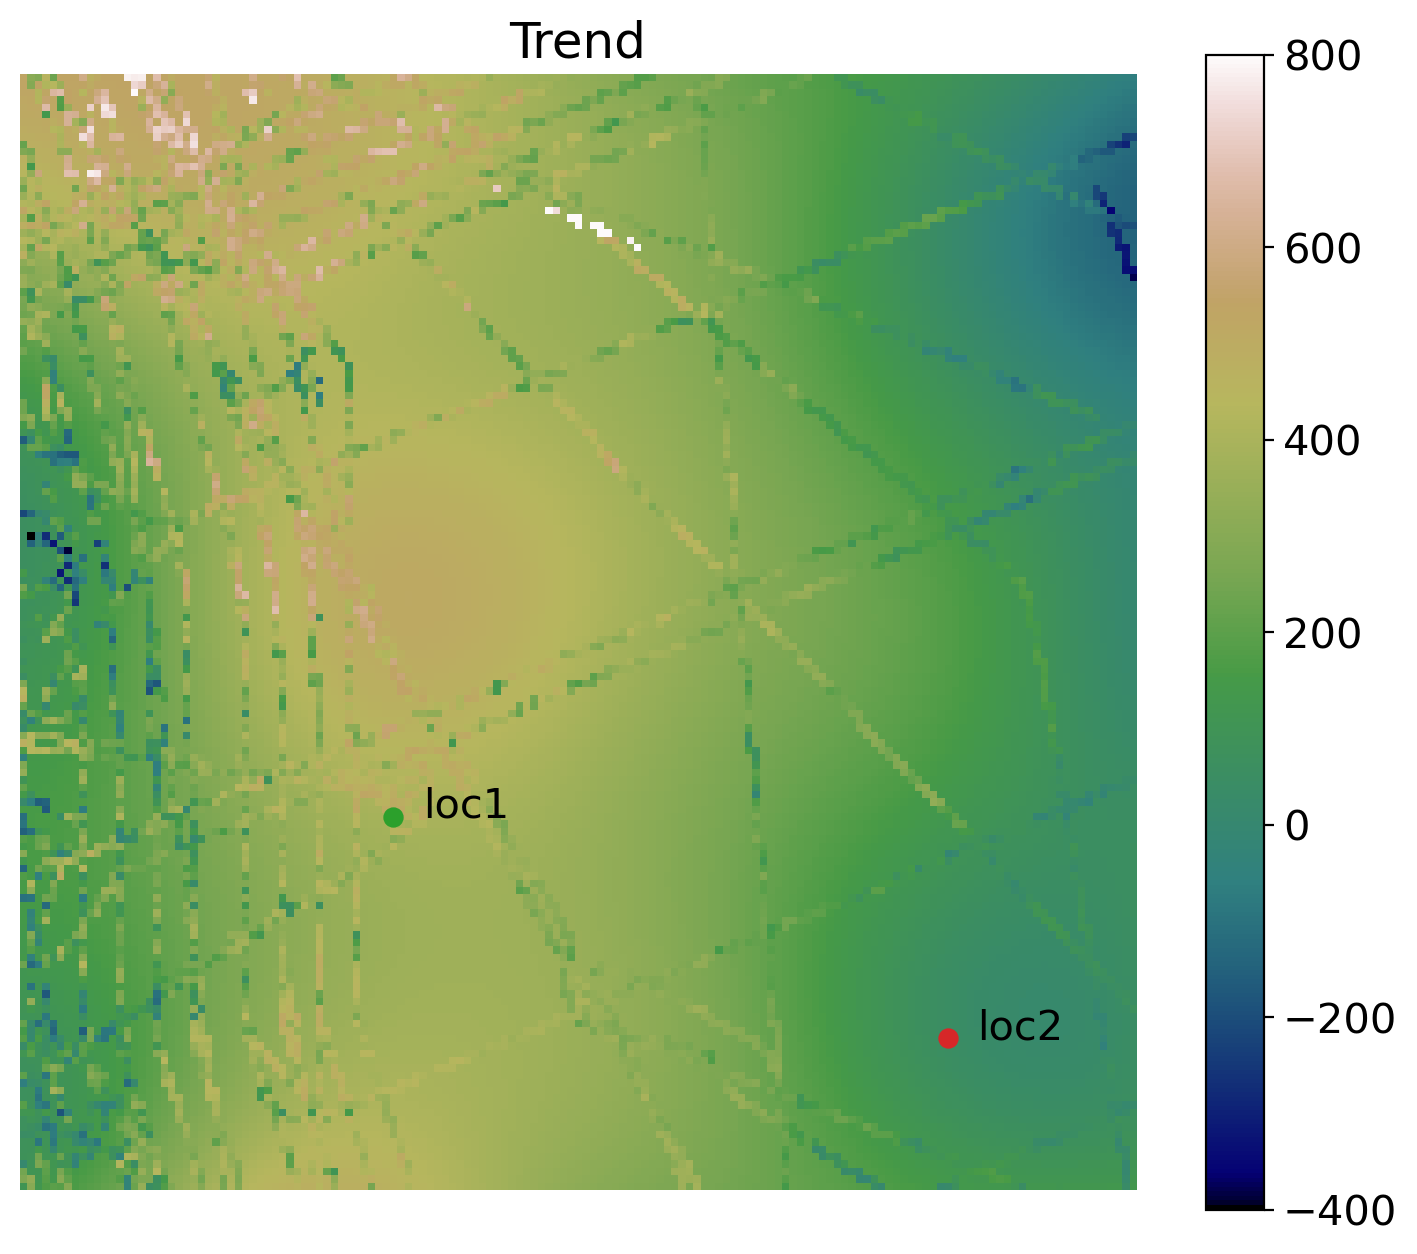

In [127]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.imshow(trendmean,origin = 'lower',vmin = -400,vmax = 800,cmap = 'gist_earth',alpha = 1)
plt.imshow(data,origin = 'lower',vmin = -400,vmax = 800,cmap = 'gist_earth')
plt.colorbar()
plt.scatter(50,50,c = 'C2',s = 40)
plt.text(50+4,50,'loc1')
plt.scatter(125,20,c = 'C3',s = 40)
plt.text(125+4,20,'loc2')
plt.axis('off')
plt.title('Trend')

Text(0.5, 1.0, 'Trace plot')

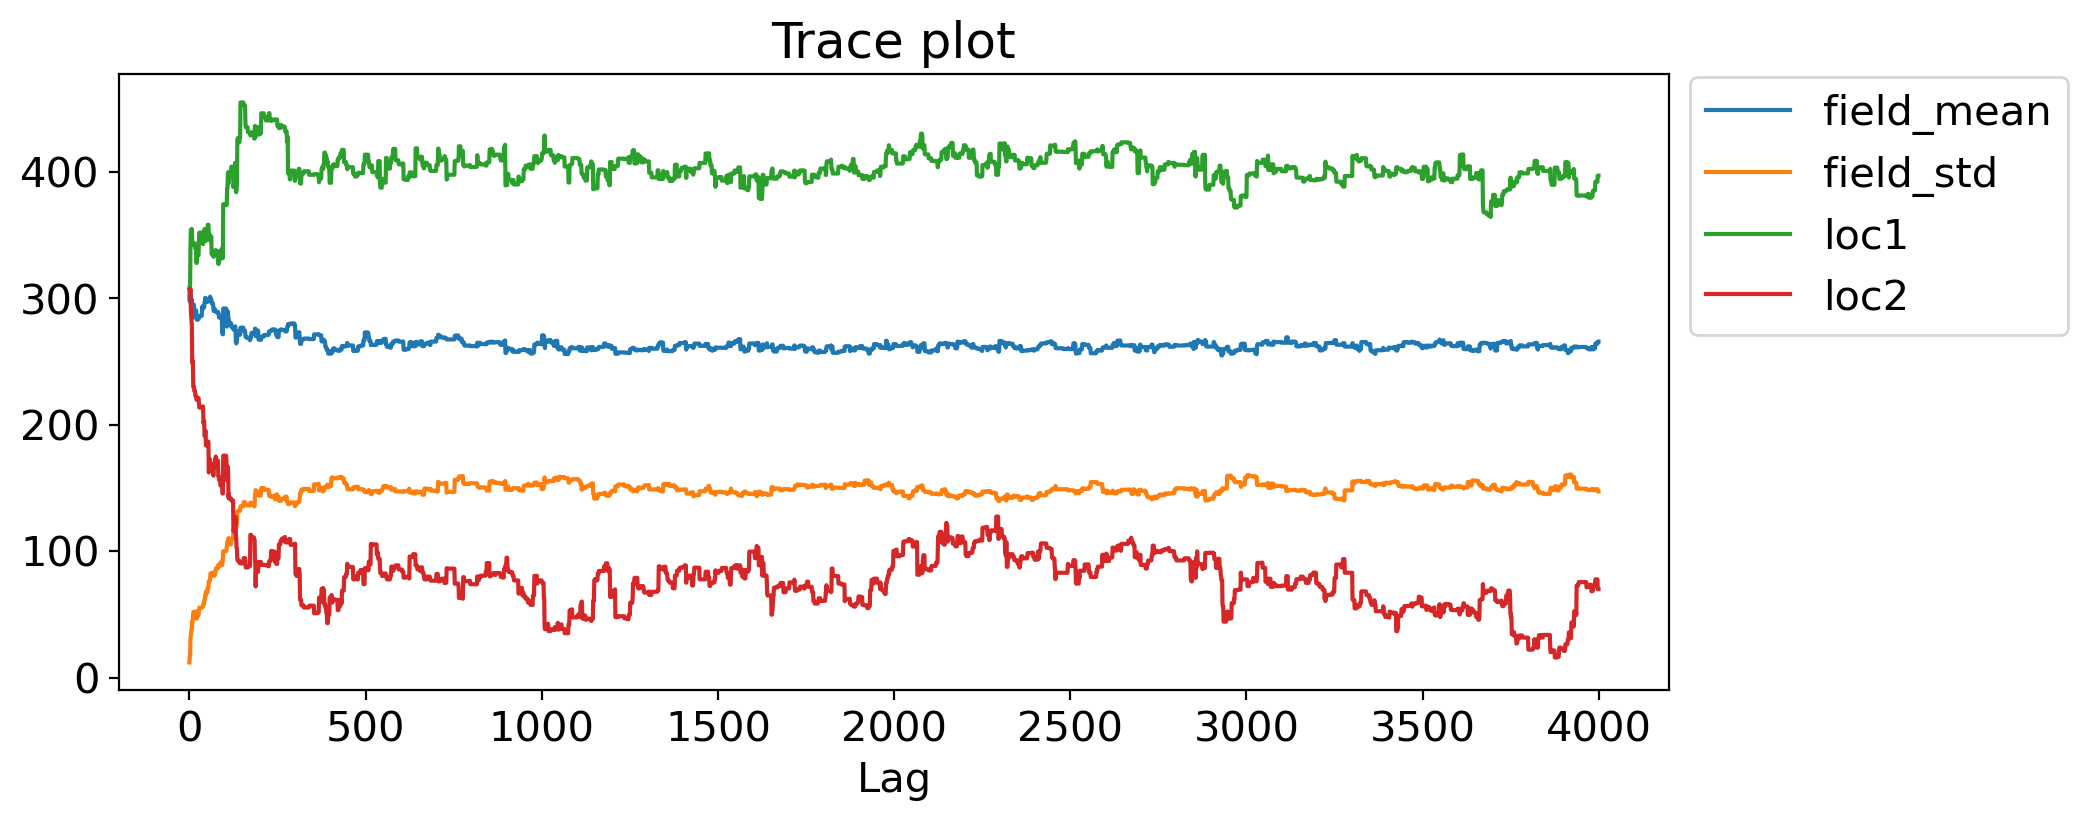

In [128]:
plt.rcParams["figure.figsize"] = (10, 4) 
plt.plot(trend_cache_mean[:],label = 'field_mean')
plt.plot(trend_cache_std[:],label = 'field_std')
plt.plot(trend_cache[:,50,50],label = 'loc1')
plt.plot(trend_cache[:,20,125],label = 'loc2')

plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('Lag')
plt.title('Trace plot')

## ACF

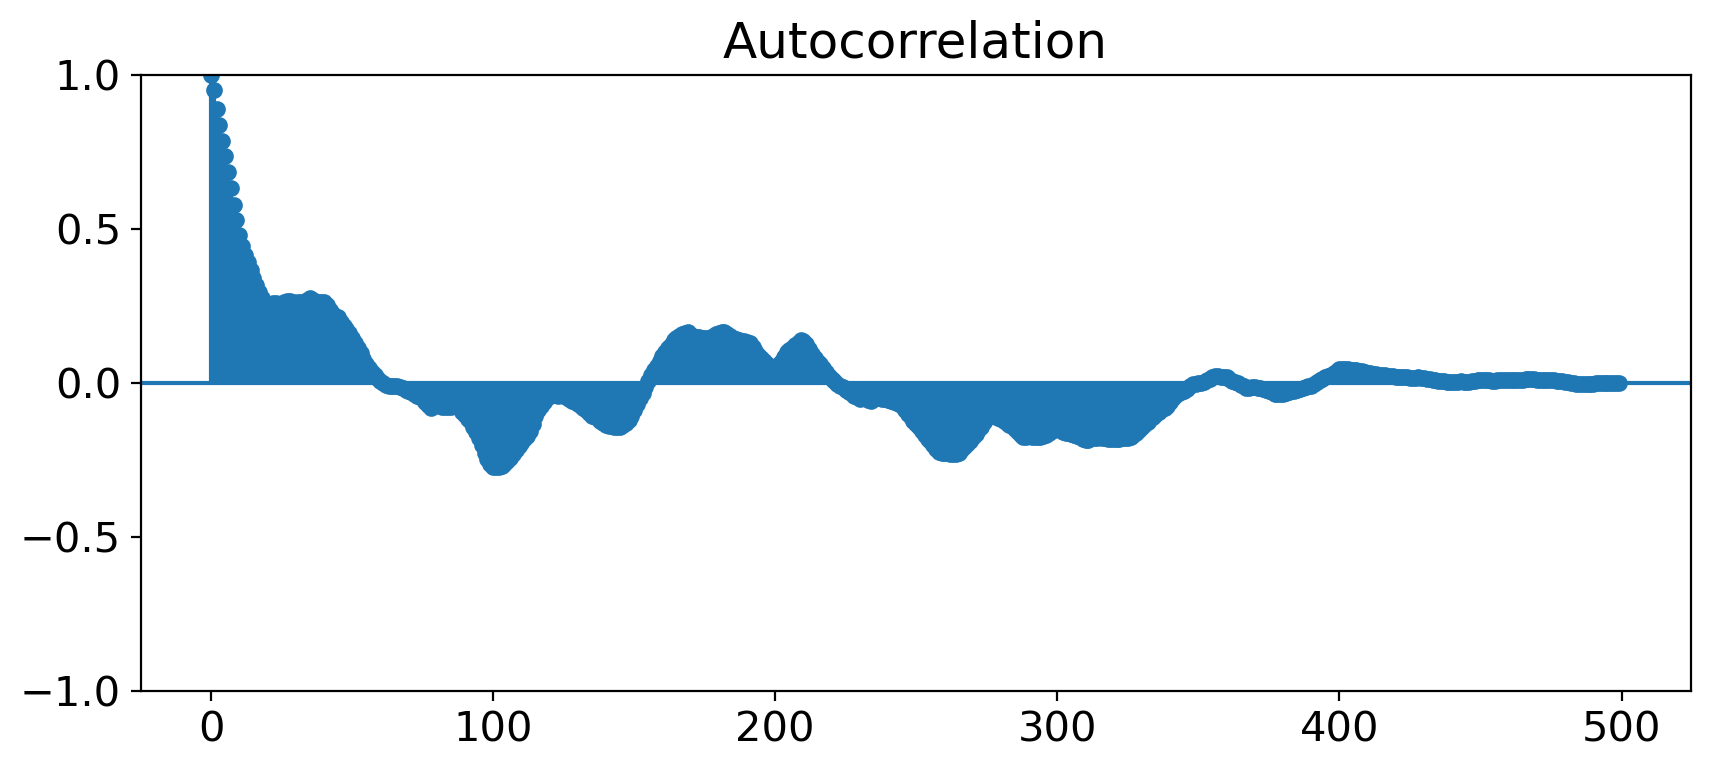

In [129]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(trend_cache[cut_off:,20,20],alpha = 1,
               lags = np.arange(trend_cache[cut_off:,:,:].shape[0]),
               bartlett_confint = False)

In [141]:
from statsmodels.tsa.stattools import acf
print(trend_cache[cut_off,:,:].shape)

print(x)
print(y)
acf_values = np.zeros((500,(x),(y)))
for i in tqdm(range((x))):
    for j in range((y)):
        acf_values[:,i,j] = acf(trend_cache[cut_off:,i,j],nlags = 10000)

(151, 151)
151
151


100%|██████████| 151/151 [00:01<00:00, 144.94it/s]


Text(0.5, 1.0, 'Mean autocorrelation of all grids')

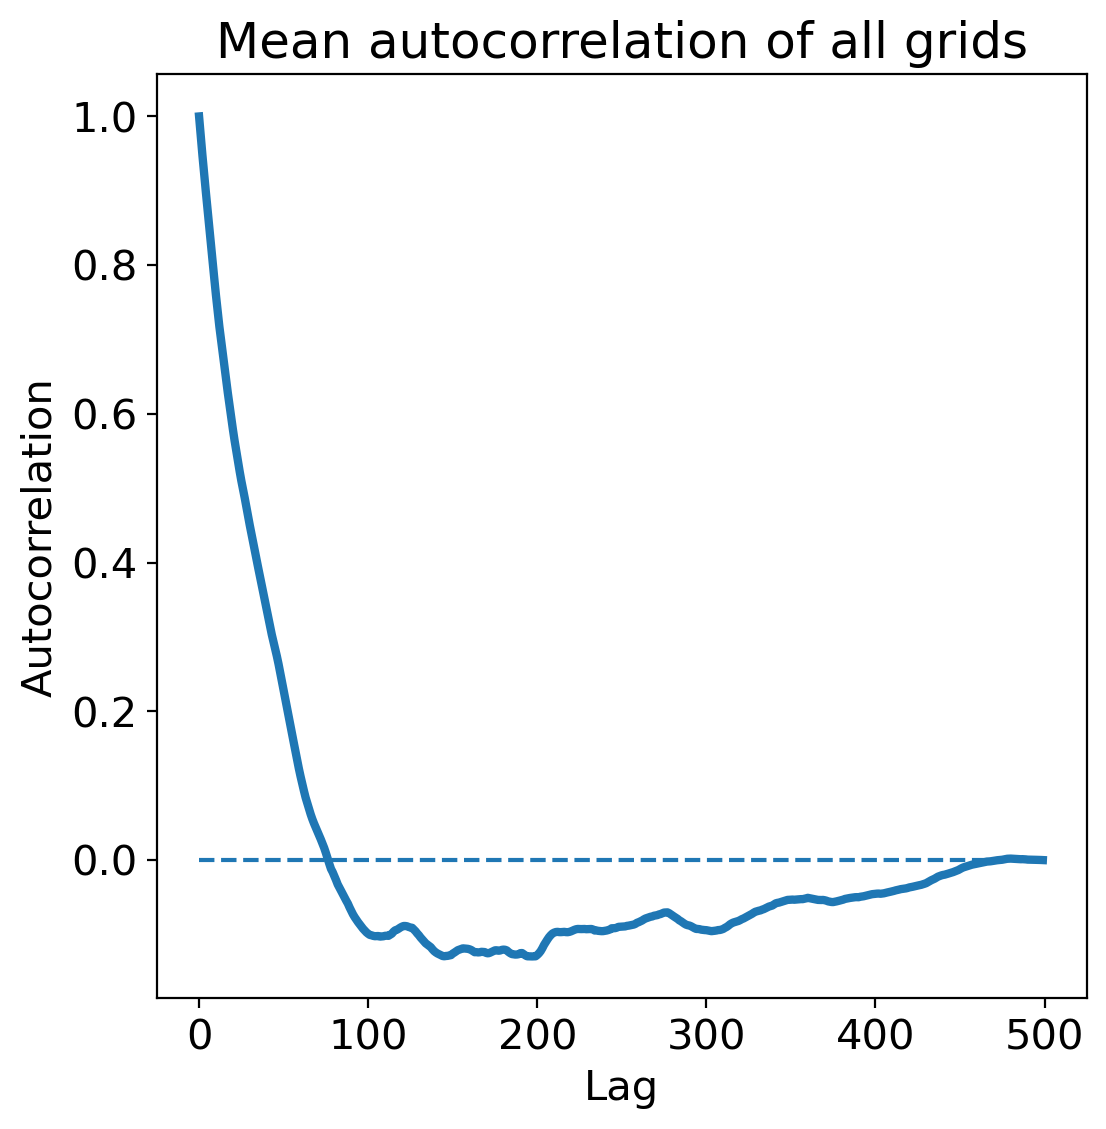

In [144]:
plt.rcParams["figure.figsize"] = (6, 6) 
plt.plot(np.mean(acf_values.reshape(500,-1),axis =1),linewidth = 3)
plt.hlines(xmin = 0, xmax = 500,y = 0,linestyle = '--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Mean autocorrelation of all grids')

## Acceptance rate

In [146]:
iter_num = 3999
start = 0
1-np.sum(loss_cache[(start+1):,0]-loss_cache[start:-1,0]==0)/(iter_num-start-1)

0.23136568284142067

In [147]:
### acceptance rate curve
acc_rate = np.zeros(iter_num)
acc_rate[:] = np.nan

for iteration in np.arange(1,iter_num):
    acc_rate[iteration] = 1-np.sum((loss_cache[1:(iteration+1)]-loss_cache[0:iteration])==0)/iteration

Text(0.5, 1.0, 'Acceptance rate')

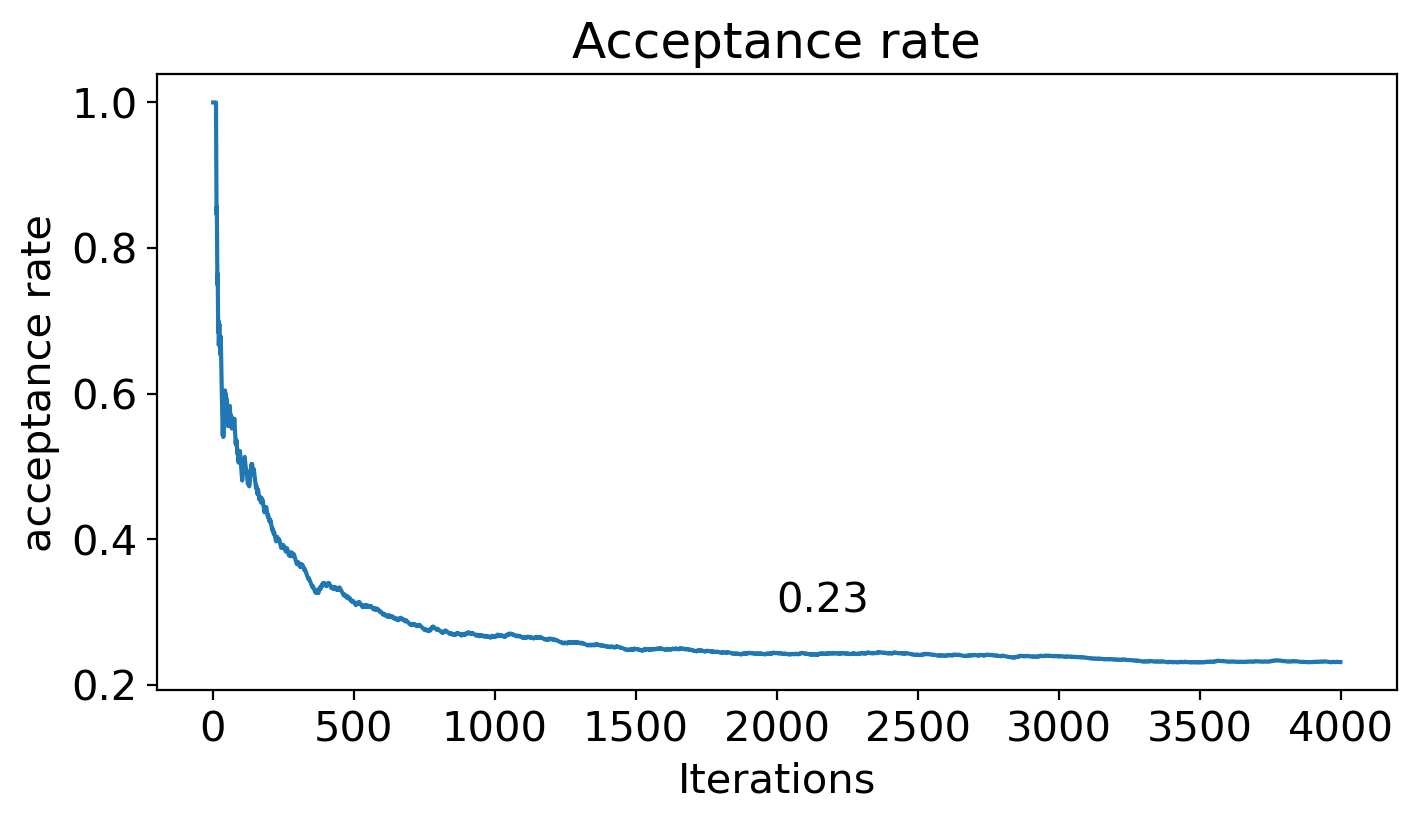

In [148]:
plt.rcParams["figure.figsize"] = (8, 4) 
plt.plot(np.arange(1,iter_num),acc_rate[1:])
plt.text(iter_num-2000, 0.2+0.1, np.round(acc_rate[-1],2))
plt.ylabel('acceptance rate')
plt.xlabel('Iterations')
plt.title('Acceptance rate')

## Multiple chains

In [149]:
import multiprocessing
high_step = 20 
sigma = 500
iter_num = 50000
velocity_path = 'Greenland_velocity/Greenland_'

input_list = [[trend_init, data, loss_prev, x, y, [75,75], [75,75], high_step, sigma, iter_num, 0],
              [trend_init, data, loss_prev, x, y, [50,50], [50,50], high_step, sigma, iter_num, 1],
              [trend_init, data, loss_prev, x, y, [30,30], [30,30], high_step, sigma, iter_num, 2],
              [trend_init, data, loss_prev, x, y, [20,20], [20,20], high_step, sigma, iter_num, 3],
              [trend_init, data, loss_prev, x, y, [10,10], [10,10], high_step, sigma, iter_num, 4],
              [trend_init, data, loss_prev, x, y, [50,50], [75,75], high_step, sigma, iter_num, 5]]

# Trend estimation, McMC
# 6 runs
# the start indicate where we retrieve our velocity
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes = 6)
    result = pool.map(mp_non_stationary_2D,input_list)
    pool.close()

  0%|          | 67/50000 [00:00<02:30, 331.93it/s]

iter0: [33273.2986512]
iter0: [33273.2986512]
iter0: [33273.2986512]
iter0: [33288.53032987]
iter0: [33273.2986512]
iter0: [33273.49289031]


  0%|          | 119/50000 [00:00<02:39, 313.33it/s]

iter100: [33273.52699179]
iter100: [33273.29944962]
iter100: [33276.06431359]
iter100: [33276.7502734]
iter100: [33277.69054408]
iter100: [33277.1177817]


  0%|          | 184/50000 [00:00<02:44, 303.24it/s]

iter200: [33277.96799605]
iter200: [33276.2960646]
iter200: [33275.36969218]
iter200: [33276.23259269]
iter200: [33281.64366916]
iter200: [33275.77442367]


  1%|          | 350/50000 [00:01<02:22, 348.74it/s]

iter300: [33273.69574021]
iter300: [33273.53931034]
iter300: [33277.90847251]
iter300: [33278.05934563]
iter300: [33273.31790759]
iter300: [33274.04871041]


  1%|          | 393/50000 [00:01<02:34, 321.91it/s]

iter400: [33274.53254294]
iter400: [33276.4605277]
iter400: [33274.12872531]
iter400: [33273.38244697]
iter400: [33274.37258956]
iter400: [33279.95637251]


  1%|          | 473/50000 [00:01<02:39, 309.77it/s]

iter500: [33273.34089687]
iter500: [33278.66157218]
iter500: [33275.47114838]
iter500: [33275.56318678]
iter500: [33275.04479199]
iter500: [33275.8546297]


  1%|          | 613/50000 [00:01<02:27, 334.77it/s]

iter600: [33275.35554691]
iter600: [33286.74152591]
iter600: [33273.6570321]
iter600: [33276.08960822]
iter600: [33273.41698343]
iter600: [33274.59298837]


  1%|▏         | 683/50000 [00:02<02:31, 325.86it/s]

iter700: [33273.57933393]
iter700: [33278.75321164]
iter700: [33279.8033479]
iter700: [33276.53223405]
iter700: [33275.87167485]
iter700: [33274.3687474]


  2%|▏         | 832/50000 [00:02<02:21, 347.42it/s]

iter800: [33275.92064484]
iter800: [33273.60155335]
iter800: [33274.59922507]
iter800: [33273.74854025]
iter800: [33273.5164943]
iter800: [33273.98157257]


  2%|▏         | 906/50000 [00:02<02:24, 339.46it/s]

iter900: [33281.92748551]
iter900: [33282.8199069]
iter900: [33274.219856]
iter900: [33280.01297666]
iter900: [33274.36360477]
iter900: [33273.78154415]


  2%|▏         | 1050/50000 [00:03<02:20, 349.64it/s]

iter1000: [33274.61062587]
iter1000: [33273.30019505]
iter1000: [33276.53964006]
iter1000: [33274.10111684]
iter1000: [33287.37502881]
iter1000: [33273.30959286]


  2%|▏         | 1123/50000 [00:03<02:35, 314.71it/s]

iter1100: [33276.30601351]
iter1100: [33273.40138047]
iter1100: [33278.37557995]
iter1100: [33273.35734155]
iter1100: [33273.41683625]
iter1100: [33273.89102519]


  2%|▏         | 1188/50000 [00:03<02:39, 305.25it/s]

iter1200: [33275.00123954]
iter1200: [33273.38558649]
iter1200: [33278.90079337]
iter1200: [33273.66833955]
iter1200: [33273.32058685]


  2%|▏         | 1215/50000 [00:03<03:04, 263.80it/s]

iter1200: [33273.332063]
iter1300: [33273.78616412]
iter1300: [33275.96178959]


  3%|▎         | 1330/50000 [00:04<02:30, 323.54it/s]

iter1300: [33275.24240072]
iter1300: [33275.46716114]
iter1300: [33284.37217509]
iter1300: [33273.61706256]


  3%|▎         | 1400/50000 [00:04<02:24, 335.35it/s]

iter1400: [33286.30945986]
iter1400: [33275.09564213]
iter1400: [33273.78766485]
iter1400: [33275.206209]
iter1400: [33275.01863231]
iter1400: [33273.97549867]


  3%|▎         | 1487/50000 [00:04<02:40, 302.23it/s]

iter1500: [33273.31985337]
iter1500: [33273.82066267]
iter1500: [33274.02666327]
iter1500: [33274.87144952]
iter1500: [33275.04146933]
iter1500: [33275.84814326]


  3%|▎         | 1571/50000 [00:04<02:23, 338.48it/s]

iter1600: [33273.50391467]
iter1600: [33275.752367]
iter1600: [33279.20464999]
iter1600: [33287.7224162]
iter1600: [33274.31677072]
iter1600: [33280.46815515]


  3%|▎         | 1693/50000 [00:05<02:28, 324.65it/s]

iter1700: [33273.30345197]
iter1700: [33273.316989]
iter1700: [33273.47363508]
iter1700: [33273.33352024]
iter1700: [33279.23799329]
iter1700: [33274.16129951]


  4%|▎         | 1772/50000 [00:05<02:23, 335.98it/s]

iter1800: [33273.58707521]
iter1800: [33282.72898721]
iter1800: [33286.28336003]
iter1800: [33273.30318044]
iter1800: [33273.96893013]
iter1800: [33287.21925915]


  4%|▎         | 1841/50000 [00:05<02:25, 331.02it/s]

iter1900: [33274.99508222]
iter1900: [33274.97747001]
iter1900: [33275.03239123]
iter1900: [33273.34738863]
iter1900: [33274.0992334]
iter1900: [33280.1190008]


  4%|▍         | 1983/50000 [00:06<02:26, 327.26it/s]

iter2000: [33292.99284925]
iter2000: [33275.29929776]
iter2000: [33274.02227678]
iter2000: [33273.32466252]
iter2000: [33278.5936725]


  4%|▍         | 2040/50000 [00:06<02:30, 318.66it/s]

iter2000: [33273.32108672]
iter2100: [33281.50181947]
iter2100: [33282.21138715]
iter2100: [33279.65757869]
iter2100: [33274.44680318]


  4%|▍         | 2112/50000 [00:06<02:23, 333.45it/s]

iter2100: [33281.33902919]
iter2100: [33280.80357699]
iter2200: [33273.29871248]


  4%|▍         | 2250/50000 [00:06<02:16, 351.05it/s]

iter2200: [33276.91185458]
iter2200: [33273.32461937]
iter2200: [33273.29869135]
iter2200: [33293.75329291]
iter2200: [33279.0089568]
iter2300: [33278.01766133]


  5%|▍         | 2320/50000 [00:07<02:25, 327.72it/s]

iter2300: [33274.42714036]
iter2300: [33275.61862821]
iter2300: [33276.70222081]
iter2300: [33275.05764442]
iter2300: [33274.13277619]
iter2400: [33273.53653035]


  5%|▍         | 2388/50000 [00:07<02:24, 330.30it/s]

iter2400: [33282.59467907]
iter2400: [33275.50631688]
iter2400: [33276.45927052]
iter2400: [33276.26314031]
iter2400: [33280.00275084]
iter2500: [33281.852671]


  5%|▌         | 2543/50000 [00:07<02:07, 371.68it/s]

iter2500: [33280.33163736]
iter2500: [33277.24062969]
iter2500: [33273.54255443]
iter2500: [33274.26934607]
iter2600: [33273.64781185]
iter2500: [33273.35154473]


  5%|▌         | 2621/50000 [00:07<02:06, 373.80it/s]

iter2600: [33285.40825479]
iter2600: [33275.89945374]
iter2600: [33278.57865881]
iter2600: [33277.11183537]
iter2700: [33274.43008222]


  5%|▌         | 2609/50000 [00:08<02:35, 304.97it/s]

iter2600: [33273.7694181]
iter2700: [33277.91929524]
iter2700: [33273.5709046]
iter2700: [33275.79645086]
iter2700: [33273.41529221]


  6%|▌         | 2752/50000 [00:08<02:31, 311.73it/s]

iter2800: [33280.3601856]
iter2700: [33287.3713967]
iter2800: [33273.30315377]
iter2800: [33273.62300035]
iter2800: [33273.85862794]


  6%|▌         | 2817/50000 [00:08<02:30, 314.05it/s]

iter2800: [33278.90088188]
iter2900: [33273.40780664]
iter2800: [33273.52589486]
iter2900: [33273.67377001]


  6%|▌         | 2902/50000 [00:09<02:53, 271.35it/s]

iter2900: [33273.39404849]
iter2900: [33273.84135831]
iter3000: [33275.94657169]
iter2900: [33273.74667749]
iter2900: [33275.21674762]


  6%|▌         | 2969/50000 [00:09<02:21, 331.52it/s]

iter3000: [33273.7820432]
iter3000: [33273.54200272]
iter3000: [33274.07547825]
iter3100: [33273.36728014]


  6%|▌         | 3036/50000 [00:09<02:26, 320.74it/s]

iter3000: [33273.33214031]
iter3000: [33273.48022124]
iter3100: [33273.40704352]
iter3100: [33273.59227556]
iter3100: [33278.76777866]


  6%|▌         | 3111/50000 [00:09<02:18, 337.54it/s]

iter3200: [33286.20137101]
iter3100: [33273.35888437]
iter3100: [33275.75612397]
iter3200: [33273.34976382]
iter3200: [33276.39620339]


  6%|▋         | 3183/50000 [00:09<02:24, 324.53it/s]

iter3200: [33273.55482062]
iter3300: [33277.14047621]
iter3200: [33282.07659871]
iter3200: [33273.64990293]


  6%|▋         | 3248/50000 [00:10<02:30, 310.09it/s]

iter3300: [33285.33087588]
iter3300: [33275.75010589]
iter3300: [33273.38794098]
iter3400: [33273.77734479]
iter3300: [33273.66813707]
iter3300: [33273.825162]


  7%|▋         | 3375/50000 [00:10<02:34, 302.42it/s]

iter3400: [33274.063055]
iter3400: [33274.83010984]
iter3400: [33276.9000913]
iter3500: [33274.45428463]
iter3400: [33273.91944225]
iter3400: [33288.7782641]


  7%|▋         | 3449/50000 [00:10<02:19, 333.60it/s]

iter3500: [33278.95269122]
iter3500: [33276.44500319]
iter3500: [33274.21641784]
iter3600: [33273.71912002]
iter3500: [33273.56950373]


  7%|▋         | 3509/50000 [00:10<02:33, 303.76it/s]

iter3500: [33275.5208364]
iter3600: [33278.94083102]
iter3600: [33279.84032344]
iter3700: [33276.25498942]
iter3600: [33275.42659985]


  7%|▋         | 3584/50000 [00:11<02:17, 337.19it/s]

iter3600: [33274.43175848]
iter3600: [33292.23959935]
iter3700: [33290.16157075]


  7%|▋         | 3656/50000 [00:11<02:13, 346.46it/s]

iter3700: [33273.35027427]
iter3800: [33296.65917622]
iter3700: [33280.07095956]
iter3700: [33273.37061298]
iter3700: [33279.43621156]
iter3800: [33273.73750585]


  8%|▊         | 3800/50000 [00:11<02:30, 306.40it/s]

iter3900: [33283.10466213]
iter3800: [33276.05212981]
iter3800: [33273.53464342]
iter3800: [33273.44448539]
iter3800: [33273.34182381]


  8%|▊         | 3866/50000 [00:12<02:34, 298.02it/s]

iter3900: [33273.30089267]
iter4000: [33275.17355684]
iter3900: [33274.00515155]
iter3900: [33273.39614704]


  8%|▊         | 4008/50000 [00:12<02:16, 336.25it/s]

iter3900: [33281.39061336]
iter4000: [33278.39966254]
iter3900: [33273.64852952]
iter4100: [33273.68792888]
iter4000: [33273.34337711]
iter4000: [33304.85347751]


  8%|▊         | 4076/50000 [00:12<02:17, 333.38it/s]

iter4000: [33273.30188334]
iter4100: [33277.26098696]
iter4000: [33276.58576414]
iter4100: [33273.42545203]
iter4200: [33273.93396077]


  8%|▊         | 4087/50000 [00:12<02:50, 268.87it/s]

iter4100: [33276.70096318]
iter4100: [33273.29865717]
iter4200: [33273.43610568]
iter4200: [33297.6843317]
iter4100: [33276.99873858]
iter4300: [33275.04880455]


  8%|▊         | 4219/50000 [00:13<02:33, 298.62it/s]

iter4200: [33273.94494843]
iter4200: [33274.1462802]
iter4300: [33273.99154812]
iter4300: [33274.61944253]
iter4200: [33273.35573974]


  9%|▊         | 4287/50000 [00:13<02:23, 317.61it/s]

iter4400: [33276.66421916]
iter4300: [33274.14095665]
iter4300: [33273.32929879]


  9%|▊         | 4355/50000 [00:13<02:26, 312.55it/s]

iter4400: [33273.50047125]
iter4400: [33276.75905198]
iter4300: [33273.44771737]
iter4500: [33275.01310604]
iter4400: [33299.39744867]
iter4400: [33274.02797858]


  9%|▉         | 4504/50000 [00:13<02:23, 317.89it/s]

iter4500: [33273.76196982]
iter4500: [33274.86262642]
iter4600: [33275.41402857]
iter4400: [33274.57873285]
iter4500: [33273.90652172]
iter4500: [33274.10993857]


  9%|▉         | 4574/50000 [00:14<02:18, 328.91it/s]

iter4600: [33279.21661602]
iter4600: [33273.88052405]
iter4500: [33274.04414776]
iter4700: [33273.7163815]
iter4600: [33285.79956322]
iter4600: [33277.92222134]


  9%|▉         | 4646/50000 [00:14<02:15, 335.30it/s]

iter4700: [33273.60993577]
iter4700: [33275.08597278]
iter4600: [33273.69793406]
iter4800: [33273.33987828]
iter4700: [33274.76423376]
iter4700: [33275.55303501]


 10%|▉         | 4789/50000 [00:14<02:26, 309.63it/s]

iter4800: [33275.74192854]
iter4800: [33274.68412437]
iter4900: [33294.84183504]
iter4700: [33277.19853994]
iter4800: [33273.40257861]
iter4800: [33274.90876801]


 10%|▉         | 4880/50000 [00:15<02:29, 302.09it/s]

iter4900: [33281.16412984]
iter4900: [33287.46226249]
iter4900: [33273.30833527]
iter5000: [33273.35024876]
iter4800: [33284.06294195]
iter4900: [33274.05958465]


 10%|▉         | 4961/50000 [00:15<02:52, 261.23it/s]

iter5000: [33284.81819292]
iter5000: [33273.38481832]
iter5000: [33274.88240781]
iter4900: [33281.88451861]
iter5100: [33273.75715235]


 10%|█         | 5019/50000 [00:15<02:45, 272.06it/s]

iter5000: [33273.72446477]
iter5100: [33277.98075448]
iter5100: [33276.53984431]
iter5100: [33276.49608895]
iter5000: [33273.36278331]
iter5200: [33275.34663448]


 10%|█         | 5081/50000 [00:15<02:42, 276.59it/s]

iter5200: [33275.94133437]
iter5100: [33273.56146378]
iter5200: [33279.82418488]
iter5200: [33323.30488912]
iter5300: [33273.33029935]
iter5100: [33275.98137392]


 10%|█         | 5216/50000 [00:16<02:21, 317.46it/s]

iter5300: [33277.26148326]
iter5300: [33276.55275284]
iter5300: [33273.54614865]
iter5200: [33274.45108043]
iter5400: [33286.07102583]
iter5200: [33273.93917947]


 11%|█         | 5285/50000 [00:16<02:16, 327.77it/s]

iter5400: [33273.30647014]
iter5400: [33273.42053825]
iter5400: [33275.13199859]
iter5300: [33276.3076777]
iter5500: [33275.2690688]
iter5300: [33281.34249817]


 11%|█         | 5421/50000 [00:16<02:13, 334.14it/s]

iter5500: [33279.24916944]
iter5500: [33273.72953467]
iter5500: [33273.30965254]
iter5400: [33275.42089863]
iter5600: [33274.12974408]
iter5400: [33276.24997298]


 11%|█         | 5494/50000 [00:17<02:11, 338.50it/s]

iter5600: [33273.44973923]
iter5600: [33273.68843404]
iter5600: [33275.13221881]
iter5500: [33277.28279948]
iter5700: [33274.46409032]
iter5500: [33273.45265739]


 11%|█▏        | 5682/50000 [00:17<02:10, 338.91it/s]

iter5700: [33277.70763747]
iter5700: [33273.50866551]
iter5700: [33282.30817233]
iter5600: [33274.94856164]
iter5800: [33273.3631935]
iter5600: [33275.83615586]


 11%|█▏        | 5708/50000 [00:17<02:13, 332.71it/s]

iter5800: [33273.34725064]
iter5800: [33273.99274735]
iter5800: [33306.62258387]
iter5700: [33285.19892634]
iter5900: [33273.81107992]
iter5700: [33274.02362161]


 12%|█▏        | 5781/50000 [00:18<02:15, 326.38it/s]

iter5900: [33273.29867978]
iter5900: [33273.34959403]
iter5900: [33274.27929015]
iter5800: [33273.34279081]
iter6000: [33273.30267364]


 12%|█▏        | 5848/50000 [00:18<02:18, 319.24it/s]

iter5800: [33273.62210525]
iter6000: [33279.8518431]
iter6000: [33277.92363595]
iter6000: [33279.43082932]


 12%|█▏        | 6070/50000 [00:18<02:14, 326.23it/s]

iter5900: [33276.62500218]
iter6100: [33280.99366812]
iter5900: [33293.40344085]
iter6100: [33273.36226083]


 12%|█▏        | 6128/50000 [00:18<02:06, 345.70it/s]

iter6100: [33274.93415867]
iter6100: [33273.81130255]
iter6000: [33273.3051532]
iter6200: [33273.43583487]
iter6000: [33278.26298306]


 12%|█▏        | 6198/50000 [00:18<02:16, 319.79it/s]

iter6200: [33281.82556033]
iter6200: [33274.36847913]
iter6200: [33273.73211474]
iter6300: [33285.62001079]
iter6100: [33276.26371902]


 13%|█▎        | 6267/50000 [00:19<02:24, 302.56it/s]

iter6100: [33274.76353686]
iter6300: [33277.71198262]


 12%|█▏        | 6194/50000 [00:19<02:27, 297.83it/s]

iter6300: [33276.83706491]
iter6300: [33273.37671261]
iter6200: [33273.67655973]
iter6200: [33274.10966452]
iter6400: [33275.21750581]


 13%|█▎        | 6414/50000 [00:19<02:31, 288.16it/s]

iter6400: [33275.63416444]
iter6400: [33283.91470433]
iter6400: [33296.79503458]


 13%|█▎        | 6484/50000 [00:19<02:18, 314.48it/s]

iter6300: [33273.45691816]
iter6300: [33275.42427449]
iter6500: [33275.68860871]
iter6500: [33282.14401028]
iter6500: [33274.67076743]


 13%|█▎        | 6389/50000 [00:19<02:19, 313.60it/s]

iter6500: [33289.31088991]
iter6400: [33273.36502062]
iter6400: [33274.6813839]
iter6600: [33275.2388387]
iter6600: [33276.06531353]
iter6600: [33296.77678997]


 13%|█▎        | 6619/50000 [00:20<02:43, 266.07it/s]

iter6600: [33273.40174141]
iter6500: [33274.94281583]
iter6500: [33275.14306273]
iter6700: [33273.48864811]
iter6700: [33273.44555112]


 13%|█▎        | 6560/50000 [00:20<02:46, 260.67it/s]

iter6700: [33274.0830435]
iter6700: [33279.22893098]


 14%|█▎        | 6755/50000 [00:20<02:55, 245.87it/s]

iter6600: [33299.14576545]
iter6600: [33275.91153617]
iter6800: [33273.53661845]
iter6800: [33274.78771694]
iter6800: [33278.79674274]


 14%|█▍        | 6900/50000 [00:21<02:22, 301.89it/s]

iter6800: [33274.60153193]
iter6700: [33273.49477684]
iter6700: [33274.88861044]
iter6900: [33291.72807267]
iter6900: [33273.39814965]
iter6900: [33274.7068496]


 14%|█▍        | 6968/50000 [00:21<02:15, 317.75it/s]

iter6900: [33273.58540436]
iter6800: [33282.35210824]
iter6800: [33273.60295339]
iter7000: [33275.10168559]
iter7000: [33273.3731645]
iter7000: [33286.605055]


 14%|█▍        | 7104/50000 [00:21<02:20, 306.10it/s]

iter6900: [33274.24218872]
iter7000: [33273.46446125]
iter6900: [33273.74814192]
iter7100: [33273.51597799]
iter7100: [33275.95946824]
iter7100: [33290.11771913]


 14%|█▍        | 7173/50000 [00:22<02:13, 321.65it/s]

iter7000: [33275.17111262]
iter7100: [33287.39361267]
iter7000: [33274.20816514]
iter7200: [33276.28672604]
iter7200: [33273.5502942]
iter7200: [33281.95637553]


 14%|█▍        | 7245/50000 [00:22<02:05, 340.89it/s]

iter7100: [33274.51371671]
iter7100: [33273.6916228]
iter7200: [33273.52134856]
iter7300: [33275.45151362]
iter7300: [33277.25102913]
iter7300: [33275.7677676]


 15%|█▍        | 7386/50000 [00:22<02:19, 304.78it/s]

iter7200: [33276.48689043]
iter7200: [33277.21709301]
iter7300: [33279.36881996]
iter7400: [33285.042812]
iter7400: [33275.66294087]


 15%|█▍        | 7443/50000 [00:22<02:29, 284.45it/s]

iter7400: [33275.80966765]
iter7300: [33275.19565788]
iter7300: [33274.15598369]


 15%|█▍        | 7498/50000 [00:23<02:17, 309.82it/s]

iter7400: [33273.35802801]
iter7500: [33274.85948494]
iter7500: [33273.33140375]
iter7500: [33281.82128898]


 15%|█▍        | 7418/50000 [00:23<02:26, 289.82it/s]

iter7400: [33273.34324786]
iter7400: [33275.68741424]
iter7500: [33279.06031996]
iter7600: [33273.38254525]


 15%|█▌        | 7634/50000 [00:23<02:21, 298.65it/s]

iter7600: [33275.59936141]
iter7600: [33275.08730472]
iter7500: [33276.16241519]
iter7500: [33276.69541336]


 15%|█▌        | 7549/50000 [00:23<02:15, 312.22it/s]

iter7600: [33278.32955409]
iter7700: [33274.42462692]
iter7700: [33273.36114209]
iter7700: [33273.91150936]


 15%|█▌        | 7617/50000 [00:23<02:10, 324.82it/s]

iter7600: [33280.99175556]
iter7600: [33285.11251745]
iter7700: [33274.65832521]
iter7800: [33276.31413288]
iter7800: [33279.77587482]


 16%|█▌        | 7811/50000 [00:24<02:21, 298.42it/s]

iter7800: [33274.83206354]
iter7700: [33274.81716125]
iter7700: [33276.88042241]
iter7800: [33276.95432664]


 16%|█▌        | 7944/50000 [00:24<02:18, 304.60it/s]

iter7900: [33273.96072021]
iter7900: [33276.00998095]
iter7900: [33273.88186365]
iter7800: [33280.00964878]
iter7800: [33279.23333596]


 16%|█▌        | 8015/50000 [00:24<02:08, 325.68it/s]

iter7900: [33275.60554192]
iter8000: [33281.51114983]
iter8000: [33275.21164893]
iter8000: [33273.3829733]


 16%|█▌        | 7929/50000 [00:25<02:17, 305.21it/s]

iter7900: [33289.39894903]
iter7900: [33277.79025473]
iter8000: [33274.86001663]


 16%|█▋        | 8152/50000 [00:25<02:07, 328.01it/s]

iter8100: [33273.56863497]
iter8100: [33275.07664612]
iter8100: [33273.45643228]
iter8000: [33273.33360723]
iter8000: [33273.80937449]
iter8100: [33277.97770075]


 16%|█▋        | 8231/50000 [00:25<01:56, 359.93it/s]

iter8200: [33273.43826756]
iter8200: [33274.39868176]
iter8200: [33281.16461361]
iter8100: [33275.33209116]
iter8100: [33273.30193936]
iter8200: [33274.21465446]


 17%|█▋        | 8305/50000 [00:25<02:00, 346.73it/s]

iter8300: [33274.46289485]
iter8300: [33279.42817983]
iter8300: [33276.77954839]
iter8200: [33273.786419]


 16%|█▋        | 8200/50000 [00:25<02:17, 303.54it/s]

iter8300: [33286.46671097]
iter8200: [33274.16157866]
iter8400: [33274.49247203]


 17%|█▋        | 8265/50000 [00:26<02:16, 305.71it/s]

iter8400: [33273.31304312]
iter8400: [33289.04810587]
iter8300: [33273.38873139]
iter8300: [33287.32078193]
iter8400: [33273.30891327]


 17%|█▋        | 8501/50000 [00:26<02:22, 290.63it/s]

iter8500: [33273.96031181]
iter8500: [33274.41408593]
iter8500: [33276.04595175]
iter8400: [33273.92218935]
iter8400: [33277.3078939]
iter8500: [33280.8791955]


 17%|█▋        | 8640/50000 [00:26<02:04, 332.62it/s]

iter8600: [33274.7754524]
iter8600: [33277.69549442]
iter8600: [33273.54610548]
iter8500: [33273.29879669]
iter8500: [33279.44758946]
iter8600: [33273.36376084]


 17%|█▋        | 8709/50000 [00:27<02:02, 337.64it/s]

iter8700: [33277.99146339]
iter8700: [33276.19473303]
iter8700: [33276.22852429]
iter8600: [33276.17423702]
iter8600: [33273.68014832]


 18%|█▊        | 8782/50000 [00:27<02:03, 333.76it/s]

iter8700: [33274.30369758]
iter8800: [33273.90225209]
iter8800: [33274.80937304]
iter8800: [33273.31313895]


 18%|█▊        | 8854/50000 [00:27<02:01, 339.24it/s]

iter8700: [33273.34786952]
iter8700: [33277.70316782]
iter8900: [33284.69143326]
iter8800: [33293.98183906]


 18%|█▊        | 8819/50000 [00:27<02:32, 270.28it/s]

iter8900: [33273.40710702]
iter8800: [33273.82588227]
iter8900: [33276.81029402]
iter8800: [33279.11249962]


 18%|█▊        | 8883/50000 [00:27<02:22, 289.23it/s]

iter9000: [33275.89725966]
iter8900: [33275.32158105]
iter9000: [33273.70733446]
iter8900: [33273.70928542]
iter9000: [33273.68247687]
iter8900: [33273.45871051]


 18%|█▊        | 9096/50000 [00:28<02:19, 293.99it/s]

iter9100: [33273.50438249]
iter9000: [33275.74799757]
iter9100: [33281.10361575]
iter9000: [33273.74593824]
iter9000: [33273.32386726]
iter9100: [33277.31892883]


 18%|█▊        | 9199/50000 [00:28<02:24, 281.77it/s]

iter9100: [33276.55420908]
iter9200: [33280.13769287]
iter9200: [33273.57952057]
iter9100: [33273.30537371]


 18%|█▊        | 9226/50000 [00:28<02:41, 252.36it/s]

iter9200: [33278.99586617]
iter9100: [33276.6159347]
iter9200: [33274.31245364]


 19%|█▊        | 9296/50000 [00:29<02:16, 299.21it/s]

iter9300: [33273.81093041]
iter9300: [33274.80619263]
iter9200: [33285.62435807]
iter9300: [33279.10692206]
iter9200: [33277.68549987]
iter9300: [33273.68257565]


 19%|█▊        | 9318/50000 [00:29<02:05, 323.60it/s]

iter9400: [33277.31500813]
iter9400: [33276.83825434]
iter9300: [33275.21963368]
iter9400: [33273.45769784]
iter9300: [33275.28681809]
iter9400: [33274.01751795]


 19%|█▉        | 9390/50000 [00:29<02:00, 336.52it/s]

iter9500: [33273.36278161]
iter9500: [33274.12317746]
iter9400: [33275.09705191]
iter9400: [33282.37600928]
iter9500: [33273.6965845]
iter9500: [33274.87771797]


 19%|█▉        | 9462/50000 [00:29<01:57, 344.02it/s]

iter9600: [33274.58963614]
iter9600: [33275.41114469]
iter9500: [33292.00680369]
iter9500: [33274.7763152]
iter9600: [33284.15068228]
iter9600: [33275.86548305]


 19%|█▉        | 9686/50000 [00:30<02:10, 308.35it/s]

iter9700: [33276.12236305]
iter9700: [33277.28395925]
iter9700: [33273.41926825]
iter9600: [33274.54708521]
iter9600: [33274.86206944]
iter9700: [33279.13061699]


 19%|█▉        | 9704/50000 [00:30<02:31, 265.93it/s]

iter9800: [33273.29947618]
iter9800: [33276.39332937]
iter9700: [33273.45173276]
iter9700: [33275.7496458]
iter9800: [33273.48508411]
iter9800: [33280.15408616]


 20%|█▉        | 9813/50000 [00:31<02:50, 236.24it/s]

iter9900: [33273.43324943]
iter9900: [33273.78183088]
iter9800: [33291.60478012]
iter9800: [33278.64814359]
iter9900: [33274.25185309]
iter9900: [33278.25853459]


 20%|█▉        | 9924/50000 [00:31<02:37, 254.46it/s]]

iter10000: [33274.4836556]
iter10000: [33273.38112287]
iter9900: [33274.8133142]
iter9900: [33273.38012366]
iter10000: [33282.59448028]
iter10000: [33275.77927773]


 20%|██        | 10109/50000 [00:31<02:21, 282.44it/s]

iter10100: [33274.55751496]
iter10100: [33280.80595548]
iter10000: [33274.72618451]
iter10000: [33273.45043986]
iter10100: [33275.27462059]
iter10100: [33276.11707065]


 20%|██        | 10108/50000 [00:32<02:32, 261.15it/s]

iter10200: [33290.76204361]
iter10200: [33275.84826394]
iter10100: [33273.3673073]
iter10100: [33276.90082094]
iter10200: [33276.98095901]
iter10200: [33287.82069367]


 21%|██        | 10271/50000 [00:32<02:04, 317.84it/s]

iter10300: [33276.0341736]
iter10300: [33276.75652408]
iter10200: [33276.89415036]
iter10300: [33274.55798722]
iter10200: [33273.40439547]


 20%|██        | 10237/50000 [00:32<02:21, 281.59it/s]

iter10300: [33283.9880906]
iter10400: [33276.300062]
iter10400: [33273.40438463]


 21%|██        | 10305/50000 [00:32<02:06, 312.72it/s]

iter10300: [33279.03271037]
iter10300: [33281.92632847]
iter10400: [33295.72775653]
iter10400: [33276.19715616]
iter10500: [33273.38278674]


 21%|██        | 10382/50000 [00:33<01:55, 341.92it/s]

iter10500: [33279.28282418]
iter10400: [33273.3147884]
iter10400: [33284.53966461]
iter10500: [33273.7587041]
iter10500: [33275.37964962]


 21%|██▏       | 10656/50000 [00:33<01:47, 364.47it/s]

iter10600: [33273.41697635]
iter10600: [33274.96859691]
iter10500: [33273.30029292]
iter10500: [33274.62199048]
iter10600: [33283.85225732]
iter10600: [33277.52863704]


 21%|██▏       | 10740/50000 [00:33<01:49, 360.07it/s]

iter10700: [33279.13088419]
iter10700: [33274.67904138]
iter10600: [33276.46886993]
iter10600: [33274.91384403]
iter10700: [33273.83705057]


 21%|██▏       | 10645/50000 [00:33<02:10, 301.76it/s]

iter10700: [33273.68293135]
iter10800: [33284.93892844]
iter10800: [33273.35672465]
iter10700: [33274.91676181]


 21%|██▏       | 10716/50000 [00:34<02:16, 288.16it/s]

iter10700: [33281.01210449]
iter10800: [33277.8281073]
iter10800: [33273.30202974]


 22%|██▏       | 10864/50000 [00:34<02:27, 266.13it/s]

iter10900: [33280.95772623]
iter10900: [33276.56902297]
iter10800: [33276.91084632]
iter10800: [33275.59400831]


 22%|██▏       | 10918/50000 [00:34<02:41, 241.67it/s]

iter10900: [33277.18956186]
iter10900: [33273.42584627]
iter11000: [33273.33092985]


 22%|██▏       | 10984/50000 [00:34<02:22, 273.56it/s]

iter11000: [33274.28504295]
iter10900: [33277.54530265]
iter10900: [33273.29917096]
iter11000: [33274.07414435]
iter11000: [33273.3040255]


 22%|██▏       | 11045/50000 [00:35<02:15, 287.93it/s]

iter11100: [33273.75011356]
iter11000: [33275.04837306]
iter11100: [33275.75213358]
iter11000: [33273.831993]


 22%|██▏       | 11109/50000 [00:35<02:13, 291.33it/s]

iter11100: [33273.82377186]
iter11100: [33273.57829596]
iter11200: [33273.39671119]
iter11100: [33295.61393886]


 22%|██▏       | 11168/50000 [00:35<02:16, 283.84it/s]

iter11200: [33273.39985487]
iter11100: [33273.39499281]
iter11200: [33274.6571748]
iter11300: [33281.50792707]
iter11200: [33282.48290476]


 22%|██▏       | 11240/50000 [00:35<02:00, 322.26it/s]

iter11200: [33274.50958953]
iter11300: [33273.5942396]
iter11200: [33279.63734548]
iter11300: [33273.41685707]


 23%|██▎       | 11307/50000 [00:35<02:01, 319.09it/s]

iter11300: [33278.66377529]
iter11400: [33274.49063514]
iter11300: [33274.49598747]
iter11400: [33274.61219824]
iter11300: [33278.40699884]


 23%|██▎       | 11444/50000 [00:36<01:57, 328.66it/s]

iter11400: [33274.83328149]
iter11400: [33275.77730398]
iter11500: [33281.57186805]
iter11400: [33276.38325178]
iter11400: [33282.2234693]
iter11500: [33273.72470562]


 23%|██▎       | 11525/50000 [00:36<01:50, 347.95it/s]

iter11500: [33284.66194304]
iter11600: [33273.68242305]
iter11500: [33276.83006764]
iter11600: [33274.62313922]
iter11500: [33284.77397777]
iter11500: [33274.07756222]


 23%|██▎       | 11594/50000 [00:36<01:52, 342.26it/s]

iter11600: [33275.65136815]
iter11700: [33273.36520711]
iter11600: [33290.97799011]


 23%|██▎       | 11720/50000 [00:37<02:37, 243.08it/s]

iter11700: [33273.29910046]
iter11600: [33274.19915657]
iter11600: [33279.43749092]
iter11700: [33298.32498696]
iter11700: [33277.86259784]
iter11800: [33273.30436594]


 24%|██▎       | 11830/50000 [00:37<02:30, 253.12it/s]

iter11800: [33276.9353389]
iter11700: [33273.45949224]
iter11700: [33275.50319908]
iter11800: [33277.86808944]
iter11800: [33273.90760025]
iter11900: [33277.453253]


 24%|██▎       | 11817/50000 [00:38<02:34, 246.84it/s]

iter11900: [33279.2457277]
iter11800: [33274.97414153]
iter11800: [33273.44184842]
iter11900: [33273.61874069]
iter11900: [33273.31684342]
iter12000: [33279.37247477]


 24%|██▍       | 11941/50000 [00:38<02:10, 290.61it/s]

iter12000: [33273.50854123]
iter11900: [33275.40740526]
iter11900: [33278.73717978]
iter12000: [33275.98209891]
iter12100: [33276.72683938]
iter12000: [33274.27114532]


 24%|██▍       | 12001/50000 [00:38<02:08, 295.13it/s]

iter12000: [33275.63536506]
iter12100: [33278.95849405]
iter12000: [33273.37027016]
iter12100: [33274.13117163]
iter12200: [33280.55050006]
iter12100: [33281.65020551]


 24%|██▍       | 12066/50000 [00:38<02:03, 307.63it/s]

iter12100: [33281.12819965]
iter12100: [33276.88521493]
iter12200: [33273.31114435]
iter12300: [33278.58251236]
iter12200: [33274.03561661]
iter12200: [33273.38815012]


 24%|██▍       | 12194/50000 [00:39<02:16, 276.56it/s]

iter12200: [33281.83297124]
iter12200: [33273.36646352]
iter12300: [33274.8502693]
iter12400: [33283.2352099]
iter12300: [33276.97619861]
iter12300: [33287.20330647]


 25%|██▍       | 12327/50000 [00:39<02:00, 312.33it/s]

iter12300: [33273.8432458]
iter12300: [33274.04289442]
iter12400: [33278.46549497]
iter12500: [33289.99723435]
iter12400: [33275.07668577]
iter12400: [33273.32259329]


 25%|██▍       | 12391/50000 [00:39<02:00, 312.55it/s]

iter12400: [33274.83861066]
iter12500: [33283.31951083]
iter12400: [33275.9625301]
iter12500: [33273.30196958]
iter12500: [33274.16795624]
iter12600: [33273.30443815]


 25%|██▌       | 12611/50000 [00:40<01:55, 324.41it/s]

iter12500: [33275.58859317]
iter12500: [33281.23154908]
iter12600: [33273.39676649]
iter12600: [33274.83337584]
iter12600: [33293.30597016]
iter12700: [33274.20348541]


 25%|██▌       | 12687/50000 [00:40<01:50, 336.71it/s]

iter12600: [33287.11297298]
iter12700: [33283.82627209]
iter12600: [33283.49952293]
iter12700: [33273.588784]
iter12700: [33279.38406944]
iter12800: [33273.39103917]


 26%|██▌       | 12830/50000 [00:40<01:49, 338.25it/s]

iter12700: [33273.38398775]
iter12800: [33274.89201639]
iter12700: [33273.30114949]
iter12800: [33278.90394307]
iter12800: [33273.3094835]
iter12900: [33277.82381038]


 26%|██▌       | 12900/50000 [00:41<01:51, 332.08it/s]

iter12800: [33281.86447117]
iter12900: [33277.93653131]
iter12800: [33276.06413004]
iter12900: [33283.982235]
iter12900: [33279.89782768]
iter13000: [33275.79963238]


 26%|██▌       | 13034/50000 [00:41<01:55, 319.47it/s]

iter12900: [33276.79225267]
iter13000: [33284.39654533]
iter13000: [33275.24055572]
iter12900: [33276.02088896]
iter13000: [33275.14266432]
iter13100: [33275.53849451]


 26%|██▌       | 13103/50000 [00:41<01:53, 324.10it/s]

iter13000: [33273.50396246]
iter13100: [33273.48832077]
iter13100: [33275.49438459]
iter13000: [33276.47081539]
iter13100: [33279.7096702]
iter13200: [33274.50908218]


 26%|██▋       | 13136/50000 [00:42<01:54, 320.81it/s]

iter13100: [33273.42304935]
iter13200: [33274.60733486]
iter13200: [33273.48590636]
iter13100: [33274.19667248]
iter13200: [33275.42203955]
iter13300: [33273.43485953]


 26%|██▋       | 13221/50000 [00:42<01:51, 328.76it/s]

iter13200: [33273.40517834]
iter13300: [33273.97250788]
iter13300: [33274.23354338]
iter13200: [33299.30020272]
iter13300: [33285.77351419]
iter13400: [33281.25138781]


 27%|██▋       | 13450/50000 [00:42<02:02, 298.84it/s]

iter13400: [33280.90502499]
iter13300: [33273.29904222]
iter13400: [33282.58149356]
iter13300: [33273.35456888]
iter13400: [33277.84604032]


 27%|██▋       | 13516/50000 [00:43<01:58, 308.52it/s]

iter13500: [33273.8481479]
iter13500: [33276.92709102]
iter13400: [33294.18139708]
iter13500: [33275.53955683]
iter13400: [33274.85500042]
iter13500: [33274.49898608]


 27%|██▋       | 13560/50000 [00:43<02:03, 295.60it/s]

iter13600: [33273.33636979]
iter13600: [33321.64958176]
iter13500: [33276.32037521]
iter13600: [33273.59920325]


 27%|██▋       | 13533/50000 [00:43<01:55, 316.49it/s]

iter13600: [33273.30202893]
iter13500: [33276.06936408]
iter13700: [33275.14933489]


 27%|██▋       | 13610/50000 [00:43<01:45, 346.16it/s]

iter13700: [33275.12885993]
iter13600: [33274.7133767]
iter13700: [33281.03573993]
iter13700: [33280.8377376]
iter13600: [33279.43591064]
iter13800: [33273.29908913]


 27%|██▋       | 13711/50000 [00:44<02:16, 265.55it/s]

iter13800: [33275.50631826]
iter13800: [33273.34075247]
iter13800: [33275.73940272]
iter13700: [33274.38409223]
iter13700: [33273.88741964]


 28%|██▊       | 13888/50000 [00:44<01:53, 317.82it/s]

iter13900: [33276.60769941]
iter13900: [33273.32052887]
iter13900: [33275.06562334]
iter13900: [33280.76669361]
iter13800: [33275.59739678]


 28%|██▊       | 13958/50000 [00:44<01:52, 321.31it/s]

iter13800: [33274.06879853]
iter14000: [33275.98033106]
iter14000: [33285.39626963]
iter14000: [33273.95128923]
iter14000: [33273.83397796]


 28%|██▊       | 14030/50000 [00:44<01:48, 332.64it/s]

iter13900: [33286.3098002]
iter13900: [33275.35112391]
iter14100: [33278.40854392]
iter14100: [33273.53201165]
iter14100: [33273.59999058]


 28%|██▊       | 14145/50000 [00:44<02:02, 293.37it/s]

iter14100: [33273.61221644]
iter14000: [33284.90605355]
iter14000: [33277.59077543]


 28%|██▊       | 14161/50000 [00:45<02:15, 265.46it/s]

iter14200: [33274.31576086]
iter14200: [33278.07770131]
iter14200: [33273.58603402]
iter14200: [33279.14980006]
iter14100: [33273.70280534]


 29%|██▊       | 14278/50000 [00:45<02:05, 284.00it/s]

iter14100: [33274.83728256]
iter14300: [33274.96350221]
iter14300: [33289.30238321]
iter14300: [33275.42474232]


 29%|██▊       | 14349/50000 [00:45<01:54, 312.16it/s]

iter14300: [33283.74352503]
iter14200: [33276.65068168]
iter14200: [33277.58058612]
iter14400: [33273.30322711]
iter14400: [33278.28983492]


 29%|██▉       | 14422/50000 [00:46<02:13, 266.28it/s]

iter14400: [33274.43076955]
iter14400: [33273.72559185]
iter14300: [33281.98949067]
iter14300: [33277.92760432]
iter14500: [33280.62995292]


 29%|██▉       | 14567/50000 [00:46<01:44, 338.38it/s]

iter14500: [33295.06280959]
iter14500: [33289.38053482]
iter14500: [33276.46615995]
iter14400: [33273.57045413]
iter14600: [33278.06117284]


 29%|██▉       | 14643/50000 [00:46<01:43, 340.24it/s]

iter14400: [33276.20931884]
iter14600: [33275.71032853]


 29%|██▉       | 14712/50000 [00:46<01:46, 331.96it/s]

iter14600: [33282.20864516]
iter14600: [33273.42486394]
iter14500: [33274.77697195]
iter14700: [33276.15865708]
iter14500: [33273.54299159]


 30%|██▉       | 14779/50000 [00:46<01:53, 309.94it/s]

iter14700: [33273.57499423]
iter14700: [33273.53672222]
iter14700: [33278.69192524]
iter14600: [33273.48711267]
iter14800: [33275.78851136]


 29%|██▉       | 14742/50000 [00:47<02:07, 276.05it/s]

iter14600: [33273.4900466]
iter14800: [33273.66820039]


 30%|██▉       | 14812/50000 [00:47<02:18, 254.82it/s]

iter14800: [33273.40418018]
iter14700: [33274.03937915]
iter14900: [33276.46621809]
iter14800: [33273.45920941]
iter14700: [33277.86353515]


 30%|██▉       | 14868/50000 [00:47<02:14, 260.26it/s]

iter14900: [33280.57065417]
iter14900: [33275.55873862]
iter14900: [33274.50906569]
iter15000: [33274.03576857]
iter14800: [33276.6982209]


 30%|██▉       | 14993/50000 [00:48<01:56, 300.74it/s]

iter14800: [33274.06526656]
iter15000: [33273.30710091]
iter15000: [33274.26351819]
iter15000: [33273.76869754]
iter14900: [33273.69407764]


 30%|███       | 15148/50000 [00:48<01:53, 306.86it/s]

iter15100: [33277.97282241]
iter14900: [33278.22936941]
iter15100: [33274.05434891]


 30%|███       | 15210/50000 [00:48<01:55, 300.60it/s]

iter15100: [33280.29892005]
iter15100: [33274.02057737]
iter15000: [33276.69861542]
iter15200: [33287.68212055]
iter15000: [33273.35632192]


 30%|███       | 15073/50000 [00:48<02:02, 284.41it/s]

iter15200: [33273.30503705]
iter15200: [33273.7341991]
iter15300: [33278.60147253]


 31%|███       | 15349/50000 [00:48<01:41, 340.06it/s]

iter15200: [33273.44822532]
iter15100: [33273.39418127]
iter15100: [33279.51365013]
iter15300: [33290.26152688]
iter15300: [33274.58321567]


 31%|███       | 15342/50000 [00:49<02:04, 278.19it/s]

iter15400: [33275.0959111]
iter15200: [33273.5224377]
iter15200: [33274.04329531]
iter15300: [33295.14709807]
iter15400: [33274.77931709]
iter15400: [33273.31807185]


 31%|███       | 15482/50000 [00:49<01:47, 320.31it/s]

iter15500: [33274.28742889]
iter15300: [33275.67273809]
iter15300: [33273.36900791]
iter15500: [33279.1336184]
iter15500: [33274.77501044]
iter15400: [33273.80172249]


 31%|███       | 15546/50000 [00:49<01:50, 312.44it/s]

iter15600: [33274.62762445]
iter15400: [33276.11056652]
iter15400: [33282.78504799]
iter15600: [33278.04895123]
iter15600: [33278.53435513]


 31%|███       | 15611/50000 [00:49<01:49, 313.27it/s]

iter15500: [33278.89081633]
iter15700: [33275.49413899]
iter15500: [33273.30202507]


 32%|███▏      | 15752/50000 [00:50<01:44, 328.27it/s]

iter15700: [33276.97090578]
iter15700: [33277.47833652]
iter15500: [33275.26581805]
iter15600: [33274.21164892]
iter15800: [33273.52928775]
iter15600: [33273.29865336]


 32%|███▏      | 15823/50000 [00:50<01:41, 335.95it/s]

iter15800: [33274.64359984]
iter15800: [33273.32431864]
iter15600: [33274.91298231]
iter15700: [33277.05472772]
iter15900: [33279.66937008]


 32%|███▏      | 15891/50000 [00:50<01:47, 315.91it/s]

iter15700: [33277.30978901]
iter15900: [33278.75337015]
iter15900: [33273.47730119]
iter15700: [33275.84622519]
iter15800: [33284.41235728]


 32%|███▏      | 15955/50000 [00:50<01:47, 315.55it/s]

iter16000: [33273.68645265]
iter15800: [33273.97904561]
iter16000: [33276.29638605]


 32%|███▏      | 15875/50000 [00:51<02:03, 277.03it/s]

iter16000: [33282.01065343]
iter15800: [33276.75360067]
iter15900: [33273.37344489]
iter16100: [33274.6587039]


 32%|███▏      | 15934/50000 [00:51<02:01, 280.35it/s]

iter15900: [33274.01999816]
iter16100: [33275.09345372]
iter16100: [33279.65925284]
iter16000: [33273.43840222]
iter15900: [33277.22496761]


 32%|███▏      | 16178/50000 [00:51<02:09, 261.58it/s]

iter16200: [33273.35037776]
iter16200: [33273.66288614]
iter16000: [33273.57984872]


 32%|███▏      | 16245/50000 [00:51<01:55, 293.17it/s]

iter16100: [33274.39330358]
iter16000: [33283.60612406]
iter16200: [33273.6647527]
iter16300: [33273.50911346]


 33%|███▎      | 16305/50000 [00:52<01:54, 293.82it/s]

iter16300: [33273.60727931]
iter16100: [33284.64362511]
iter16200: [33281.54085823]
iter16100: [33273.64009295]
iter16400: [33274.45557992]
iter16300: [33274.8469749]


 33%|███▎      | 16438/50000 [00:52<01:44, 321.63it/s]

iter16400: [33274.46968562]
iter16200: [33275.25018542]
iter16300: [33273.42157674]
iter16200: [33276.68059091]
iter16500: [33290.23303512]
iter16400: [33273.37066539]


 33%|███▎      | 16277/50000 [00:52<01:51, 303.77it/s]

iter16500: [33273.41663198]
iter16300: [33274.70639092]
iter16400: [33280.8821179]
iter16300: [33274.39087785]


 33%|███▎      | 16340/50000 [00:52<02:01, 276.63it/s]

iter16500: [33273.97646841]
iter16600: [33292.95635762]
iter16600: [33281.59188363]
iter16400: [33276.1687176]


 33%|███▎      | 16464/50000 [00:53<01:54, 293.93it/s]

iter16500: [33273.70302964]
iter16400: [33273.45696068]
iter16600: [33274.34892412]
iter16700: [33273.52632086]


 33%|███▎      | 16536/50000 [00:53<01:44, 318.90it/s]

iter16500: [33287.64756776]
iter16700: [33273.67840265]
iter16600: [33278.75911536]
iter16500: [33276.5265889]
iter16700: [33273.57954185]


 33%|███▎      | 16601/50000 [00:53<01:49, 304.14it/s]

iter16800: [33273.34365416]
iter16600: [33279.51301425]
iter16800: [33276.01114192]
iter16700: [33274.5491802]
iter16600: [33275.84709181]
iter16800: [33274.27087554]


 34%|███▍      | 16924/50000 [00:54<01:51, 297.46it/s]

iter16900: [33273.34075733]
iter16700: [33273.36803853]
iter16900: [33284.43307124]
iter16800: [33278.55343507]
iter16700: [33274.64925307]
iter16900: [33274.29586205]


 34%|███▍      | 16995/50000 [00:54<01:42, 320.76it/s]

iter17000: [33278.16790158]
iter16800: [33275.94353992]
iter17000: [33273.48750178]
iter16900: [33275.25013666]
iter17000: [33273.32215881]


 34%|███▍      | 16958/50000 [00:54<01:34, 349.50it/s]

iter16800: [33273.56150822]
iter17100: [33276.26689339]
iter16900: [33274.51864624]
iter17100: [33288.571242]
iter17000: [33274.06514434]


 34%|███▍      | 16914/50000 [00:55<01:57, 281.04it/s]

iter17100: [33275.02505322]
iter17200: [33274.11381816]
iter16900: [33280.42625398]
iter17000: [33273.35125163]
iter17200: [33278.83855437]


 34%|███▍      | 16973/50000 [00:55<01:57, 280.00it/s]

iter17100: [33276.53628684]
iter17200: [33276.30049788]


 34%|███▍      | 17040/50000 [00:55<01:48, 302.93it/s]

iter17100: [33274.30095079]
iter17000: [33280.22357156]
iter17300: [33274.5341408]
iter17300: [33273.29914788]
iter17200: [33273.8700017]
iter17300: [33288.2797877]


 34%|███▍      | 17106/50000 [00:55<01:47, 305.42it/s]

iter17200: [33274.02354281]
iter17100: [33274.17381697]
iter17400: [33274.48038135]
iter17300: [33277.13869017]
iter17400: [33275.78462264]
iter17400: [33273.84078307]


 35%|███▍      | 17416/50000 [00:56<01:53, 288.08it/s]

iter17300: [33273.3276386]
iter17500: [33274.50419646]
iter17200: [33278.65885125]
iter17400: [33286.79078535]
iter17500: [33273.90807183]


 35%|███▍      | 17486/50000 [00:56<01:42, 315.76it/s]

iter17500: [33284.00459468]
iter17600: [33274.14734717]
iter17400: [33275.31332097]


 35%|███▍      | 17328/50000 [00:56<02:08, 254.70it/s]

iter17500: [33284.6814872]
iter17600: [33299.42246938]
iter17600: [33292.50308941]
iter17300: [33280.97417678]


 35%|███▍      | 17400/50000 [00:56<01:49, 296.81it/s]

iter17700: [33273.40492725]
iter17500: [33275.70485186]
iter17600: [33286.65470605]
iter17700: [33273.29901763]
iter17700: [33281.51435216]
iter17400: [33274.36581415]


 36%|███▌      | 17819/50000 [00:56<01:36, 333.61it/s]

iter17800: [33274.16980192]
iter17600: [33274.42373812]
iter17800: [33273.31336726]
iter17700: [33273.38211069]
iter17800: [33273.43905297]
iter17500: [33273.36632914]


 35%|███▌      | 17600/50000 [00:57<01:48, 299.53it/s]

iter17900: [33273.52053726]
iter17700: [33274.67845528]
iter17900: [33273.82513356]
iter17900: [33273.60554508]
iter17800: [33273.46051272]
iter17600: [33275.48756362]


 35%|███▌      | 17662/50000 [00:57<01:46, 302.58it/s]

iter17800: [33280.21981182]
iter18000: [33278.19517528]
iter18000: [33276.65223205]
iter17900: [33273.56565353]
iter18000: [33275.9566036]
iter17700: [33274.64900615]


 36%|███▌      | 18089/50000 [00:58<01:57, 272.39it/s]

iter18000: [33278.73115822]
iter17900: [33275.85914721]
iter18100: [33273.81416119]
iter18100: [33275.96637154]
iter18100: [33282.29379302]
iter17800: [33275.90547914]


 36%|███▋      | 18154/50000 [00:58<01:47, 296.88it/s]

iter18100: [33285.81444146]
iter18000: [33273.74533205]
iter18200: [33273.60819111]
iter18200: [33273.32377189]
iter18200: [33273.6080489]
iter17900: [33282.25601822]


 37%|███▋      | 18315/50000 [00:58<01:32, 342.88it/s]

iter18200: [33279.84782863]
iter18100: [33274.09699605]
iter18300: [33274.2876913]
iter18300: [33276.9552349]
iter18300: [33273.32262929]


 37%|███▋      | 18365/50000 [00:58<01:39, 316.84it/s]

iter18000: [33277.98033038]
iter18300: [33279.71009969]
iter18200: [33273.5055633]


 37%|███▋      | 18370/50000 [00:59<01:41, 311.94it/s]

iter18400: [33287.38207294]
iter18400: [33288.99505736]
iter18400: [33276.38820643]
iter18100: [33274.18536377]


 37%|███▋      | 18311/50000 [00:59<01:44, 302.68it/s]

iter18400: [33275.87587174]
iter18300: [33273.7781434]
iter18500: [33273.51988598]
iter18500: [33273.91049822]
iter18500: [33273.84703325]


 37%|███▋      | 18548/50000 [00:59<01:56, 270.70it/s]

iter18200: [33273.83543166]
iter18400: [33274.05004807]
iter18500: [33273.62522463]


 37%|███▋      | 18608/50000 [00:59<01:51, 280.40it/s]

iter18600: [33273.30029621]
iter18600: [33274.7482329]
iter18600: [33275.0073095]
iter18300: [33279.34549003]


 37%|███▋      | 18510/50000 [00:59<01:52, 279.78it/s]

iter18600: [33281.09563956]
iter18500: [33278.54358841]
iter18700: [33281.11718374]
iter18700: [33276.06027468]
iter18400: [33273.3415909]
iter18700: [33274.26479798]


 37%|███▋      | 18632/50000 [01:00<01:49, 286.51it/s]

iter18700: [33274.71057618]
iter18600: [33276.33847509]
iter18800: [33274.54604889]
iter18800: [33275.91797379]
iter18800: [33273.33571124]
iter18500: [33276.62418779]


 37%|███▋      | 18542/50000 [01:00<01:52, 279.52it/s]

iter18800: [33276.95234795]
iter18700: [33279.17606925]
iter18900: [33273.38248911]
iter18900: [33275.92164679]
iter18900: [33274.01032409]
iter18600: [33274.61046664]


 38%|███▊      | 18914/50000 [01:00<01:56, 267.93it/s]

iter18900: [33274.03150341]
iter18800: [33284.88036279]
iter19000: [33278.93579596]
iter19000: [33275.70099705]
iter19000: [33273.7621978]
iter18700: [33275.95545523]


 38%|███▊      | 19030/50000 [01:01<01:49, 283.96it/s]

iter18900: [33275.22277638]
iter19000: [33273.33030678]
iter19100: [33277.7462665]
iter19100: [33276.04429878]
iter19100: [33280.92843575]
iter18800: [33278.36874456]


 38%|███▊      | 19213/50000 [01:01<01:44, 293.86it/s]

iter19000: [33273.69160892]
iter19100: [33282.88589275]
iter19200: [33273.93844043]
iter19200: [33275.16040188]
iter19200: [33273.76055147]


 39%|███▊      | 19277/50000 [01:02<01:41, 303.07it/s]

iter18900: [33274.1319983]
iter19100: [33282.15909223]
iter19200: [33273.62383431]


 38%|███▊      | 19242/50000 [01:02<01:50, 279.59it/s]

iter19300: [33277.16377381]
iter19300: [33273.3139153]
iter19300: [33276.51086699]
iter19000: [33275.80627354]


 38%|███▊      | 19073/50000 [01:02<01:50, 280.49it/s]

iter19200: [33285.38648569]
iter19300: [33275.60415765]
iter19400: [33283.27877268]
iter19400: [33274.15531674]
iter19400: [33274.33153828]
iter19100: [33280.59670001]


 38%|███▊      | 19203/50000 [01:02<01:40, 307.80it/s]

iter19300: [33273.83359508]
iter19400: [33294.2623965]
iter19500: [33276.5315104]
iter19500: [33274.02323544]
iter19500: [33274.81258931]
iter19200: [33276.22993764]


 39%|███▉      | 19568/50000 [01:03<01:46, 284.92it/s]

iter19400: [33273.34059358]
iter19500: [33273.30651848]
iter19600: [33275.92065491]
iter19600: [33273.32318901]
iter19600: [33273.54318847]


 39%|███▉      | 19565/50000 [01:03<01:41, 300.42it/s]

iter19300: [33274.96682582]
iter19500: [33273.59552243]
iter19600: [33276.50607687]


 39%|███▉      | 19626/50000 [01:03<01:41, 298.02it/s]

iter19700: [33275.44921668]
iter19700: [33274.12839582]
iter19700: [33274.98748001]
iter19400: [33284.8236142]


 39%|███▉      | 19738/50000 [01:03<01:59, 253.61it/s]

iter19700: [33280.02516007]
iter19600: [33276.75788795]
iter19800: [33281.77509365]
iter19800: [33277.18080565]
iter19800: [33291.70031175]


 40%|███▉      | 19793/50000 [01:04<01:58, 255.66it/s]

iter19500: [33273.33659621]
iter19700: [33273.97594776]
iter19800: [33283.60083463]


 40%|███▉      | 19750/50000 [01:04<01:59, 253.78it/s]

iter19900: [33273.90408224]
iter19900: [33274.1113187]
iter19900: [33273.50749143]
iter19600: [33274.25726165]


 40%|███▉      | 19896/50000 [01:04<02:08, 233.87it/s]

iter19800: [33273.32931751]
iter19900: [33282.03745041]
iter20000: [33279.39095604]


 40%|███▉      | 19853/50000 [01:04<02:00, 249.22it/s]

iter20000: [33273.721919]
iter20000: [33280.33930991]
iter19700: [33273.39813264]


 40%|████      | 20068/50000 [01:04<02:05, 238.26it/s]

iter19900: [33273.37390899]
iter20000: [33274.29509792]
iter20100: [33280.12331076]


 40%|████      | 20123/50000 [01:05<02:15, 221.28it/s]

iter20100: [33288.95633334]
iter20100: [33275.23993724]
iter19800: [33274.84791995]


 40%|███▉      | 19847/50000 [01:05<02:43, 184.12it/s]

iter20000: [33277.56270414]
iter20100: [33274.23028473]


 40%|████      | 20205/50000 [01:05<02:47, 178.02it/s]

iter20200: [33273.34787969]
iter20200: [33273.30486821]
iter20200: [33277.00098558]
iter19900: [33273.2990866]


 41%|████      | 20252/50000 [01:06<02:42, 182.93it/s]

iter20100: [33288.60610045]
iter20200: [33279.98911954]


 41%|████      | 20294/50000 [01:06<02:33, 193.24it/s]

iter20300: [33273.31177091]
iter20300: [33278.62921336]
iter20300: [33281.93373547]
iter20000: [33273.32207456]


 40%|████      | 20023/50000 [01:06<02:34, 193.52it/s]

iter20200: [33273.55656651]
iter20300: [33273.54500175]


 41%|████      | 20342/50000 [01:06<02:27, 201.12it/s]

iter20400: [33274.16349594]
iter20400: [33273.6154603]
iter20400: [33273.5432599]
iter20100: [33273.71134006]


 40%|████      | 20111/50000 [01:06<02:23, 208.00it/s]

iter20300: [33273.71570392]
iter20400: [33274.62322164]
iter20500: [33275.09552505]


 40%|████      | 20205/50000 [01:07<02:32, 195.83it/s]

iter20500: [33276.8363975]
iter20500: [33273.33711316]
iter20200: [33274.07591814]
iter20400: [33281.95481632]
iter20500: [33275.69894285]


 41%|████      | 20545/50000 [01:07<02:10, 225.04it/s]

iter20600: [33273.33434884]
iter20600: [33273.54322026]
iter20600: [33279.83949204]
iter20300: [33278.02942128]


 41%|████      | 20315/50000 [01:07<02:18, 213.97it/s]

iter20500: [33273.99348937]
iter20600: [33279.83270788]


 41%|████      | 20359/50000 [01:08<02:29, 198.40it/s]

iter20700: [33273.30901585]
iter20700: [33275.90477809]
iter20700: [33276.66177041]
iter20600: [33284.53421657]
iter20400: [33277.58073014]


 42%|████▏     | 20776/50000 [01:08<02:27, 198.78it/s]

iter20700: [33274.03783089]
iter20800: [33273.44476637]


 42%|████▏     | 20865/50000 [01:08<02:11, 221.63it/s]

iter20800: [33273.34522041]
iter20800: [33278.72374184]
iter20700: [33274.90501884]
iter20500: [33277.25334305]
iter20800: [33273.80978179]


 42%|████▏     | 20892/50000 [01:09<02:04, 234.42it/s]

iter20900: [33276.10610264]
iter20900: [33273.62957607]
iter20900: [33274.77928747]
iter20800: [33273.68508248]


 42%|████▏     | 20965/50000 [01:09<02:10, 223.10it/s]

iter20600: [33274.28774591]
iter20900: [33274.74714139]
iter21000: [33273.31961649]


 42%|████▏     | 20949/50000 [01:09<01:43, 279.84it/s]

iter21000: [33273.38443901]
iter21000: [33290.95865726]
iter20900: [33280.95352045]
iter20700: [33273.91300626]
iter21000: [33282.69161386]


 42%|████▏     | 21138/50000 [01:09<01:59, 241.67it/s]

iter21100: [33276.75292765]
iter21100: [33278.57129736]
iter21100: [33278.17691282]
iter21000: [33273.34011734]
iter20800: [33280.1332511]
iter21100: [33274.2824025]
iter21200: [33275.27178785]


 43%|████▎     | 21256/50000 [01:10<01:50, 259.89it/s]

iter21200: [33276.16225621]
iter21200: [33273.298924]
iter21100: [33273.31380391]
iter20900: [33279.91583459]
iter21200: [33274.34580955]
iter21300: [33273.55174046]


 43%|████▎     | 21365/50000 [01:10<01:49, 261.89it/s]

iter21300: [33274.86517995]
iter21200: [33289.50165204]
iter21300: [33274.82206783]
iter21000: [33274.75038807]
iter21300: [33273.50889472]


 43%|████▎     | 21374/50000 [01:10<01:46, 269.65it/s]

iter21400: [33284.95223132]
iter21400: [33273.38351233]
iter21400: [33276.74215647]
iter21300: [33275.81225097]


 43%|████▎     | 21479/50000 [01:11<01:47, 264.27it/s]

iter21100: [33281.64961636]
iter21400: [33282.65199043]
iter21500: [33285.68002739]


 43%|████▎     | 21491/50000 [01:11<01:48, 262.45it/s]

iter21500: [33273.50782564]
iter21500: [33283.06604865]
iter21400: [33273.97137181]
iter21200: [33273.49181947]


 43%|████▎     | 21546/50000 [01:11<01:51, 254.35it/s]

iter21500: [33280.69152949]
iter21600: [33273.36444718]
iter21600: [33274.11081728]


 43%|████▎     | 21603/50000 [01:11<01:46, 267.06it/s]

iter21600: [33274.64546619]
iter21500: [33273.40927703]
iter21300: [33275.97641082]
iter21600: [33273.46697425]


 43%|████▎     | 21681/50000 [01:12<02:31, 187.08it/s]

iter21700: [33274.79955181]
iter21700: [33277.92622571]
iter21600: [33278.23931449]
iter21400: [33273.77710955]


 44%|████▎     | 21812/50000 [01:12<01:47, 261.12it/s]

iter21700: [33274.02153087]
iter21700: [33275.98109608]
iter21800: [33273.43420828]


 43%|████▎     | 21540/50000 [01:12<01:42, 278.88it/s]

iter21800: [33278.67706325]
iter21500: [33273.39622871]
iter21700: [33276.90881434]
iter21800: [33274.42368545]


 44%|████▎     | 21841/50000 [01:12<01:57, 240.35it/s]

iter21800: [33280.00774721]
iter21900: [33274.66321682]
iter21900: [33280.15298132]


 44%|████▍     | 21896/50000 [01:13<01:50, 253.44it/s]

iter21600: [33275.23435727]
iter21800: [33273.89903325]
iter21900: [33276.05960375]
iter21900: [33274.07349531]


 44%|████▍     | 21950/50000 [01:13<01:40, 280.04it/s]

iter22000: [33274.97211124]
iter22000: [33281.15526277]
iter21700: [33274.37981205]
iter21900: [33285.98316165]


 44%|████▍     | 22010/50000 [01:13<01:40, 279.67it/s]

iter22000: [33273.32475875]
iter22000: [33278.16800644]
iter22100: [33275.32129295]
iter22100: [33274.65679105]


 44%|████▍     | 22142/50000 [01:13<01:38, 281.70it/s]

iter21800: [33274.4625171]
iter22000: [33274.61080289]
iter22100: [33301.58043388]
iter22100: [33274.15634326]


 44%|████▎     | 21867/50000 [01:14<01:49, 256.44it/s]

iter22200: [33273.32479328]
iter22200: [33273.64045423]
iter21900: [33273.67322426]
iter22100: [33281.40852488]
iter22200: [33274.46291837]


 44%|████▍     | 21930/50000 [01:14<01:39, 280.91it/s]

iter22200: [33274.55372499]
iter22300: [33284.05755219]
iter22300: [33273.32621306]


 45%|████▍     | 22381/50000 [01:14<01:48, 255.72it/s]

iter22000: [33274.79896894]
iter22300: [33273.83607176]
iter22200: [33276.11794639]
iter22300: [33273.55247677]


 45%|████▍     | 22446/50000 [01:14<01:29, 307.68it/s]

iter22400: [33274.31680442]
iter22400: [33273.75170763]
iter22100: [33274.60691909]
iter22400: [33274.50686898]
iter22300: [33274.44927595]
iter22400: [33286.91474254]


 45%|████▌     | 22507/50000 [01:15<01:38, 279.64it/s]

iter22500: [33277.0949635]
iter22500: [33274.77420083]
iter22200: [33277.87796368]
iter22500: [33278.99068411]
iter22500: [33279.83047728]
iter22400: [33273.39495556]


 45%|████▌     | 22570/50000 [01:15<01:35, 286.46it/s]

iter22600: [33276.44876125]
iter22600: [33284.18702066]
iter22300: [33275.24684262]
iter22600: [33274.3865073]
iter22600: [33273.51872343]
iter22500: [33288.72296967]


 45%|████▌     | 22719/50000 [01:15<01:31, 297.51it/s]

iter22700: [33273.55074864]
iter22700: [33278.7300029]
iter22400: [33278.15330805]
iter22700: [33285.50060605]
iter22700: [33277.05073617]


 46%|████▌     | 22778/50000 [01:16<01:39, 274.38it/s]

iter22600: [33274.46839109]
iter22800: [33273.86015382]
iter22800: [33275.94270931]


 46%|████▌     | 22797/50000 [01:16<01:48, 250.04it/s]

iter22500: [33274.69545425]
iter22800: [33280.14022221]
iter22800: [33278.26363158]
iter22700: [33281.43170868]


 46%|████▌     | 22850/50000 [01:16<01:55, 234.11it/s]

iter22900: [33273.39250133]
iter22900: [33273.45974243]
iter22600: [33274.05837241]
iter22900: [33276.21954355]
iter22900: [33275.38480589]
iter22800: [33273.3032922]


 45%|████▌     | 22698/50000 [01:17<01:42, 265.84it/s]

iter23000: [33279.90561565]
iter23000: [33277.94941379]
iter22700: [33273.32669838]
iter23000: [33274.26370719]
iter23000: [33273.46305935]


 46%|████▌     | 23074/50000 [01:17<01:39, 271.96it/s]

iter22900: [33275.16929142]
iter23100: [33275.7360951]


 46%|████▋     | 23128/50000 [01:17<01:47, 250.69it/s]

iter23100: [33275.13193091]
iter22800: [33276.23333711]
iter23100: [33273.32836847]
iter23100: [33273.30088271]
iter23000: [33281.20065563]


 46%|████▋     | 23188/50000 [01:17<01:37, 274.83it/s]

iter23200: [33273.43171273]
iter23200: [33274.0706921]
iter22900: [33276.32575767]
iter23200: [33273.90550346]


 46%|████▋     | 23210/50000 [01:17<01:36, 278.63it/s]

iter23100: [33273.41379559]
iter23200: [33274.21635759]
iter23300: [33283.84266559]
iter23300: [33273.50909746]


 47%|████▋     | 23368/50000 [01:18<01:40, 264.98it/s]

iter23000: [33273.56747555]
iter23300: [33273.89942622]
iter23200: [33277.08924705]
iter23300: [33282.10385606]


 47%|████▋     | 23421/50000 [01:18<01:39, 266.29it/s]

iter23400: [33279.32235771]
iter23400: [33274.33586247]
iter23100: [33277.24839179]
iter23400: [33282.8571855]
iter23300: [33294.39125365]


 47%|████▋     | 23487/50000 [01:18<01:32, 285.12it/s]

iter23400: [33275.31461053]
iter23500: [33273.3358147]
iter23500: [33277.30123076]


 47%|████▋     | 23470/50000 [01:18<01:45, 252.57it/s]

iter23200: [33275.03802225]
iter23500: [33276.8181275]
iter23400: [33284.66372528]
iter23500: [33274.92421495]


 47%|████▋     | 23625/50000 [01:19<01:51, 235.72it/s]

iter23600: [33275.01512902]
iter23600: [33274.0531235]
iter23300: [33273.32678872]
iter23600: [33273.54460852]
iter23500: [33276.47455761]


 47%|████▋     | 23674/50000 [01:19<01:54, 230.46it/s]

iter23600: [33273.29955407]
iter23700: [33280.80506537]
iter23700: [33289.26711146]


 47%|████▋     | 23675/50000 [01:19<02:03, 213.94it/s]

iter23400: [33285.24282993]
iter23600: [33274.97168673]
iter23700: [33280.16134488]
iter23700: [33281.81607758]


 47%|████▋     | 23658/50000 [01:20<01:36, 272.78it/s]

iter23800: [33278.19779433]
iter23800: [33274.9664212]
iter23500: [33278.88244111]
iter23800: [33273.53314357]
iter23700: [33275.15880495]


 47%|████▋     | 23599/50000 [01:20<01:29, 295.05it/s]

iter23800: [33273.67770013]
iter23900: [33278.54284187]
iter23900: [33273.30590987]
iter23600: [33278.73046024]


 48%|████▊     | 23918/50000 [01:20<01:31, 283.97it/s]

iter23800: [33274.48527711]
iter23900: [33279.84033498]
iter23900: [33275.32607745]
iter24000: [33276.01260496]


 48%|████▊     | 24025/50000 [01:20<01:37, 267.09it/s]

iter24000: [33273.44192926]
iter23700: [33276.86731483]
iter23900: [33285.34310969]
iter24000: [33273.52168616]


 48%|████▊     | 23751/50000 [01:21<01:33, 280.17it/s]

iter24000: [33273.94102801]
iter24100: [33280.90874126]
iter24100: [33275.95736115]
iter23800: [33280.21828825]


 48%|████▊     | 24141/50000 [01:21<01:34, 274.37it/s]

iter24000: [33273.32384942]
iter24100: [33274.47509395]
iter24100: [33275.76619063]


 48%|████▊     | 23879/50000 [01:21<01:32, 281.89it/s]

iter24200: [33273.72950578]
iter24200: [33275.11019436]
iter23900: [33273.30484909]
iter24100: [33275.57746377]
iter24200: [33273.38640712]


 49%|████▊     | 24277/50000 [01:21<01:27, 293.23it/s]

iter24200: [33292.40226205]
iter24300: [33273.34047564]
iter24300: [33279.26598974]
iter24000: [33273.92408052]
iter24200: [33297.18879804]


 49%|████▊     | 24341/50000 [01:21<01:25, 301.76it/s]

iter24300: [33273.42420445]
iter24300: [33275.83510108]
iter24400: [33278.94050151]
iter24400: [33284.7973591]


 49%|████▉     | 24475/50000 [01:22<01:26, 294.65it/s]

iter24100: [33276.18918523]
iter24300: [33293.73386933]
iter24400: [33273.70195973]
iter24500: [33282.38610435]
iter24500: [33279.41908497]
iter24400: [33273.38996832]


 49%|████▉     | 24543/50000 [01:22<01:22, 308.49it/s]

iter24200: [33273.72090686]
iter24500: [33276.49800601]
iter24400: [33273.45232756]
iter24600: [33274.27102756]
iter24600: [33273.31762398]
iter24500: [33274.96588506]


 49%|████▊     | 24324/50000 [01:23<01:34, 271.91it/s]

iter24300: [33275.65693971]
iter24500: [33276.34409106]
iter24600: [33273.31754233]


 49%|████▉     | 24388/50000 [01:23<01:28, 289.68it/s]

iter24600: [33273.76152754]
iter24700: [33273.57393844]
iter24700: [33279.21144774]
iter24400: [33276.52072867]
iter24600: [33281.58078093]
iter24700: [33277.43830688]


 49%|████▉     | 24520/50000 [01:23<01:25, 297.66it/s]

iter24700: [33274.22862068]
iter24800: [33274.21485806]
iter24800: [33275.96844657]
iter24500: [33289.13460441]
iter24700: [33273.4812963]


 49%|████▉     | 24583/50000 [01:23<01:23, 305.96it/s]

iter24800: [33273.59311189]
iter24900: [33277.19593841]
iter24800: [33280.07579397]
iter24900: [33273.45329355]


 50%|████▉     | 24846/50000 [01:24<01:34, 265.02it/s]

iter24600: [33275.00393102]
iter24800: [33273.83225554]
iter24900: [33274.17741739]


 50%|████▉     | 24905/50000 [01:24<01:33, 269.69it/s]

iter25000: [33284.45989825]
iter25000: [33274.38107416]
iter24900: [33280.42251409]
iter24700: [33273.7488263]


 50%|█████     | 25010/50000 [01:24<01:27, 285.72it/s]

iter24900: [33304.04784659]
iter25000: [33275.9178911]
iter25100: [33282.12699935]
iter25100: [33273.32531878]
iter24800: [33280.65717365]


 50%|█████     | 25069/50000 [01:24<01:30, 276.23it/s]

iter25000: [33274.6332979]
iter25100: [33273.34171911]
iter25000: [33276.13484495]


 50%|█████     | 25136/50000 [01:24<01:21, 304.06it/s]

iter25200: [33274.34913073]
iter24900: [33274.29082932]
iter25100: [33277.23286737]
iter25200: [33273.36028282]


 50%|████▉     | 24939/50000 [01:25<01:23, 301.88it/s]

iter25100: [33275.65666017]
iter25200: [33276.24086316]
iter25300: [33275.24580454]
iter25000: [33275.60729744]
iter25200: [33280.98081901]


 51%|█████     | 25255/50000 [01:25<01:30, 274.76it/s]

iter25300: [33273.71870792]
iter25200: [33273.42021176]
iter25300: [33273.35646712]


 51%|█████     | 25371/50000 [01:25<01:31, 269.03it/s]

iter25400: [33276.17906904]
iter25100: [33277.36084041]
iter25300: [33283.24264707]
iter25400: [33273.90696854]
iter25300: [33274.17592504]
iter25400: [33280.60608412]
iter25500: [33274.5853122]
iter25200: [33276.94016199]


 51%|█████     | 25425/50000 [01:26<01:37, 251.56it/s]

iter25400: [33274.72713207]
iter25500: [33276.37840933]
iter25400: [33275.67085495]


 51%|█████     | 25490/50000 [01:26<01:26, 283.12it/s]

iter25500: [33274.0037408]
iter25600: [33276.52156234]
iter25300: [33273.29966885]
iter25500: [33274.62534686]
iter25600: [33275.82707301]


 51%|█████     | 25378/50000 [01:26<01:26, 285.84it/s]

iter25500: [33277.67603403]
iter25600: [33273.44198574]
iter25700: [33274.37503705]
iter25400: [33273.3427931]


 51%|█████     | 25445/50000 [01:26<01:20, 306.49it/s]

iter25700: [33274.16221894]
iter25600: [33277.10002108]
iter25600: [33282.8464614]


 51%|█████▏    | 25707/50000 [01:27<01:31, 265.54it/s]

iter25800: [33274.90956067]
iter25500: [33273.34709617]
iter25700: [33275.41855856]
iter25700: [33279.31647579]
iter25800: [33284.16467928]
iter25700: [33277.41247695]


 51%|█████▏    | 25630/50000 [01:27<01:28, 275.42it/s]

iter25900: [33279.0629646]
iter25800: [33273.64274445]
iter25600: [33273.93919554]
iter25800: [33273.62782164]
iter25900: [33273.30462972]
iter25800: [33273.59898984]


 51%|█████▏    | 25690/50000 [01:27<01:27, 277.85it/s]

iter25900: [33273.67875447]
iter26000: [33273.29892458]
iter25900: [33276.21570051]
iter25700: [33274.97462443]
iter26000: [33281.58685724]
iter25900: [33277.10580149]


 52%|█████▏    | 25816/50000 [01:28<01:20, 299.68it/s]

iter26100: [33288.74513287]
iter26000: [33274.31283829]
iter26000: [33273.34621901]
iter25800: [33273.52849107]
iter26100: [33273.63190075]
iter26000: [33276.68178167]


 52%|█████▏    | 25879/50000 [01:28<01:18, 306.09it/s]

iter26100: [33280.28455784]
iter26100: [33275.03989999]
iter26200: [33273.86362383]
iter25900: [33273.48954359]
iter26200: [33274.34806488]
iter26100: [33275.7270584]


 52%|█████▏    | 26000/50000 [01:28<01:25, 281.91it/s]

iter26200: [33294.5163596]
iter26200: [33279.01498066]
iter26300: [33273.33015554]
iter26300: [33288.51448833]
iter26000: [33295.94753946]
iter26200: [33273.32958982]


 52%|█████▏    | 26125/50000 [01:29<01:24, 283.99it/s]

iter26300: [33273.67359409]
iter26300: [33274.42150046]
iter26400: [33274.01480303]
iter26400: [33273.57091486]
iter26100: [33274.67186457]
iter26300: [33292.13335641]


 52%|█████▏    | 26183/50000 [01:29<01:26, 274.57it/s]

iter26400: [33275.30870989]
iter26400: [33274.0097358]
iter26500: [33273.70466938]
iter26500: [33277.65885658]
iter26200: [33273.44680296]
iter26400: [33277.75316505]


 53%|█████▎    | 26504/50000 [01:29<01:45, 222.70it/s]

iter26600: [33276.23788162]
iter26500: [33274.67839255]
iter26500: [33277.76062905]
iter26600: [33277.04492545]
iter26300: [33287.91004798]
iter26500: [33294.11107902]


 53%|█████▎    | 26726/50000 [01:30<01:23, 278.63it/s]

iter26700: [33291.1231827]
iter26700: [33279.80638623]
iter26600: [33276.29341803]
iter26600: [33273.65581895]
iter26400: [33277.65591635]
iter26600: [33274.902899]


 54%|█████▎    | 26844/50000 [01:30<01:24, 275.04it/s]

iter26800: [33274.3480792]
iter26700: [33276.48484615]
iter26800: [33273.57536664]
iter26700: [33279.05202262]
iter26500: [33276.07267213]
iter26700: [33277.05794709]


 54%|█████▍    | 26903/50000 [01:31<01:23, 275.18it/s]

iter26900: [33274.7835756]
iter26900: [33278.56999766]
iter26800: [33278.03403402]
iter26600: [33273.3054352]
iter26800: [33274.54553186]
iter26800: [33283.63212067]


 54%|█████▎    | 26873/50000 [01:31<01:30, 254.16it/s]

iter27000: [33273.36750748]
iter26900: [33277.57482132]
iter26700: [33273.3314801]
iter27000: [33273.81222202]
iter26900: [33276.97420966]


 54%|█████▍    | 26924/50000 [01:31<01:32, 248.31it/s]

iter26900: [33276.85984661]
iter27100: [33290.07484549]
iter27000: [33276.365845]
iter26800: [33290.69389745]


 54%|█████▍    | 27021/50000 [01:31<01:23, 275.69it/s]

iter27100: [33279.43620638]
iter27000: [33273.89665478]
iter27000: [33273.87564336]


 54%|█████▍    | 27035/50000 [01:32<01:27, 261.67it/s]

iter27200: [33285.47870558]
iter27100: [33273.71436578]
iter26900: [33275.65314287]
iter27200: [33274.23401772]
iter27100: [33277.38265503]


 54%|█████▍    | 27144/50000 [01:32<01:31, 251.10it/s]

iter27100: [33274.43368412]
iter27300: [33273.49244581]
iter27000: [33274.53258845]
iter27200: [33276.84818625]
iter27200: [33273.62447978]


 54%|█████▍    | 27207/50000 [01:32<01:21, 280.06it/s]

iter27300: [33278.17920753]
iter27200: [33274.29234797]


 55%|█████▍    | 27314/50000 [01:33<01:27, 260.50it/s]

iter27400: [33273.29867431]
iter27300: [33273.31748263]
iter27100: [33282.09873141]
iter27300: [33274.44007826]
iter27400: [33282.06010983]


 55%|█████▍    | 27369/50000 [01:33<01:28, 254.67it/s]

iter27300: [33280.98418628]
iter27400: [33275.81496206]
iter27500: [33273.5770966]
iter27200: [33278.8936507]


 55%|█████▍    | 27425/50000 [01:33<01:25, 265.17it/s]

iter27400: [33282.31521413]
iter27500: [33273.43218139]
iter27400: [33282.05212351]


 55%|█████▍    | 27486/50000 [01:33<01:21, 277.31it/s]

iter27500: [33273.64543949]
iter27600: [33303.44291752]
iter27300: [33275.74633147]
iter27600: [33274.08580771]
iter27500: [33273.98182495]


 55%|█████▌    | 27549/50000 [01:33<01:18, 287.04it/s]

iter27500: [33273.58854686]
iter27600: [33273.30085284]
iter27700: [33275.98956044]
iter27700: [33287.11943638]


 55%|█████▌    | 27610/50000 [01:34<01:18, 284.27it/s]

iter27400: [33284.76676296]
iter27600: [33273.29942613]
iter27600: [33273.75563094]


 56%|█████▌    | 27785/50000 [01:34<01:15, 294.70it/s]

iter27800: [33279.21224066]
iter27700: [33273.30725033]
iter27800: [33283.32227413]
iter27500: [33277.43898242]
iter27700: [33274.56457902]
iter27700: [33274.74397881]


 56%|█████▌    | 27753/50000 [01:34<01:29, 248.29it/s]

iter27900: [33282.71704355]
iter27600: [33273.55748277]
iter27800: [33274.43452319]
iter27800: [33273.83932762]
iter27900: [33280.919728]


 56%|█████▌    | 27842/50000 [01:34<01:26, 257.20it/s]

iter27800: [33277.8245091]
iter28000: [33273.72119799]
iter27900: [33275.29863179]
iter27700: [33274.01914317]


 56%|█████▌    | 27956/50000 [01:35<01:27, 252.25it/s]

iter27900: [33278.95571595]
iter28000: [33274.62203971]
iter27900: [33273.31708848]


 56%|█████▌    | 27959/50000 [01:35<01:35, 230.48it/s]

iter28100: [33275.07714211]
iter27800: [33274.4782483]
iter28000: [33273.80317696]
iter28100: [33273.44518387]
iter28000: [33274.46945701]


 56%|█████▋    | 28176/50000 [01:35<01:18, 279.57it/s]

iter28000: [33275.01894221]
iter28200: [33280.64814085]
iter28200: [33276.93524502]
iter28100: [33273.73673113]
iter27900: [33276.33263282]
iter28100: [33273.38167605]


 56%|█████▋    | 28128/50000 [01:36<01:28, 247.04it/s]

iter28100: [33273.30338151]
iter28300: [33273.4788403]
iter28000: [33278.59254858]
iter28300: [33285.68229769]
iter28200: [33274.0625955]
iter28200: [33275.77138834]


 56%|█████▋    | 28245/50000 [01:36<01:18, 276.05it/s]

iter28200: [33273.94808584]
iter28400: [33274.36802927]
iter28400: [33273.58799137]
iter28300: [33273.9565841]
iter28100: [33273.31462625]
iter28300: [33273.39948184]


 56%|█████▋    | 28186/50000 [01:37<01:41, 214.82it/s]

iter28300: [33274.14447092]
iter28500: [33275.67764671]
iter28500: [33273.95502926]
iter28400: [33275.85588421]
iter28200: [33273.33749417]
iter28400: [33273.46536701]


 57%|█████▋    | 28456/50000 [01:37<01:24, 256.31it/s]

iter28600: [33280.22861273]
iter28400: [33280.28743341]
iter28600: [33274.98707676]
iter28500: [33274.82095396]
iter28500: [33273.6693299]
iter28300: [33273.30184058]


 57%|█████▋    | 28590/50000 [01:37<01:16, 281.56it/s]

iter28700: [33276.25331156]
iter28500: [33273.59998297]
iter28700: [33281.72359006]
iter28600: [33296.23658537]
iter28600: [33281.5965284]
iter28400: [33273.69790039]


 57%|█████▋    | 28703/50000 [01:38<01:15, 282.87it/s]

iter28800: [33281.4028556]
iter28600: [33278.82406577]
iter28500: [33276.81053044]
iter28700: [33274.13906266]
iter28700: [33273.30758591]
iter28800: [33274.25407901]


 57%|█████▋    | 28554/50000 [01:38<01:21, 263.05it/s]

iter28900: [33276.07912793]
iter28700: [33273.53252559]


 57%|█████▋    | 28735/50000 [01:38<01:31, 231.57it/s]

iter28600: [33276.35936625]
iter28800: [33274.94739116]
iter28800: [33276.08705785]
iter28900: [33277.93794765]
iter29000: [33273.4789222]


 58%|█████▊    | 28852/50000 [01:39<01:17, 273.32it/s]

iter28800: [33276.40231796]
iter28700: [33283.87576384]
iter28900: [33274.89766172]
iter28900: [33278.47661721]
iter29000: [33283.32817512]


 58%|█████▊    | 28908/50000 [01:39<01:19, 265.71it/s]

iter29100: [33278.11090848]
iter28900: [33273.32901175]
iter28800: [33273.46248648]
iter29000: [33273.33389177]
iter29100: [33280.87714471]


 58%|█████▊    | 29009/50000 [01:39<01:24, 248.25it/s]

iter29000: [33276.5144148]
iter29200: [33275.01974911]
iter29000: [33273.83895695]


 58%|█████▊    | 29118/50000 [01:39<01:21, 255.55it/s]

iter28900: [33273.93684915]
iter29100: [33274.62756601]
iter29200: [33280.87147663]
iter29100: [33276.1153632]
iter29300: [33273.34094762]


 58%|█████▊    | 29179/50000 [01:40<01:25, 242.82it/s]

iter29100: [33284.97514124]
iter29000: [33275.66516903]
iter29300: [33274.22933904]


 58%|█████▊    | 29243/50000 [01:40<01:13, 281.42it/s]

iter29200: [33279.56477782]
iter29200: [33307.27692577]
iter29400: [33278.81997906]
iter29200: [33273.45370346]


 58%|█████▊    | 29102/50000 [01:40<01:29, 234.45it/s]

iter29100: [33275.70145717]
iter29400: [33273.29884937]
iter29300: [33277.26570675]
iter29300: [33296.33086019]
iter29500: [33277.50762164]


 58%|█████▊    | 29229/50000 [01:40<01:11, 290.70it/s]

iter29300: [33273.4309739]
iter29200: [33273.41334346]
iter29500: [33275.86232238]
iter29400: [33274.45492586]


 59%|█████▊    | 29292/50000 [01:41<01:11, 291.53it/s]

iter29400: [33273.96663454]
iter29600: [33273.39820939]
iter29400: [33273.43970645]
iter29300: [33273.40527892]


 59%|█████▉    | 29707/50000 [01:41<01:10, 287.68it/s]

iter29600: [33274.65371343]
iter29500: [33274.93862373]
iter29500: [33275.89247626]
iter29700: [33276.37987293]


 60%|█████▉    | 29764/50000 [01:41<01:14, 271.75it/s]

iter29400: [33273.61207925]
iter29500: [33274.22881304]
iter29700: [33274.29988066]
iter29600: [33275.8803004]
iter29600: [33274.95229539]
iter29800: [33276.72176833]


 59%|█████▉    | 29694/50000 [01:42<01:11, 283.70it/s]

iter29500: [33273.85084247]
iter29800: [33277.65292554]
iter29600: [33285.43680084]
iter29700: [33274.3339589]
iter29700: [33273.33670348]
iter29900: [33289.81672205]


 60%|█████▉    | 29818/50000 [01:42<01:11, 281.01it/s]

iter29600: [33275.32204691]
iter29700: [33278.30020563]
iter29900: [33273.85657153]
iter29800: [33274.80370862]
iter29800: [33273.41240017]
iter30000: [33298.74548821]


 60%|█████▉    | 29979/50000 [01:42<01:09, 286.65it/s]

iter29700: [33273.29872195]
iter29800: [33275.90525038]
iter30000: [33297.19380976]
iter29900: [33273.60562688]
iter29900: [33273.47618866]
iter30100: [33276.75530919]


 60%|██████    | 30098/50000 [01:43<01:09, 287.31it/s]

iter29800: [33277.65404624]
iter29900: [33273.48902788]
iter30100: [33274.79413125]
iter30000: [33275.24673296]
iter30000: [33276.0080084]
iter30200: [33277.35117053]


 60%|██████    | 30163/50000 [01:43<01:07, 292.72it/s]

iter29900: [33273.30614323]
iter30000: [33274.16579757]
iter30200: [33273.89938934]


 60%|██████    | 30144/50000 [01:43<01:22, 240.24it/s]

iter30100: [33277.6743757]
iter30300: [33273.63593089]
iter30100: [33274.38282992]
iter30000: [33273.98444462]


 60%|██████    | 30061/50000 [01:43<01:12, 273.18it/s]

iter30100: [33273.31730655]
iter30200: [33275.21587321]
iter30300: [33273.56751914]
iter30400: [33276.06779638]
iter30200: [33275.16529177]


 61%|██████    | 30466/50000 [01:44<01:11, 272.12it/s]

iter30100: [33273.47541954]
iter30200: [33276.7736975]
iter30300: [33277.10746429]
iter30400: [33273.84248725]
iter30500: [33273.77740065]


 60%|██████    | 30179/50000 [01:44<01:09, 284.76it/s]

iter30300: [33282.08355514]
iter30200: [33273.31281124]
iter30300: [33273.33565969]


 60%|██████    | 30246/50000 [01:44<01:05, 302.43it/s]

iter30400: [33274.7331624]
iter30500: [33273.45374212]
iter30600: [33290.8638774]
iter30400: [33274.0602612]


 61%|██████▏   | 30650/50000 [01:44<01:05, 296.34it/s]

iter30300: [33280.03529907]
iter30400: [33273.65186268]
iter30500: [33273.50419898]
iter30600: [33280.79868678]
iter30700: [33321.3147502]


 61%|██████▏   | 30713/50000 [01:44<01:03, 304.89it/s]

iter30500: [33274.66515941]
iter30400: [33274.41314044]
iter30500: [33279.54962132]


 62%|██████▏   | 30836/50000 [01:45<01:07, 284.33it/s]

iter30600: [33276.78877034]
iter30700: [33277.14836947]
iter30800: [33275.02326759]
iter30600: [33273.39848566]
iter30500: [33274.24027109]


 61%|██████▏   | 30710/50000 [01:45<01:02, 309.03it/s]

iter30600: [33279.89685601]
iter30700: [33289.90893442]
iter30800: [33282.53376626]
iter30700: [33273.30515492]
iter30900: [33273.39811623]


 61%|██████▏   | 30739/50000 [01:45<01:06, 290.40it/s]

iter30600: [33273.49793363]
iter30700: [33274.50206924]
iter30800: [33290.94748911]


 62%|██████▏   | 30908/50000 [01:46<01:18, 241.78it/s]

iter30900: [33274.01339006]
iter30800: [33279.83371114]
iter31000: [33275.94530564]
iter30700: [33282.94670512]


 62%|██████▏   | 30851/50000 [01:46<01:17, 248.19it/s]

iter30800: [33278.3130859]
iter30900: [33273.48668235]
iter31000: [33273.30102606]
iter30900: [33275.32569976]
iter31100: [33294.43950577]


 62%|██████▏   | 30823/50000 [01:46<01:15, 253.54it/s]

iter30800: [33274.12029848]
iter30900: [33278.62525811]
iter31000: [33278.28830149]
iter31100: [33273.36470951]
iter31000: [33276.97761855]
iter31200: [33288.40161526]


 62%|██████▏   | 31207/50000 [01:47<01:04, 289.74it/s]

iter30900: [33273.36923116]
iter31000: [33277.56387865]
iter31200: [33273.34593409]
iter31100: [33273.88830533]
iter31100: [33283.45502554]
iter31300: [33294.69488976]


 63%|██████▎   | 31269/50000 [01:47<01:05, 288.15it/s]

iter31000: [33274.31461301]
iter31100: [33281.10197901]
iter31200: [33274.87125317]
iter31200: [33278.2837248]
iter31300: [33274.20987185]
iter31400: [33277.63747419]


 63%|██████▎   | 31291/50000 [01:47<01:03, 295.52it/s]

iter31100: [33273.6555819]
iter31200: [33279.66250304]
iter31300: [33274.87655854]
iter31300: [33291.18746362]
iter31500: [33276.25369787]


 63%|██████▎   | 31256/50000 [01:47<01:09, 268.94it/s]

iter31400: [33290.99064656]
iter31200: [33275.30222032]


 63%|██████▎   | 31311/50000 [01:48<01:12, 257.12it/s]

iter31300: [33282.66158266]
iter31400: [33274.38770596]
iter31400: [33281.50796942]
iter31500: [33282.53000444]
iter31600: [33279.63546834]


 63%|██████▎   | 31372/50000 [01:48<01:07, 277.90it/s]

iter31300: [33306.95128858]
iter31400: [33308.60042912]
iter31500: [33276.19462762]
iter31600: [33274.55279823]
iter31500: [33279.1506815]
iter31700: [33273.29902153]


 63%|██████▎   | 31395/50000 [01:48<01:20, 230.53it/s]

iter31400: [33273.8553369]
iter31500: [33273.47592342]
iter31600: [33273.36713221]
iter31800: [33273.93746854]
iter31700: [33276.1311588]
iter31600: [33273.32168281]


 63%|██████▎   | 31525/50000 [01:49<01:02, 296.06it/s]

iter31500: [33282.51657085]
iter31600: [33274.499212]
iter31900: [33276.55929143]
iter31700: [33287.12078507]
iter31800: [33277.40751625]
iter31700: [33276.85975988]


 63%|██████▎   | 31595/50000 [01:49<01:00, 304.74it/s]

iter31600: [33276.03717067]
iter32000: [33282.75777938]
iter31700: [33273.43702667]
iter31800: [33282.92433774]
iter31800: [33292.47001512]
iter31900: [33273.86873492]


 64%|██████▍   | 32113/50000 [01:49<01:00, 294.85it/s]

iter31700: [33276.34457274]
iter31800: [33274.2260264]
iter32100: [33273.32026714]
iter31900: [33277.25071821]
iter31900: [33274.76117331]
iter32000: [33274.53221359]


 64%|██████▎   | 31791/50000 [01:50<01:00, 301.07it/s]

iter31900: [33274.11018549]
iter31800: [33288.55375634]
iter32200: [33276.8097605]
iter32000: [33284.44642506]
iter32000: [33285.85418252]
iter32100: [33275.3855842]


 65%|██████▍   | 32313/50000 [01:50<00:56, 314.31it/s]

iter32000: [33274.95875151]
iter31900: [33274.22095372]
iter32300: [33279.58310658]
iter32100: [33273.38709526]
iter32100: [33273.50051619]
iter32200: [33276.36576357]


 65%|██████▍   | 32379/50000 [01:50<00:55, 317.38it/s]

iter32100: [33274.28334742]
iter32000: [33278.55297306]
iter32200: [33273.33945582]
iter32400: [33284.5626968]
iter32200: [33278.28313233]
iter32300: [33282.23821686]


 64%|██████▍   | 32116/50000 [01:51<01:06, 268.57it/s]

iter32200: [33282.71279335]
iter32100: [33276.15262064]
iter32500: [33276.76003903]
iter32300: [33274.67336254]
iter32300: [33273.47650124]
iter32400: [33283.86452308]


 64%|██████▍   | 32229/50000 [01:51<01:05, 271.31it/s]

iter32200: [33278.81022759]
iter32300: [33280.00776486]
iter32600: [33281.48726322]
iter32400: [33290.55913061]
iter32400: [33273.56119859]
iter32500: [33274.30090074]


 65%|██████▍   | 32298/50000 [01:51<00:57, 306.77it/s]

iter32400: [33274.60350524]
iter32300: [33278.90433664]
iter32700: [33273.35139094]
iter32500: [33280.45167152]
iter32500: [33274.71855761]
iter32600: [33301.75375408]


 65%|██████▍   | 32433/50000 [01:52<00:54, 323.42it/s]

iter32400: [33282.35240596]
iter32500: [33274.25654822]
iter32600: [33273.53063411]
iter32800: [33276.56414378]
iter32600: [33275.00875908]
iter32700: [33273.43327716]


 65%|██████▍   | 32499/50000 [01:52<00:54, 319.15it/s]

iter32600: [33273.92090361]
iter32500: [33277.22743869]
iter32700: [33273.56744428]
iter32900: [33273.31055291]
iter32700: [33274.63884214]
iter32800: [33280.99648986]


 66%|██████▌   | 32831/50000 [01:52<00:52, 325.85it/s]

iter32700: [33276.43655179]
iter32600: [33277.58711762]
iter33000: [33282.05413791]
iter32800: [33273.82441118]
iter32800: [33273.40843854]
iter32900: [33273.79894103]


 66%|██████▌   | 32899/50000 [01:53<00:53, 317.04it/s]

iter32800: [33283.62106739]
iter32700: [33275.49011253]
iter32900: [33273.70193555]
iter32900: [33278.00872609]
iter33100: [33273.32729577]
iter33000: [33281.10762594]


 66%|██████▌   | 33059/50000 [01:53<00:52, 320.58it/s]

iter32900: [33280.57737166]
iter32800: [33277.18240064]
iter33000: [33273.78093202]
iter33000: [33273.40206918]
iter33200: [33273.52534257]
iter33100: [33279.89917241]


 66%|██████▋   | 33199/50000 [01:53<00:49, 339.85it/s]

iter33000: [33276.9686754]
iter33100: [33275.82459804]
iter32900: [33273.36236767]
iter33100: [33275.02904429]
iter33300: [33282.17166116]
iter33200: [33276.91792668]


 67%|██████▋   | 33268/50000 [01:53<00:50, 329.41it/s]

iter33100: [33280.19914172]
iter33000: [33274.79248573]
iter33200: [33273.7492467]
iter33200: [33278.00930419]
iter33400: [33288.86191383]
iter33300: [33273.86303668]


 67%|██████▋   | 33400/50000 [01:54<00:52, 313.96it/s]

iter33300: [33273.54151937]
iter33200: [33280.94977775]
iter33100: [33273.77404091]
iter33500: [33276.36500788]
iter33300: [33274.35774637]
iter33400: [33273.98254371]


 67%|██████▋   | 33464/50000 [01:54<00:53, 309.10it/s]

iter33400: [33273.29933707]
iter33300: [33273.31691774]
iter33200: [33279.39334993]
iter33600: [33278.62511667]
iter33400: [33305.24746529]
iter33500: [33274.32980465]


 67%|██████▋   | 33724/50000 [01:55<00:54, 297.07it/s]

iter33500: [33273.72708988]
iter33400: [33276.57529234]
iter33300: [33280.64157078]
iter33700: [33283.201626]
iter33500: [33274.55674259]
iter33600: [33273.83200411]


 67%|██████▋   | 33648/50000 [01:55<00:54, 297.61it/s]

iter33400: [33286.50057106]
iter33600: [33275.36921891]
iter33600: [33274.8812821]
iter33500: [33275.62310095]
iter33800: [33276.89167239]
iter33700: [33274.04240654]


 67%|██████▋   | 33710/50000 [01:55<00:57, 283.85it/s]

iter33700: [33278.20341417]
iter33600: [33274.03019999]
iter33500: [33273.44231569]
iter33700: [33275.69993989]
iter33800: [33276.95983607]
iter33900: [33274.81866302]


 67%|██████▋   | 33731/50000 [01:56<00:57, 284.75it/s]

iter33800: [33281.70385272]
iter33600: [33283.95296109]
iter33700: [33275.72246359]
iter33900: [33274.04268096]
iter33800: [33276.89256067]
iter34000: [33273.5290738]


 68%|██████▊   | 34069/50000 [01:56<00:52, 303.06it/s]

iter33900: [33280.53302389]
iter33800: [33275.70060362]
iter33700: [33273.6542865]
iter33900: [33273.32566621]
iter34000: [33273.59661543]
iter34100: [33273.30068214]


 68%|██████▊   | 33936/50000 [01:56<00:54, 297.21it/s]

iter33800: [33282.59849159]
iter33900: [33274.35186991]
iter34000: [33274.93988159]
iter34000: [33276.8592842]
iter34100: [33273.57123497]
iter34200: [33274.30672557]


 68%|██████▊   | 34007/50000 [01:56<00:50, 316.92it/s]

iter34000: [33284.88878782]
iter33900: [33277.22119211]
iter34100: [33275.6269957]
iter34200: [33273.47739299]
iter34100: [33273.29887744]


 68%|██████▊   | 34148/50000 [01:57<00:47, 331.79it/s]

iter34100: [33274.69896186]
iter34300: [33277.24672339]
iter34200: [33273.39717733]
iter34000: [33284.88151203]
iter34200: [33278.40047667]
iter34300: [33275.17784306]


 68%|██████▊   | 34214/50000 [01:57<00:51, 304.11it/s]

iter34400: [33273.33645922]
iter34200: [33292.5041372]
iter34300: [33275.99832859]
iter34100: [33276.65249487]
iter34300: [33273.75154217]
iter34400: [33273.33484152]


 69%|██████▊   | 34280/50000 [01:57<00:50, 313.24it/s]

iter34500: [33273.79525689]
iter34300: [33273.58487193]
iter34400: [33278.52184776]
iter34200: [33284.0093807]
iter34400: [33273.4488023]
iter34500: [33276.20936396]


 69%|██████▉   | 34411/50000 [01:58<00:49, 311.86it/s]

iter34600: [33277.81855254]
iter34500: [33273.52685365]
iter34400: [33282.25196197]
iter34300: [33277.88692822]
iter34600: [33274.853276]


 69%|██████▉   | 34475/50000 [01:58<00:51, 300.53it/s]

iter34500: [33273.47861641]
iter34700: [33273.76520011]
iter34500: [33273.30201397]
iter34600: [33273.52785277]


 69%|██████▉   | 34541/50000 [01:58<00:51, 299.12it/s]

iter34400: [33275.93327244]
iter34700: [33278.75945174]
iter34600: [33273.92192727]
iter34800: [33273.2989612]


 70%|██████▉   | 34754/50000 [01:58<00:55, 273.29it/s]

iter34600: [33277.55745767]
iter34700: [33273.80139412]
iter34500: [33273.88644365]
iter34800: [33275.48453539]
iter34700: [33274.29595215]


 70%|██████▉   | 34821/50000 [01:59<00:52, 291.01it/s]

iter34900: [33277.32813821]
iter34700: [33273.76217748]
iter34800: [33275.47035148]
iter34600: [33274.09239814]


 70%|██████▉   | 34882/50000 [01:59<00:53, 281.19it/s]

iter34800: [33275.09621188]
iter34900: [33292.72366315]
iter35000: [33280.25814183]
iter34800: [33275.5173382]


 69%|██████▉   | 34746/50000 [01:59<00:51, 297.50it/s]

iter34900: [33273.46976055]
iter34700: [33273.93873274]
iter35000: [33283.70058771]
iter34900: [33273.54664286]
iter35100: [33273.72188996]


 70%|██████▉   | 34813/50000 [02:00<00:48, 313.32it/s]

iter34900: [33274.8851355]
iter35000: [33282.26531175]
iter34800: [33273.49113582]
iter35100: [33273.45086681]
iter35000: [33280.83120808]


 70%|███████   | 35247/50000 [02:00<00:45, 323.30it/s]

iter35200: [33288.08510325]
iter35000: [33273.32056905]
iter35100: [33273.30148043]
iter34900: [33285.82795951]


 70%|███████   | 35074/50000 [02:00<00:47, 311.59it/s]

iter35200: [33273.59429057]
iter35100: [33274.04419594]
iter35300: [33276.99339611]


 71%|███████   | 35278/50000 [02:00<00:50, 293.34it/s]

iter35100: [33274.4101338]
iter35200: [33273.85508516]
iter35000: [33277.434339]
iter35300: [33294.79832566]
iter35200: [33287.80740691]
iter35400: [33274.50829265]


 71%|███████   | 35412/50000 [02:01<00:47, 307.30it/s]

iter35200: [33304.0500715]
iter35300: [33274.91906159]
iter35100: [33280.0750816]
iter35400: [33276.14715331]
iter35300: [33285.79187553]
iter35500: [33278.66113825]


 71%|███████   | 35547/50000 [02:01<00:47, 303.10it/s]

iter35200: [33274.00119338]
iter35400: [33275.377047]
iter35300: [33277.87947771]
iter35500: [33317.28408698]
iter35600: [33273.69969865]
iter35400: [33283.05837169]


 71%|███████   | 35611/50000 [02:01<00:47, 303.93it/s]

iter35500: [33277.35070004]
iter35300: [33275.11189317]
iter35400: [33273.46333166]
iter35600: [33274.32898282]
iter35700: [33273.30163001]


 71%|███████▏  | 35673/50000 [02:01<00:47, 299.89it/s]

iter35500: [33273.32359716]
iter35600: [33273.61235959]
iter35500: [33275.08655265]
iter35400: [33274.37116713]


 72%|███████▏  | 35807/50000 [02:02<00:46, 304.97it/s]

iter35700: [33278.55686938]
iter35800: [33275.43893722]
iter35600: [33274.46863452]


 72%|███████▏  | 35873/50000 [02:02<00:48, 291.18it/s]

iter35500: [33278.053258]
iter35600: [33274.19412969]
iter35700: [33280.67782496]
iter35800: [33273.35959051]
iter35900: [33280.39524485]


 72%|███████▏  | 35941/50000 [02:02<00:45, 305.79it/s]

iter35700: [33273.89168534]
iter35600: [33273.32123972]
iter35700: [33273.92423359]
iter35800: [33274.36156541]
iter35900: [33274.09448031]


 72%|███████▏  | 35772/50000 [02:02<00:54, 259.51it/s]

iter36000: [33281.60189777]
iter35800: [33278.14334543]
iter35800: [33273.30040697]
iter35700: [33275.54833181]


 72%|███████▏  | 36067/50000 [02:02<00:47, 293.05it/s]

iter35900: [33273.32230739]
iter36000: [33273.45643733]
iter36100: [33276.3785292]
iter35900: [33274.77591816]


 72%|███████▏  | 36027/50000 [02:03<00:48, 287.11it/s]

iter35900: [33281.37114648]
iter35800: [33280.38517692]
iter36000: [33273.6719909]
iter36100: [33273.54690148]
iter36200: [33275.6446489]
iter36000: [33282.25806806]


 73%|███████▎  | 36266/50000 [02:03<00:43, 318.20it/s]

iter35900: [33276.16468905]
iter36000: [33274.29127981]
iter36100: [33273.7746172]
iter36200: [33278.54820884]
iter36300: [33295.3586035]


 72%|███████▏  | 35999/50000 [02:03<00:45, 311.12it/s]

iter36100: [33274.42514023]
iter36000: [33277.44885164]
iter36200: [33274.09503144]
iter36100: [33287.79950778]


 72%|███████▏  | 36062/50000 [02:04<00:46, 300.37it/s]

iter36300: [33275.80570059]
iter36400: [33274.39249503]
iter36200: [33273.67516955]


 72%|███████▏  | 36126/50000 [02:04<00:45, 307.64it/s]

iter36100: [33277.52176063]
iter36300: [33277.10887099]
iter36200: [33285.08820344]
iter36400: [33279.03251283]
iter36500: [33273.30004204]


 72%|███████▏  | 36192/50000 [02:04<00:45, 306.61it/s]

iter36300: [33273.60601105]
iter36200: [33277.12878797]
iter36400: [33273.78245971]
iter36300: [33273.82414802]


 73%|███████▎  | 36256/50000 [02:04<00:45, 302.35it/s]

iter36500: [33273.57660339]
iter36600: [33277.77107925]
iter36400: [33273.30027139]


 73%|███████▎  | 36438/50000 [02:04<00:47, 285.57it/s]

iter36300: [33277.0414913]
iter36500: [33273.30366294]
iter36400: [33273.90835904]
iter36600: [33274.0225222]
iter36700: [33283.52604468]


 73%|███████▎  | 36484/50000 [02:05<01:02, 215.67it/s]

iter36500: [33284.19220924]
iter36600: [33273.64314151]
iter36400: [33277.626604]


 73%|███████▎  | 36544/50000 [02:05<00:53, 251.46it/s]

iter36500: [33274.20420604]
iter36700: [33273.42058128]
iter36800: [33273.30237022]
iter36600: [33273.59448056]


 73%|███████▎  | 36607/50000 [02:05<00:47, 280.53it/s]

iter36700: [33273.57170524]
iter36500: [33277.70504649]
iter36600: [33289.99591788]
iter36800: [33277.26298323]
iter36900: [33273.43975217]


 73%|███████▎  | 36576/50000 [02:06<00:48, 278.99it/s]

iter36700: [33274.31966007]
iter36600: [33273.31706308]
iter36800: [33274.28674113]
iter36900: [33273.30163817]
iter36700: [33281.87070691]
iter37000: [33286.21316994]


 74%|███████▎  | 36797/50000 [02:06<00:41, 317.73it/s]

iter36800: [33274.2077092]
iter36700: [33273.30069023]
iter37000: [33274.76730925]
iter36800: [33273.69114676]
iter36900: [33273.36087024]


 74%|███████▍  | 36935/50000 [02:06<00:51, 252.49it/s]

iter37100: [33273.32575432]
iter36900: [33273.30154328]
iter36800: [33292.69177063]


 74%|███████▎  | 36854/50000 [02:06<00:40, 325.97it/s]

iter37100: [33277.34264814]
iter36900: [33278.63698566]
iter37000: [33273.30535722]
iter37200: [33279.54778561]


 74%|███████▍  | 37066/50000 [02:07<00:47, 269.49it/s]

iter37000: [33275.96173421]
iter36900: [33274.4709381]
iter37200: [33274.80083519]


 74%|███████▍  | 37123/50000 [02:07<00:48, 267.26it/s]

iter37100: [33273.65741012]
iter37000: [33276.57043111]
iter37300: [33277.35131458]


 74%|███████▍  | 37081/50000 [02:07<00:48, 266.54it/s]

iter37000: [33273.44035372]
iter37100: [33275.88863743]
iter37300: [33273.45030843]
iter37200: [33281.27986597]
iter37100: [33273.34873436]
iter37400: [33280.25740973]


 74%|███████▍  | 37143/50000 [02:07<00:44, 286.29it/s]

iter37100: [33274.34692149]
iter37200: [33273.52081014]
iter37400: [33273.70255878]
iter37200: [33277.66195606]
iter37300: [33289.54028347]
iter37500: [33274.01158221]


 75%|███████▍  | 37366/50000 [02:08<00:45, 279.36it/s]

iter37200: [33273.66742817]
iter37300: [33274.41295011]
iter37500: [33273.47241376]


 75%|███████▍  | 37424/50000 [02:08<00:46, 270.55it/s]

iter37300: [33274.2305636]
iter37400: [33277.35396294]
iter37600: [33273.3781228]
iter37300: [33273.49193172]


 75%|███████▍  | 37481/50000 [02:08<00:45, 276.43it/s]

iter37400: [33277.56324679]
iter37600: [33274.17326723]
iter37500: [33277.99595984]
iter37400: [33273.69994762]
iter37700: [33284.93737568]


 75%|███████▌  | 37550/50000 [02:08<00:40, 306.66it/s]

iter37400: [33273.92635567]
iter37500: [33274.73573035]
iter37700: [33284.07747084]
iter37600: [33287.685574]
iter37500: [33278.55613357]


 75%|███████▌  | 37741/50000 [02:09<00:43, 284.09it/s]

iter37800: [33279.97628041]
iter37500: [33274.02430751]
iter37600: [33282.5722569]


 76%|███████▌  | 37808/50000 [02:09<00:42, 284.16it/s]

iter37800: [33282.08035433]
iter37700: [33285.20928131]
iter37600: [33282.64615927]
iter37900: [33273.52527615]


 75%|███████▌  | 37651/50000 [02:09<00:45, 273.95it/s]

iter37600: [33278.91866335]
iter37700: [33273.3033281]
iter37900: [33273.69318103]
iter37800: [33275.23848786]
iter37700: [33274.87618909]
iter38000: [33291.5151803]


 76%|███████▌  | 37775/50000 [02:10<00:42, 287.00it/s]

iter37700: [33279.11372686]
iter37800: [33275.60225897]
iter38000: [33273.88959468]
iter37800: [33273.4264896]
iter37900: [33280.97399625]
iter38100: [33276.08686347]


 76%|███████▌  | 37905/50000 [02:10<00:38, 315.01it/s]

iter37800: [33274.26833076]
iter37900: [33275.06337426]
iter38100: [33274.65811423]
iter37900: [33291.60069381]
iter38000: [33276.03272382]
iter38200: [33273.73740023]


 76%|███████▋  | 38241/50000 [02:10<00:38, 302.31it/s]

iter37900: [33281.29109649]
iter38000: [33273.30522852]
iter38200: [33275.47199565]
iter38000: [33276.29062155]
iter38100: [33277.08582262]
iter38300: [33273.71593244]


 77%|███████▋  | 38304/50000 [02:11<00:39, 299.58it/s]

iter38000: [33276.14238342]
iter38100: [33275.73693978]
iter38300: [33275.61961353]
iter38200: [33279.11348632]
iter38100: [33278.13574203]
iter38400: [33278.33015938]


 77%|███████▋  | 38367/50000 [02:11<00:39, 298.20it/s]

iter38100: [33274.72176638]
iter38200: [33278.05766076]
iter38400: [33274.59293577]
iter38300: [33275.72622995]
iter38200: [33296.35667619]
iter38500: [33274.46532682]


 77%|███████▋  | 38406/50000 [02:11<00:37, 310.69it/s]

iter38200: [33281.11255101]
iter38300: [33277.037346]
iter38400: [33273.33531418]
iter38500: [33273.54850528]
iter38300: [33273.4269656]
iter38600: [33273.46878055]


 77%|███████▋  | 38387/50000 [02:11<00:36, 320.89it/s]

iter38300: [33274.15174643]
iter38400: [33273.82489526]
iter38500: [33279.03668635]
iter38600: [33273.89112631]
iter38400: [33274.25346544]
iter38700: [33278.18737107]


 77%|███████▋  | 38735/50000 [02:12<00:35, 319.92it/s]

iter38400: [33274.75533269]
iter38500: [33275.97321823]
iter38600: [33274.16059295]
iter38700: [33280.0091222]
iter38500: [33277.96058641]
iter38800: [33282.63946151]


 78%|███████▊  | 38871/50000 [02:12<00:34, 325.54it/s]

iter38500: [33273.88592003]
iter38600: [33278.27190734]
iter38700: [33276.9302765]
iter38800: [33279.94940461]
iter38600: [33279.3018734]
iter38900: [33280.6773016]


 78%|███████▊  | 38940/50000 [02:12<00:33, 329.29it/s]

iter38600: [33273.30062011]
iter38700: [33276.48221227]
iter38900: [33278.6073232]
iter38800: [33284.92974167]
iter38700: [33276.20156252]
iter39000: [33275.70427276]


 78%|███████▊  | 39078/50000 [02:13<00:33, 330.43it/s]

iter38700: [33284.53126416]
iter38800: [33273.50808312]
iter38900: [33273.32692927]
iter39000: [33273.74372665]
iter38800: [33279.86540782]
iter39100: [33281.63751003]


 78%|███████▊  | 39147/50000 [02:13<00:33, 320.87it/s]

iter38800: [33278.51356264]
iter38900: [33300.41235043]
iter39000: [33290.25343954]
iter39100: [33274.29655371]
iter38900: [33276.11873107]
iter39200: [33278.63765389]


 79%|███████▊  | 39290/50000 [02:13<00:30, 345.82it/s]

iter38900: [33273.76327619]
iter39000: [33274.11684836]
iter39200: [33273.2988489]
iter39100: [33273.33430161]
iter39300: [33273.48647176]
iter39000: [33273.69664737]


 79%|███████▊  | 39359/50000 [02:14<00:32, 329.35it/s]

iter39000: [33273.34132748]
iter39100: [33273.419576]
iter39300: [33273.8965336]
iter39200: [33274.5942029]
iter39400: [33280.47792944]
iter39100: [33273.72087266]


 79%|███████▉  | 39494/50000 [02:14<00:32, 326.54it/s]

iter39100: [33273.50226862]
iter39200: [33273.80037595]
iter39400: [33273.45336577]
iter39300: [33274.89037549]
iter39500: [33273.37211517]
iter39200: [33274.08662501]


 79%|███████▊  | 39365/50000 [02:14<00:34, 312.77it/s]

iter39200: [33274.09403487]
iter39300: [33274.98526831]
iter39500: [33273.52421314]
iter39400: [33276.9955956]
iter39600: [33273.99753153]
iter39300: [33277.00936282]


 79%|███████▉  | 39416/50000 [02:15<00:32, 323.73it/s]

iter39300: [33276.40474857]
iter39400: [33301.13705837]
iter39600: [33273.31223266]
iter39500: [33278.4924318]
iter39700: [33275.45132034]
iter39400: [33274.33592624]


 79%|███████▉  | 39452/50000 [02:15<00:33, 319.00it/s]

iter39400: [33273.5977209]
iter39500: [33274.59000387]
iter39700: [33275.27701691]
iter39600: [33278.18211176]
iter39800: [33297.38890104]
iter39500: [33277.77843284]


 79%|███████▉  | 39618/50000 [02:15<00:33, 313.43it/s]

iter39500: [33274.53727298]
iter39600: [33278.60643]
iter39800: [33277.66608332]
iter39700: [33273.52363764]
iter39900: [33275.32536227]
iter39600: [33273.53380964]


 79%|███████▉  | 39686/50000 [02:15<00:31, 322.51it/s]

iter39600: [33282.02326776]
iter39700: [33284.8287378]
iter39900: [33274.87024547]
iter39800: [33274.28585074]
iter40000: [33275.96697808]
iter39700: [33273.55510085]


 80%|███████▉  | 39780/50000 [02:16<00:35, 290.13it/s]

iter39700: [33275.81540583]
iter39800: [33278.97003736]
iter40000: [33273.30085608]
iter39900: [33279.62539474]
iter40100: [33274.89269922]
iter39800: [33274.77223333]


 80%|███████▉  | 39909/50000 [02:16<00:32, 308.50it/s]

iter39800: [33275.17037931]
iter39900: [33274.32782729]
iter40100: [33274.80335073]
iter40000: [33274.13915381]
iter40200: [33281.52084276]
iter39900: [33273.69589012]


 80%|███████▉  | 39919/50000 [02:17<00:34, 295.52it/s]

iter39900: [33273.5395181]
iter40000: [33275.64634743]
iter40200: [33290.5477242]
iter40100: [33275.76399088]
iter40300: [33288.8705684]


 80%|████████  | 40037/50000 [02:17<00:39, 255.22it/s]

iter40000: [33280.11629762]
iter40000: [33273.35213574]


 80%|████████  | 40096/50000 [02:17<00:37, 264.95it/s]

iter40100: [33274.49108733]
iter40200: [33277.64043471]
iter40300: [33273.31062526]
iter40400: [33273.79115998]
iter40100: [33274.79360068]


 80%|████████  | 40161/50000 [02:17<00:34, 283.67it/s]

iter40100: [33275.10061677]
iter40400: [33275.64528672]
iter40200: [33273.90992323]
iter40500: [33275.70911584]
iter40300: [33276.74817886]
iter40200: [33273.37899593]


 81%|████████  | 40261/50000 [02:18<00:34, 285.73it/s]

iter40200: [33273.50724322]
iter40400: [33274.01931527]
iter40600: [33273.33485194]
iter40500: [33273.32639994]
iter40300: [33273.89195576]
iter40300: [33278.70518922]


 81%|████████  | 40394/50000 [02:18<00:30, 313.50it/s]

iter40300: [33276.2294886]
iter40500: [33273.33129974]
iter40700: [33284.39306059]
iter40400: [33273.35455097]
iter40600: [33275.73556241]
iter40400: [33282.58583526]


 82%|████████▏ | 40789/50000 [02:18<00:27, 339.48it/s]

iter40400: [33274.56875238]
iter40800: [33279.59313504]
iter40600: [33285.11713959]
iter40500: [33276.76605416]
iter40700: [33277.50301067]
iter40500: [33274.65103595]


 81%|████████▏ | 40718/50000 [02:19<00:29, 312.39it/s]

iter40500: [33273.54583124]
iter40900: [33284.51118989]
iter40700: [33286.18228524]
iter40600: [33282.00921156]
iter40800: [33273.34609167]
iter40600: [33276.19497228]


 82%|████████▏ | 40875/50000 [02:19<00:28, 321.47it/s]

iter40600: [33275.37882687]
iter40800: [33273.75410332]
iter41000: [33273.43328991]
iter40700: [33273.37758799]
iter40900: [33274.30462545]
iter40700: [33276.80199937]


 82%|████████▏ | 41014/50000 [02:19<00:26, 338.48it/s]

iter40700: [33273.30600175]
iter40900: [33275.1929631]
iter41100: [33274.90283929]
iter40800: [33273.73429647]
iter41000: [33277.85460983]
iter40800: [33274.32946839]


 82%|████████▏ | 41082/50000 [02:19<00:26, 333.66it/s]

iter40800: [33283.11501852]
iter41000: [33274.35902473]
iter41200: [33279.09875915]
iter40900: [33273.45253422]
iter41100: [33276.92924072]
iter40900: [33274.94073082]


 82%|████████▏ | 40937/50000 [02:20<00:29, 311.49it/s]

iter40900: [33278.88897452]
iter41300: [33274.62609853]
iter41100: [33278.85400283]
iter41000: [33278.57448728]
iter41200: [33288.82417707]
iter41000: [33273.44753679]


 82%|████████▏ | 41007/50000 [02:20<00:27, 324.47it/s]

iter41000: [33273.71457138]
iter41400: [33275.3857907]
iter41200: [33275.21222677]
iter41100: [33273.49891718]
iter41300: [33273.31052286]
iter41100: [33275.536954]


 82%|████████▏ | 41176/50000 [02:20<00:34, 258.15it/s]

iter41100: [33274.70961241]
iter41500: [33276.00697417]
iter41300: [33275.19998013]
iter41400: [33279.73189066]
iter41200: [33279.56995105]


 83%|████████▎ | 41539/50000 [02:21<00:34, 243.27it/s]

iter41200: [33281.45566537]
iter41200: [33287.40423618]


 83%|████████▎ | 41592/50000 [02:21<00:33, 247.52it/s]

iter41400: [33274.53978926]
iter41600: [33275.45304785]
iter41500: [33283.60038732]
iter41300: [33274.29226364]
iter41300: [33277.22132176]


 83%|████████▎ | 41689/50000 [02:21<00:37, 219.55it/s]

iter41300: [33277.85027211]
iter41500: [33273.36164103]
iter41600: [33294.29899194]
iter41700: [33273.33100436]
iter41400: [33273.61248761]
iter41400: [33273.87805157]


 83%|████████▎ | 41494/50000 [02:22<00:36, 232.95it/s]

iter41400: [33275.831995]
iter41600: [33285.14171359]
iter41700: [33273.29865553]
iter41800: [33284.78818621]
iter41500: [33282.58854363]


 83%|████████▎ | 41545/50000 [02:22<00:35, 237.48it/s]

iter41500: [33277.16818496]
iter41500: [33277.05771411]


 83%|████████▎ | 41606/50000 [02:22<00:31, 268.39it/s]

iter41700: [33273.29883984]
iter41600: [33273.30324853]
iter41800: [33275.23650247]
iter41900: [33274.78613499]
iter41600: [33273.98143114]


 84%|████████▍ | 41962/50000 [02:22<00:30, 264.84it/s]

iter41600: [33273.77196514]
iter41800: [33273.39149941]
iter41900: [33278.37927712]
iter41700: [33275.95042744]
iter42000: [33273.37682873]


 83%|████████▎ | 41724/50000 [02:23<00:30, 272.81it/s]

iter41700: [33273.5569333]
iter41700: [33275.39630844]


 84%|████████▎ | 41758/50000 [02:23<00:32, 257.28it/s]

iter41900: [33273.88879819]
iter42000: [33273.495127]
iter42100: [33273.40880727]
iter41800: [33273.77472888]
iter41800: [33276.21298179]


 84%|████████▍ | 42128/50000 [02:23<00:27, 283.27it/s]

iter41800: [33284.98249805]
iter42000: [33281.84772969]
iter42100: [33273.51158434]
iter42200: [33293.2584235]
iter41900: [33277.76452345]
iter41900: [33273.40249667]


 84%|████████▍ | 42195/50000 [02:24<00:25, 305.65it/s]

iter41900: [33273.66714423]
iter42100: [33273.77075368]
iter42000: [33279.44880219]
iter42300: [33274.11212775]
iter42200: [33273.3916023]
iter42000: [33273.98507958]


 85%|████████▍ | 42331/50000 [02:24<00:23, 326.37it/s]

iter42000: [33280.28188252]
iter42200: [33283.88075661]
iter42100: [33289.23550978]
iter42400: [33276.21611895]
iter42300: [33274.40138384]
iter42100: [33273.89634626]


 85%|████████▍ | 42399/50000 [02:24<00:22, 331.29it/s]

iter42100: [33275.05640738]
iter42500: [33274.95791334]
iter42200: [33273.56392001]
iter42300: [33283.15321762]
iter42400: [33294.79366309]


 84%|████████▍ | 42208/50000 [02:24<00:22, 338.99it/s]

iter42200: [33280.22358661]
iter42200: [33273.74816207]
iter42300: [33277.54405693]
iter42600: [33274.02874657]


 85%|████████▌ | 42539/50000 [02:25<00:22, 335.89it/s]

iter42400: [33273.68003133]
iter42500: [33275.22196638]
iter42300: [33274.46217889]


 85%|████████▌ | 42505/50000 [02:25<00:22, 335.40it/s]

iter42300: [33274.43302142]
iter42700: [33273.4830367]
iter42400: [33273.4780121]
iter42500: [33273.30017126]
iter42600: [33273.34464499]


 86%|████████▌ | 42781/50000 [02:25<00:21, 340.75it/s]

iter42400: [33292.42735584]
iter42400: [33273.86627111]
iter42800: [33273.79402993]
iter42500: [33274.61953447]
iter42600: [33274.13366544]
iter42700: [33279.21161093]


 86%|████████▌ | 42852/50000 [02:25<00:21, 337.28it/s]

iter42500: [33278.01944216]
iter42500: [33273.44914485]
iter42900: [33273.35993557]
iter42600: [33273.38929547]
iter42700: [33275.86955612]
iter42800: [33273.41659102]


 85%|████████▌ | 42659/50000 [02:26<00:27, 270.66it/s]

iter42600: [33273.9453667]
iter42600: [33273.381733]
iter42900: [33273.34826512]
iter42800: [33273.54004587]
iter42700: [33290.87149433]
iter43000: [33277.30727159]


 86%|████████▌ | 43082/50000 [02:26<00:24, 279.22it/s]

iter42700: [33288.3228757]
iter42700: [33274.87579884]
iter42900: [33274.97061873]
iter43000: [33275.70549802]
iter42800: [33273.36913153]


 86%|████████▋ | 43145/50000 [02:26<00:23, 295.97it/s]

iter43100: [33274.2291127]
iter42800: [33273.69923263]
iter42800: [33276.18036696]


 86%|████████▌ | 42864/50000 [02:27<00:27, 256.57it/s]

iter42900: [33280.92257779]
iter43100: [33281.30170609]
iter43200: [33274.84597027]
iter43000: [33274.44533041]
iter42900: [33277.28207126]


 86%|████████▌ | 43054/50000 [02:27<00:29, 237.40it/s]

iter42900: [33273.78213118]
iter43000: [33276.13058167]
iter43200: [33274.73878148]
iter43300: [33274.32253823]


 86%|████████▌ | 43124/50000 [02:27<00:23, 287.81it/s]

iter43100: [33273.56202418]
iter43000: [33275.00147298]
iter43000: [33275.95024684]


 86%|████████▋ | 43191/50000 [02:27<00:22, 306.69it/s]

iter43100: [33273.40080194]
iter43400: [33274.21844801]
iter43300: [33274.1250386]
iter43200: [33274.37215099]
iter43100: [33273.31527039]
iter43100: [33278.01939059]


 86%|████████▋ | 43179/50000 [02:28<00:21, 317.87it/s]

iter43200: [33273.97439266]
iter43400: [33273.49585797]
iter43500: [33275.14418313]
iter43300: [33281.43277997]
iter43200: [33284.87908631]
iter43200: [33291.14718252]


 86%|████████▋ | 43246/50000 [02:28<00:21, 319.65it/s]

iter43300: [33274.08895194]
iter43500: [33274.13072082]
iter43400: [33274.65848742]
iter43600: [33274.13198308]
iter43300: [33273.73861167]


 87%|████████▋ | 43312/50000 [02:28<00:22, 303.39it/s]

iter43300: [33273.30885665]
iter43400: [33274.24496881]
iter43600: [33274.22860364]
iter43500: [33285.79849364]
iter43700: [33275.97715969]


 87%|████████▋ | 43384/50000 [02:28<00:20, 328.86it/s]

iter43400: [33278.00385552]
iter43400: [33289.03539168]
iter43500: [33280.87318986]
iter43700: [33279.18709409]
iter43600: [33283.5290826]
iter43800: [33276.90565843]


 87%|████████▋ | 43538/50000 [02:29<00:20, 316.03it/s]

iter43500: [33273.44477334]
iter43500: [33273.44367187]
iter43600: [33275.43307278]
iter43800: [33274.72323391]
iter43700: [33276.65803339]
iter43900: [33276.55028169]


 87%|████████▋ | 43584/50000 [02:29<00:19, 325.28it/s]

iter43600: [33278.86361306]
iter43600: [33273.60068514]
iter43700: [33277.87674229]
iter43900: [33273.30359736]
iter43800: [33275.21973318]
iter44000: [33276.55529424]


 87%|████████▋ | 43724/50000 [02:29<00:18, 331.13it/s]

iter43700: [33292.64505937]
iter43700: [33273.9110437]
iter43800: [33282.7742177]
iter43900: [33273.75979496]
iter44000: [33273.42381368]
iter44100: [33295.41395652]


 88%|████████▊ | 43950/50000 [02:30<00:18, 327.80it/s]

iter43800: [33282.35389609]
iter43800: [33273.85576405]
iter43900: [33276.74674105]
iter44000: [33279.82903977]
iter44100: [33273.7864438]
iter44200: [33273.89719107]


 88%|████████▊ | 43930/50000 [02:30<00:18, 333.17it/s]

iter43900: [33273.34291503]
iter43900: [33278.39573234]
iter44000: [33275.01539378]
iter44200: [33292.58896227]
iter44100: [33282.42386626]
iter44300: [33275.15323708]


 88%|████████▊ | 44157/50000 [02:30<00:18, 313.90it/s]

iter44000: [33282.35624883]
iter44000: [33273.29965187]
iter44100: [33273.7786323]
iter44300: [33274.89273205]
iter44200: [33273.29879123]
iter44400: [33274.91902479]


 89%|████████▊ | 44291/50000 [02:31<00:17, 326.25it/s]

iter44100: [33274.51676812]
iter44100: [33273.3043462]
iter44200: [33277.13831522]
iter44400: [33274.53963789]
iter44300: [33274.12623837]
iter44500: [33286.18104685]


 88%|████████▊ | 44200/50000 [02:31<00:19, 302.43it/s]

iter44200: [33274.29988162]
iter44200: [33276.58129094]
iter44300: [33274.39239961]
iter44500: [33274.4303581]
iter44400: [33273.83358265]
iter44600: [33304.76172314]


 89%|████████▉ | 44499/50000 [02:31<00:17, 317.92it/s]

iter44300: [33277.47327593]
iter44300: [33273.61479584]
iter44400: [33274.28596575]
iter44600: [33274.30200253]
iter44500: [33273.42195087]
iter44700: [33273.6078693]


 89%|████████▉ | 44477/50000 [02:31<00:18, 296.89it/s]

iter44400: [33274.49263785]
iter44400: [33273.36283571]
iter44500: [33274.71366347]
iter44600: [33276.38797908]
iter44700: [33275.01225723]


 89%|████████▉ | 44633/50000 [02:32<00:18, 289.00it/s]

iter44800: [33277.1815542]
iter44500: [33283.9506871]
iter44500: [33275.56452685]


 89%|████████▉ | 44551/50000 [02:32<00:18, 292.19it/s]

iter44600: [33273.37596592]
iter44700: [33276.22598945]
iter44800: [33273.30164713]
iter44900: [33276.43586911]


 90%|████████▉ | 44750/50000 [02:32<00:21, 245.52it/s]

iter44600: [33273.33883631]
iter44600: [33276.5866715]
iter44700: [33275.03008911]
iter44800: [33278.8554632]


 90%|████████▉ | 44890/50000 [02:32<00:21, 239.83it/s]

iter45000: [33273.3416815]
iter44900: [33273.42755882]
iter44700: [33274.53663356]


 90%|████████▉ | 44909/50000 [02:33<00:20, 244.84it/s]

iter44700: [33275.88265162]
iter44800: [33274.14734151]
iter45100: [33273.68182368]
iter44900: [33281.89768263]
iter45000: [33273.29902175]


 90%|████████▉ | 44980/50000 [02:33<00:16, 300.57it/s]

iter44800: [33282.21263323]
iter44800: [33274.04475767]
iter44900: [33274.86019461]
iter45000: [33282.30933945]
iter45200: [33277.7745536]


 90%|████████▉ | 44877/50000 [02:33<00:18, 276.15it/s]

iter45100: [33273.54213593]
iter44900: [33275.41459122]
iter44900: [33274.59670395]


 90%|████████▉ | 44942/50000 [02:33<00:17, 288.89it/s]

iter45000: [33275.36015767]
iter45100: [33273.33050017]
iter45200: [33273.6626664]
iter45300: [33274.00207359]
iter45000: [33273.65326688]


 90%|█████████ | 45047/50000 [02:34<00:16, 292.89it/s]

iter45000: [33273.47734566]
iter45200: [33274.09775952]
iter45100: [33273.35287825]
iter45300: [33288.45326991]
iter45400: [33273.31716049]
iter45100: [33276.615182]


 90%|█████████ | 45115/50000 [02:34<00:15, 315.89it/s]

iter45100: [33277.7088223]
iter45200: [33274.4881235]
iter45300: [33274.96523113]
iter45400: [33287.64840012]
iter45500: [33274.45836492]
iter45200: [33275.75316451]


 90%|█████████ | 45247/50000 [02:34<00:15, 310.90it/s]

iter45400: [33312.24244309]
iter45300: [33294.03759933]
iter45200: [33279.72060885]
iter45500: [33274.36502229]
iter45600: [33273.75396098]


 91%|█████████ | 45315/50000 [02:35<00:14, 322.72it/s]

iter45300: [33275.41012553]
iter45400: [33274.57039098]
iter45500: [33279.93981285]
iter45300: [33274.49064133]
iter45600: [33275.43138381]
iter45700: [33275.45336848]


 91%|█████████ | 45482/50000 [02:35<00:14, 311.24it/s]

iter45400: [33277.07508531]
iter45500: [33273.43050734]
iter45600: [33273.84399555]


 91%|█████████ | 45407/50000 [02:35<00:19, 229.72it/s]

iter45700: [33274.67029697]
iter45400: [33273.59785297]
iter45800: [33274.13455952]


 91%|█████████ | 45513/50000 [02:35<00:17, 263.15it/s]

iter45500: [33273.4073891]
iter45600: [33275.61433918]
iter45700: [33274.66798293]
iter45800: [33273.31175967]
iter45500: [33273.99367185]


 91%|█████████ | 45577/50000 [02:36<00:15, 288.13it/s]

iter45900: [33274.9641389]
iter45600: [33275.68304966]
iter45700: [33280.70640638]


 91%|█████████▏| 45637/50000 [02:36<00:15, 275.67it/s]

iter45800: [33273.30741203]
iter45600: [33273.49221431]
iter45900: [33282.21457895]
iter46000: [33273.36230835]


 91%|█████████▏| 45707/50000 [02:36<00:14, 302.99it/s]

iter45700: [33278.65110514]
iter45800: [33273.48065971]
iter45900: [33275.72161449]
iter46000: [33280.92423181]
iter45700: [33274.86351168]


 92%|█████████▏| 45771/50000 [02:36<00:13, 306.25it/s]

iter46100: [33279.21283266]
iter45800: [33279.97989567]
iter45900: [33273.60060287]


 92%|█████████▏| 46043/50000 [02:37<00:14, 271.15it/s]

iter46000: [33279.18047897]
iter46100: [33274.30242549]
iter45800: [33273.55037851]
iter46200: [33275.07665261]


 92%|█████████▏| 45934/50000 [02:37<00:14, 286.40it/s]

iter45900: [33273.83152416]
iter46000: [33273.30201753]
iter46100: [33273.53062163]
iter46200: [33308.89559715]
iter45900: [33273.32105889]
iter46300: [33273.30145813]


 92%|█████████▏| 45939/50000 [02:37<00:13, 290.45it/s]

iter46000: [33277.83432424]
iter46100: [33281.10091714]
iter46200: [33274.11319449]
iter46300: [33273.39397197]
iter46000: [33273.36768815]


 93%|█████████▎| 46447/50000 [02:37<00:12, 286.64it/s]

iter46400: [33278.20777861]
iter46300: [33273.65516071]
iter46200: [33276.71804756]
iter46100: [33280.48998492]


 93%|█████████▎| 46515/50000 [02:38<00:11, 312.16it/s]

iter46400: [33275.76443084]
iter46100: [33273.3381787]
iter46500: [33273.30014945]


 93%|█████████▎| 46585/50000 [02:38<00:10, 329.15it/s]

iter46400: [33286.69627974]
iter46300: [33277.23696002]
iter46200: [33273.31514321]
iter46500: [33276.97769453]
iter46200: [33273.98766976]
iter46600: [33276.72593206]


 93%|█████████▎| 46652/50000 [02:38<00:10, 307.89it/s]

iter46500: [33273.30373146]
iter46400: [33273.69752768]
iter46300: [33274.51641484]
iter46600: [33276.04828879]
iter46300: [33276.69612086]


 93%|█████████▎| 46359/50000 [02:38<00:12, 283.83it/s]

iter46700: [33281.20256801]
iter46600: [33277.38330205]


 93%|█████████▎| 46740/50000 [02:38<00:12, 251.37it/s]

iter46400: [33274.97131789]
iter46500: [33273.86232026]
iter46700: [33282.66946047]
iter46400: [33273.42128032]


 93%|█████████▎| 46669/50000 [02:39<00:13, 255.57it/s]

iter46800: [33274.84225623]
iter46700: [33289.7111716]
iter46500: [33276.54491855]
iter46600: [33273.31544748]


 93%|█████████▎| 46724/50000 [02:39<00:12, 260.89it/s]

iter46800: [33278.19629522]
iter46500: [33274.58702981]
iter46900: [33281.14306258]


 93%|█████████▎| 46609/50000 [02:39<00:13, 256.04it/s]

iter46800: [33280.7658324]
iter46700: [33278.90690371]
iter46600: [33276.53199621]
iter46900: [33273.35472257]
iter46600: [33274.81424512]


 93%|█████████▎| 46668/50000 [02:40<00:12, 265.08it/s]

iter47000: [33273.37087823]
iter46900: [33278.40434913]
iter46800: [33278.3193614]
iter47000: [33301.84709272]


 93%|█████████▎| 46730/50000 [02:40<00:11, 286.37it/s]

iter46700: [33273.39523729]
iter46700: [33285.22153873]
iter47100: [33279.75180865]


 94%|█████████▎| 46800/50000 [02:40<00:10, 313.81it/s]

iter47000: [33276.23191527]
iter46900: [33273.77750193]
iter47100: [33286.6587779]
iter46800: [33273.3212463]
iter46800: [33273.51376881]
iter47200: [33273.31301351]


 94%|█████████▎| 46867/50000 [02:40<00:09, 314.51it/s]

iter47100: [33274.00826443]
iter47000: [33273.34722266]
iter46900: [33273.38162491]
iter47200: [33275.22576831]
iter46900: [33275.09842842]
iter47300: [33282.05216951]


 94%|█████████▍| 47006/50000 [02:41<00:09, 331.37it/s]

iter47200: [33279.63076549]
iter47100: [33273.40211095]
iter47000: [33274.20069925]
iter47000: [33274.60272278]
iter47300: [33282.52125094]
iter47400: [33273.90462329]


 94%|█████████▍| 47073/50000 [02:41<00:09, 319.59it/s]

iter47300: [33276.77656235]
iter47200: [33275.92757726]
iter47100: [33273.37698715]
iter47100: [33274.5474747]
iter47400: [33277.21684246]


 94%|█████████▍| 47139/50000 [02:41<00:09, 311.86it/s]

iter47500: [33273.32367059]
iter47400: [33274.37140189]
iter47300: [33278.94531236]
iter47200: [33274.05265298]
iter47200: [33273.46285767]


 94%|█████████▍| 47206/50000 [02:41<00:08, 315.65it/s]

iter47500: [33278.45654226]
iter47600: [33284.27238667]


 95%|█████████▍| 47270/50000 [02:41<00:09, 290.81it/s]

iter47400: [33286.20041657]
iter47500: [33278.87516515]
iter47300: [33273.71405964]
iter47300: [33282.57735073]
iter47600: [33274.54077015]
iter47700: [33282.78728206]


 95%|█████████▍| 47410/50000 [02:42<00:08, 302.49it/s]

iter47600: [33273.39169689]
iter47500: [33273.59786186]
iter47400: [33274.0471109]
iter47400: [33273.8868537]
iter47700: [33275.51590735]
iter47800: [33274.33897702]


 95%|█████████▌| 47528/50000 [02:42<00:09, 253.43it/s]

iter47700: [33273.60804032]
iter47600: [33273.7467483]
iter47500: [33301.17675214]
iter47800: [33273.39663521]
iter47500: [33274.86916226]


 95%|█████████▌| 47583/50000 [02:43<00:09, 255.15it/s]

iter47900: [33278.01766764]
iter47800: [33277.09749861]
iter47700: [33274.60145456]
iter47600: [33273.33602376]


 95%|█████████▌| 47635/50000 [02:43<00:09, 242.96it/s]

iter47900: [33273.36467044]
iter47600: [33305.9870888]
iter48000: [33280.37663236]


 96%|█████████▌| 48035/50000 [02:43<00:08, 234.38it/s]

iter47900: [33276.63389052]
iter47700: [33290.66006402]
iter47800: [33273.95671862]
iter47700: [33284.79279295]
iter48000: [33274.00636404]


 96%|█████████▋| 48130/50000 [02:43<00:08, 223.84it/s]

iter48100: [33274.56755894]
iter48000: [33275.38332686]
iter47800: [33273.51798005]
iter47900: [33273.3622197]


 96%|█████████▌| 47924/50000 [02:44<00:10, 197.51it/s]

iter47800: [33286.25076564]
iter48100: [33273.73880074]
iter48200: [33273.53229579]


 96%|█████████▋| 48141/50000 [02:44<00:07, 250.05it/s]

iter47900: [33274.28396153]
iter48000: [33273.3067925]
iter48100: [33275.11310067]
iter48200: [33276.98326287]
iter47900: [33277.45997358]


 96%|█████████▋| 48199/50000 [02:44<00:06, 268.46it/s]

iter48300: [33281.99506109]
iter48000: [33276.3768644]
iter48100: [33278.65681339]
iter48300: [33273.4420214]
iter48200: [33273.7789846]
iter48000: [33276.36869087]


 97%|█████████▋| 48259/50000 [02:44<00:06, 284.53it/s]

iter48400: [33275.81264927]
iter48100: [33277.55742684]
iter48400: [33284.41366448]
iter48200: [33279.755608]
iter48300: [33274.8486912]
iter48100: [33273.98753273]


 97%|█████████▋| 48385/50000 [02:45<00:05, 293.64it/s]

iter48500: [33275.58960603]
iter48200: [33273.31253986]
iter48500: [33277.63547989]
iter48400: [33283.10035434]
iter48300: [33275.49627705]
iter48200: [33275.05841211]


 97%|█████████▋| 48313/50000 [02:45<00:05, 291.90it/s]

iter48600: [33276.82582636]
iter48300: [33279.02737958]
iter48600: [33280.54473354]
iter48400: [33281.22098903]
iter48500: [33278.02000797]
iter48300: [33273.41710965]


 97%|█████████▋| 48462/50000 [02:46<00:05, 265.48it/s]

iter48700: [33273.31327686]
iter48700: [33273.74965486]
iter48400: [33284.5558859]
iter48600: [33274.97518541]
iter48500: [33276.00493019]
iter48400: [33273.44601201]


 98%|█████████▊| 48817/50000 [02:46<00:04, 275.91it/s]

iter48800: [33273.38167107]
iter48500: [33274.71139731]
iter48800: [33276.51872627]
iter48700: [33281.10917988]
iter48600: [33273.30482701]
iter48500: [33273.75414395]


 98%|█████████▊| 48952/50000 [02:46<00:03, 319.82it/s]

iter48900: [33273.68559345]
iter48600: [33276.41643321]
iter48900: [33281.35144968]
iter48800: [33286.12077905]
iter48600: [33274.47142632]
iter48700: [33273.39996353]


 98%|█████████▊| 49021/50000 [02:47<00:02, 330.97it/s]

iter49000: [33273.93620089]
iter48700: [33273.82460423]
iter49000: [33274.17285189]
iter48700: [33273.7698415]


 97%|█████████▋| 48721/50000 [02:47<00:04, 288.63it/s]

iter48900: [33274.87318348]
iter48800: [33273.8067116]
iter49100: [33326.7916762]


 98%|█████████▊| 49151/50000 [02:47<00:02, 302.44it/s]

iter48800: [33274.13133242]
iter49100: [33273.45150247]
iter49000: [33279.9088518]
iter48800: [33273.40284084]
iter48900: [33279.07297344]


 98%|█████████▊| 49074/50000 [02:47<00:02, 320.42it/s]

iter49200: [33278.56086672]
iter48900: [33276.94838233]
iter49200: [33274.9118739]
iter49100: [33274.59346619]
iter48900: [33274.12051017]


 99%|█████████▊| 49282/50000 [02:47<00:02, 277.88it/s]

iter49000: [33273.36835399]
iter49300: [33278.8866903]
iter49000: [33281.49282541]
iter49300: [33295.073901]


 99%|█████████▊| 49348/50000 [02:48<00:02, 302.34it/s]

iter49200: [33274.78895]
iter49000: [33277.00133916]
iter49100: [33278.25118196]
iter49400: [33276.91207986]


 99%|█████████▉| 49485/50000 [02:48<00:01, 325.37it/s]

iter49400: [33281.7163229]
iter49100: [33273.29924182]
iter49300: [33276.96339819]
iter49100: [33277.03459757]
iter49200: [33283.27838135]


 99%|█████████▉| 49553/50000 [02:48<00:01, 329.87it/s]

iter49500: [33281.34420205]
iter49200: [33275.66384219]
iter49500: [33284.63239022]
iter49400: [33273.60446801]
iter49200: [33278.43963661]
iter49300: [33276.97470265]


 99%|█████████▊| 49275/50000 [02:48<00:02, 293.21it/s]

iter49600: [33273.64775259]
iter49600: [33275.80216101]
iter49300: [33279.19157877]
iter49300: [33283.48868296]
iter49500: [33279.01816071]
iter49400: [33274.47541185]


 99%|█████████▉| 49710/50000 [02:49<00:00, 299.07it/s]

iter49700: [33273.4892673]
iter49400: [33277.53682156]
iter49700: [33273.40858203]
iter49400: [33274.52519862]
iter49500: [33273.74178282]
iter49600: [33273.74976126]


100%|█████████▉| 49776/50000 [02:49<00:00, 312.96it/s]

iter49800: [33307.67539704]
iter49500: [33278.84543696]
iter49800: [33273.71695214]
iter49600: [33283.01552573]
iter49500: [33273.65423626]
iter49700: [33273.37920275]


 99%|█████████▉| 49593/50000 [02:50<00:01, 326.35it/s]

iter49900: [33273.30848537]
iter49600: [33281.47147673]
iter49900: [33282.81480485]
iter49700: [33273.67874761]
iter49600: [33273.29867672]
iter49800: [33275.86591272]


 99%|█████████▉| 49696/50000 [02:50<00:00, 313.00it/s]

iter49700: [33273.30075282]
iter49800: [33281.46430425]
iter49900: [33281.07522771]
iter49700: [33274.79735452]


100%|█████████▉| 49850/50000 [02:50<00:00, 369.01it/s]

iter49800: [33273.50623383]
iter49900: [33275.32702979]
iter49800: [33274.39291909]


100%|█████████▉| 49932/50000 [02:50<00:00, 390.28it/s]

iter49900: [33276.97352647]
iter49900: [33273.30981976]


100%|██████████| 50000/50000 [02:51<00:00, 292.16it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../results/McMC_2D/4_trend_cache.npy'

## Test if the residual is Gaussian (using QQ-plot)

In [150]:
residual = data-trendmean

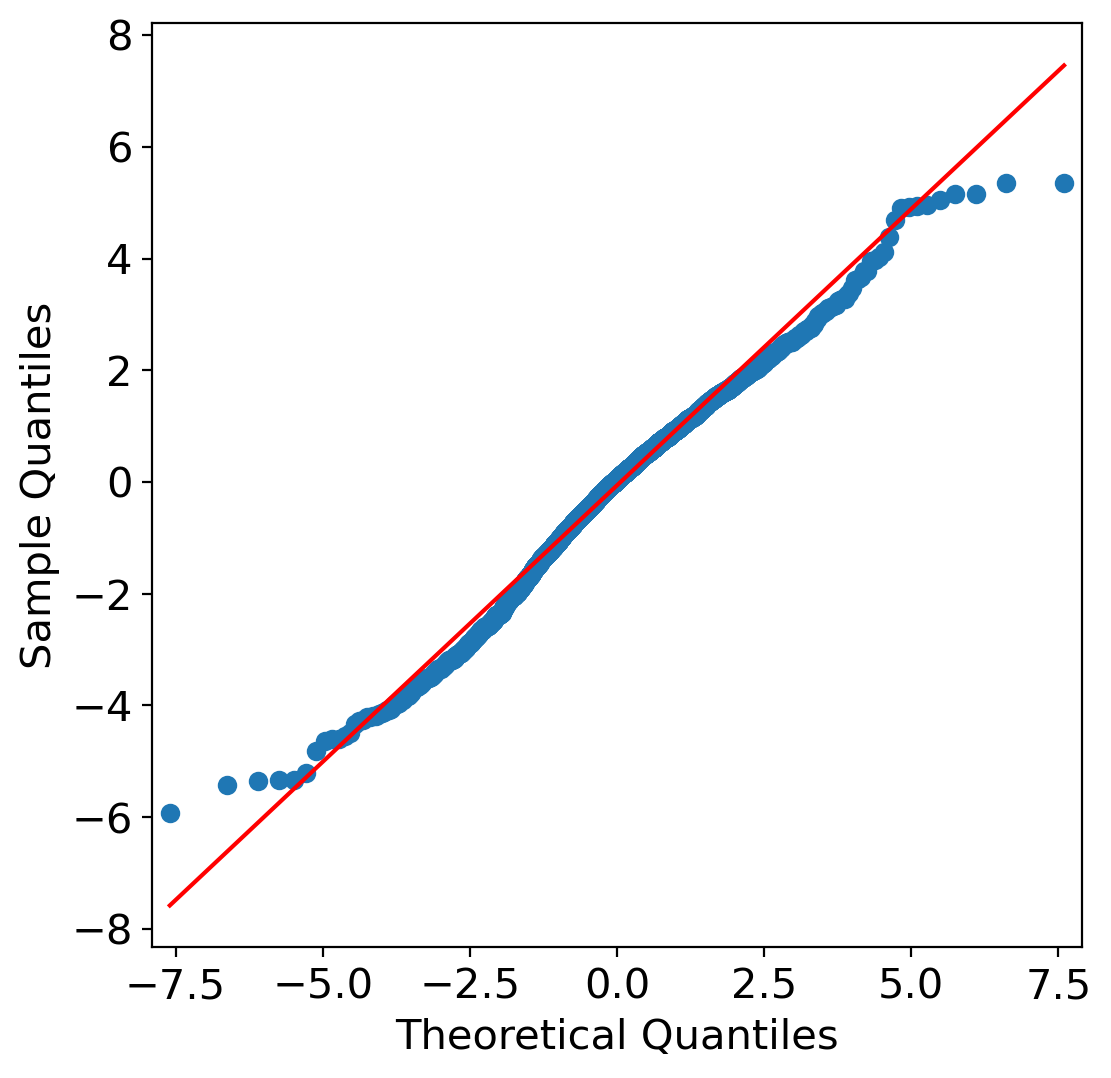

In [151]:
import statsmodels.api as sm
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (6, 6) 
fig = sm.qqplot(residual[~np.isnan(residual)], stats.t, fit=True, line="r")
plt.show()

(-500.0, 500.0)

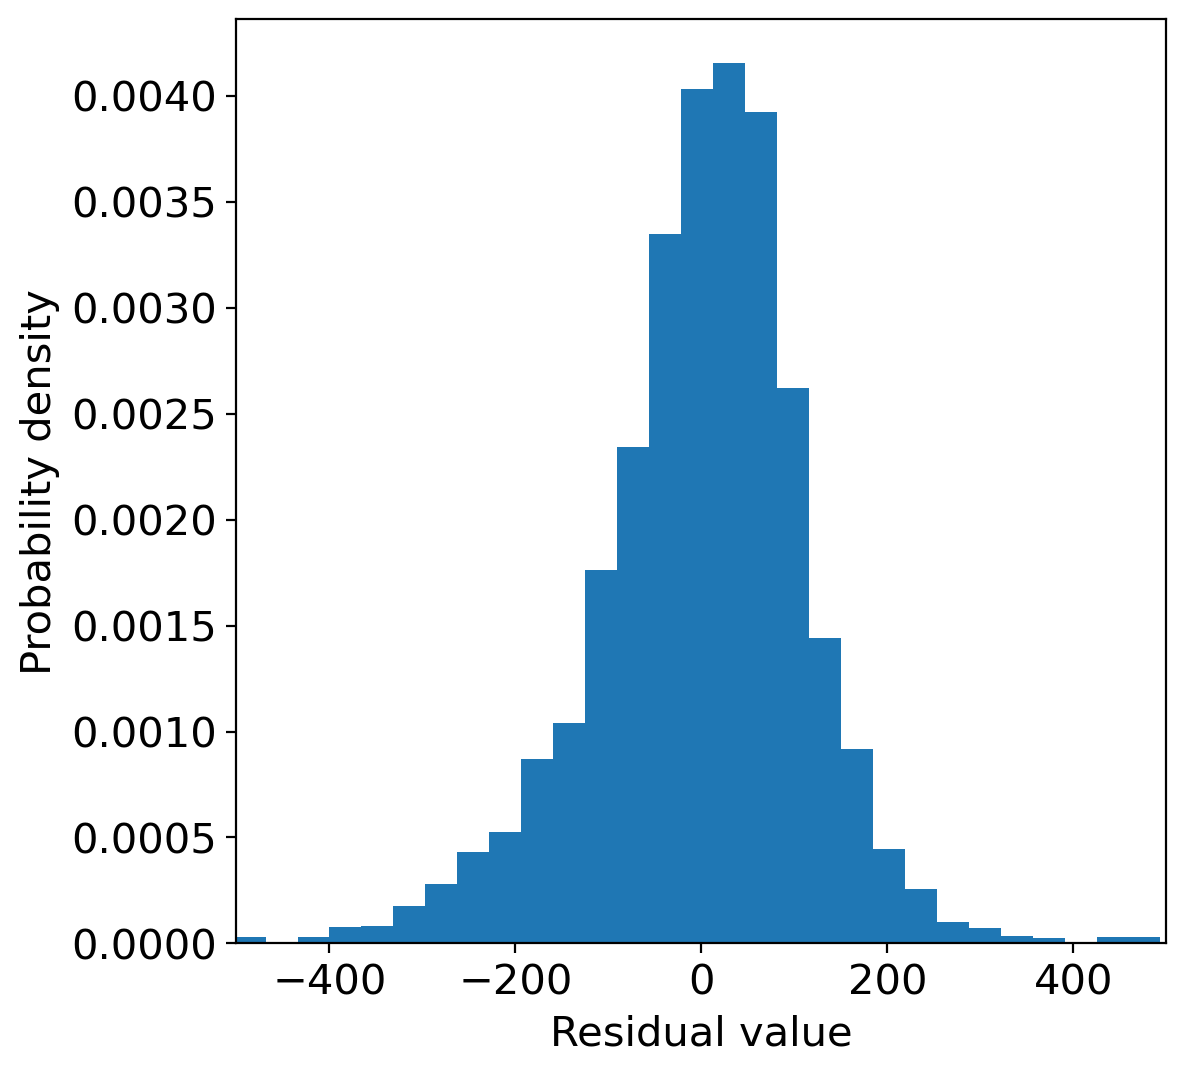

In [152]:
plt.hist(residual[~np.isnan(residual)],bins = 30,density = True)
plt.xlabel('Residual value')
plt.ylabel('Probability density')
plt.xlim(-500,500)

# Variogram calculation

In [153]:
residual_df = np.vstack([np.where(~np.isnan(residual))[1],np.where(~np.isnan(residual))[0],residual[~np.isnan(residual)],data[~np.isnan(residual)]]).T
residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])

In [154]:
# normal score transformation
residual_df['ns_residual'],  vr, wt_ns = geostats.nscore(residual_df,'residual')
residual_df['ns_data'],  _, _ = geostats.nscore(residual_df,'data')

Variogram without trend removal

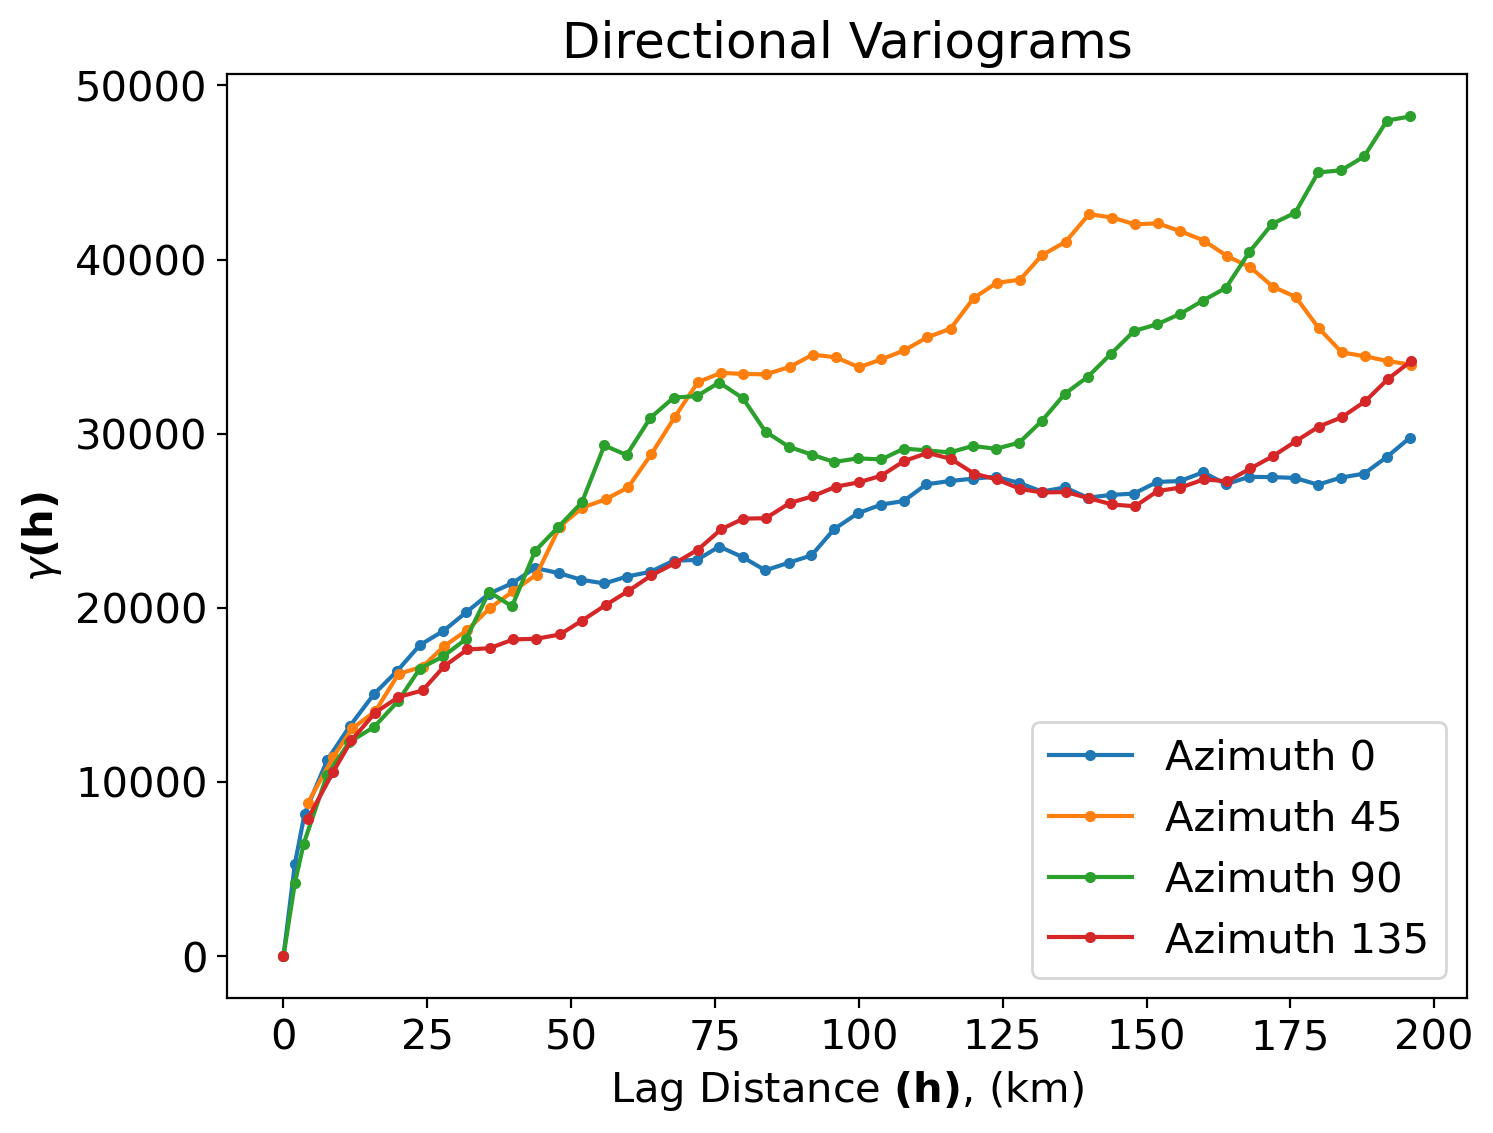

In [156]:
# compute anisotropic variogram

tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 2.0 # lag distance interval (in meters)
lag_tol = 1.0 # lag tolerance
nlag = 50 # number of lag distances to use
bandh = 100 # no effect for isotropic variogram

azi_mat = np.linspace(0,180,4,endpoint=False)             # directions in azimuth to consider
atol = 22.5 # 11.25 degree tolerance
isill = 0 # no effect for normal score transformed data

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    azi = azi_mat[iazi]
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(residual_df,'X','Y','data',
                                                            tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag[npp==0] = np.nan

plt.figure(figsize = [8,6])
# plot anistropic variograms
for i in range(len(azi_mat)):
    plt.plot(lag[i,::-1]*resolution[0]/1000,gamma[i,::-1],'.-',label = 'Azimuth '+str(int(azi_mat[i])))
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.legend(loc='lower right')

Variogram **with** trend removal

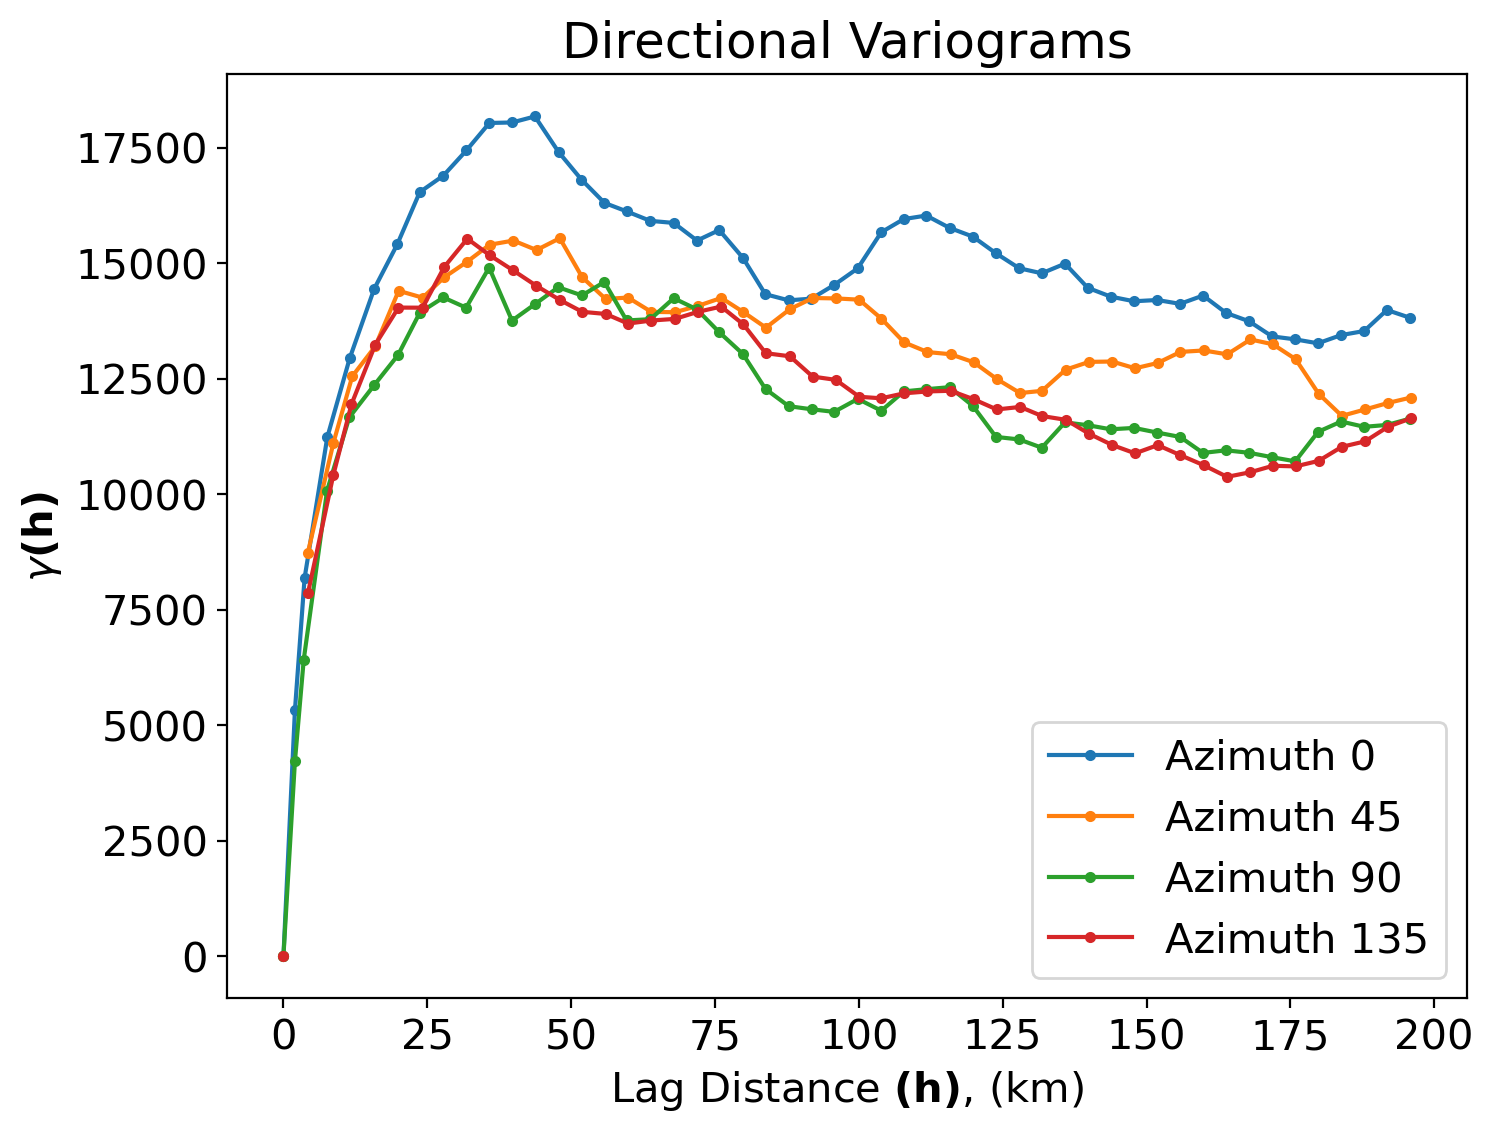

In [158]:
# compute anisotropic variogram
bandh = 100 # bandwidth tolerance
azi_mat = np.linspace(0,180,4,endpoint=False)           # directions in azimuth to consider
atol = 22.5 # 11.25 degree tolerance

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    azi = azi_mat[iazi]
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(residual_df,'X','Y','residual',
                                                            tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
lag[npp==0] = np.nan

# plot anistropic variograms
plt.figure(figsize = [8,6])
for i in range(len(azi_mat)):
    plt.plot(lag[i,::-1]*resolution[0]/1000,gamma[i,::-1],'.-',label = 'Azimuth '+str(int(azi_mat[i])))
plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.legend(loc='lower right')
#plt.xlim(-1,100)

# Sequential Gaussian simulation

In [159]:
num_x = num_of_grids[0]
num_y = num_of_grids[1]

# x, y range
x = range(num_x)
y = range(num_y)

xx,yy = np.meshgrid(x,y)
pred_grid_ = np.vstack([xx.reshape(-1),yy.reshape(-1)]).T

In [160]:
Azimuth = 0 # azimuthal direction of major axis
nug = 0 # nugget
nstruct = 1 # variogram structures
vtype = 2 # exponential type (1 = spherical, 2 = exponential, 3 = Gaussian)
cc = 1#np.var(residual_df['residual']) # contribution for each structure
a_max = 12.5 # major range for each structure
a_min = 12.5  # minor range for each structure

vario = [Azimuth, nug, a_max, a_min,cc] # save variogram parameters as a list

## Stochastic trend

In [184]:
interval = 49
simulations_num = 10 # int((iter_num-cut_off)/interval)

In [185]:
k = 25
sgs_stochastic = np.zeros((simulations_num,num_x*num_y))
print(simulations_num)
for i in range(simulations_num):
    residual = data-trend_cache[int(cut_off+i*interval),:,:] # using trend MCMC
    residual_df = np.vstack([np.where(~np.isnan(residual))[1],
                             np.where(~np.isnan(residual))[0],
                             residual[~np.isnan(residual)],
                             data[~np.isnan(residual)]]).T
    residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])
    sgs_stochastic[i,:] = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate

10


  0%|          | 0/22801 [00:00<?, ?it/s]

100%|██████████| 22801/22801 [00:52<00:00, 437.10it/s]


In [186]:
sgs_full = sgs_stochastic.reshape(simulations_num,num_x,num_y)+trend_cache[(cut_off+np.arange(simulations_num)*interval),:,:]

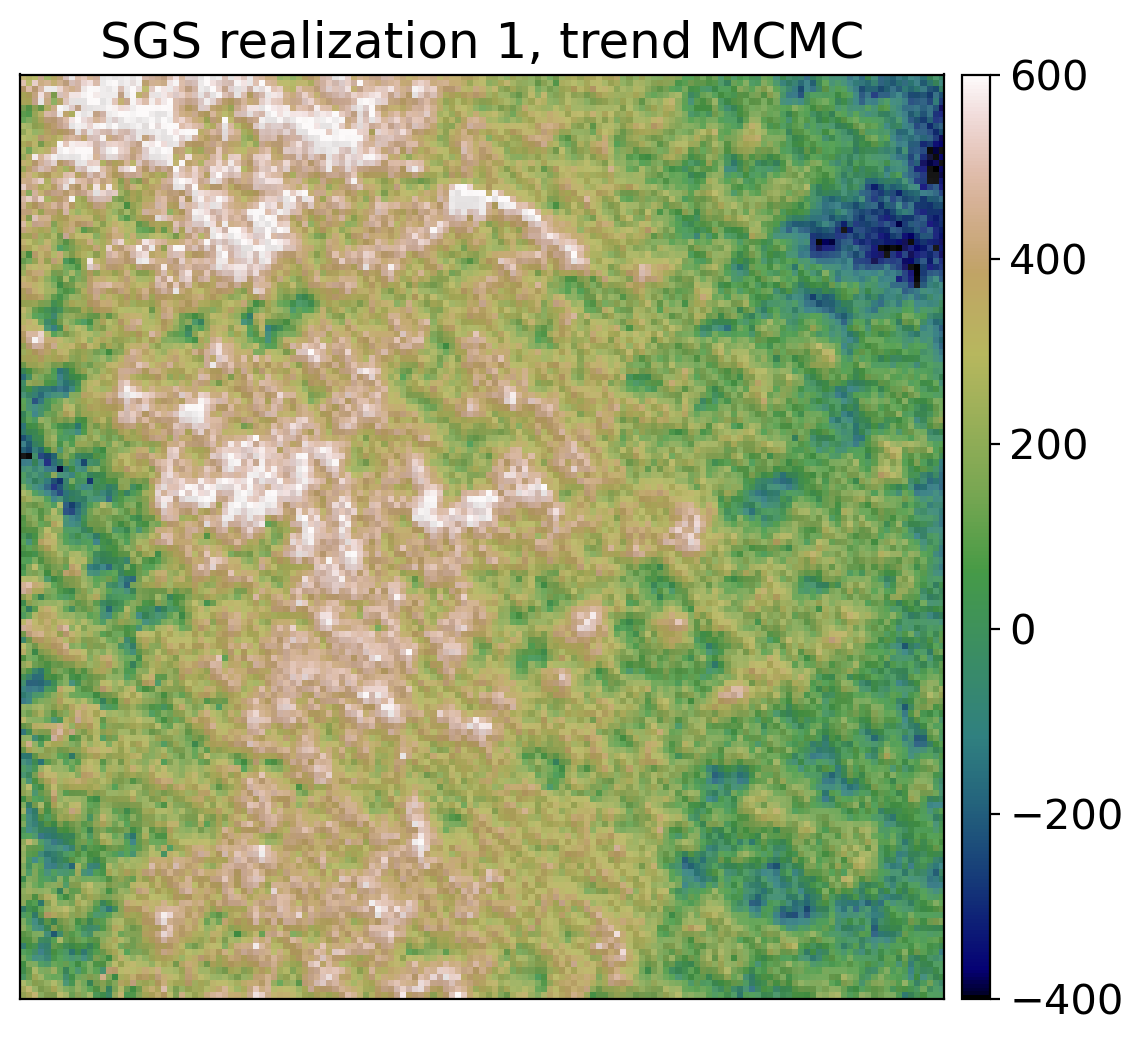

In [187]:
plot_image = sgs_full[0,:,:]
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS realization 1, trend MCMC",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

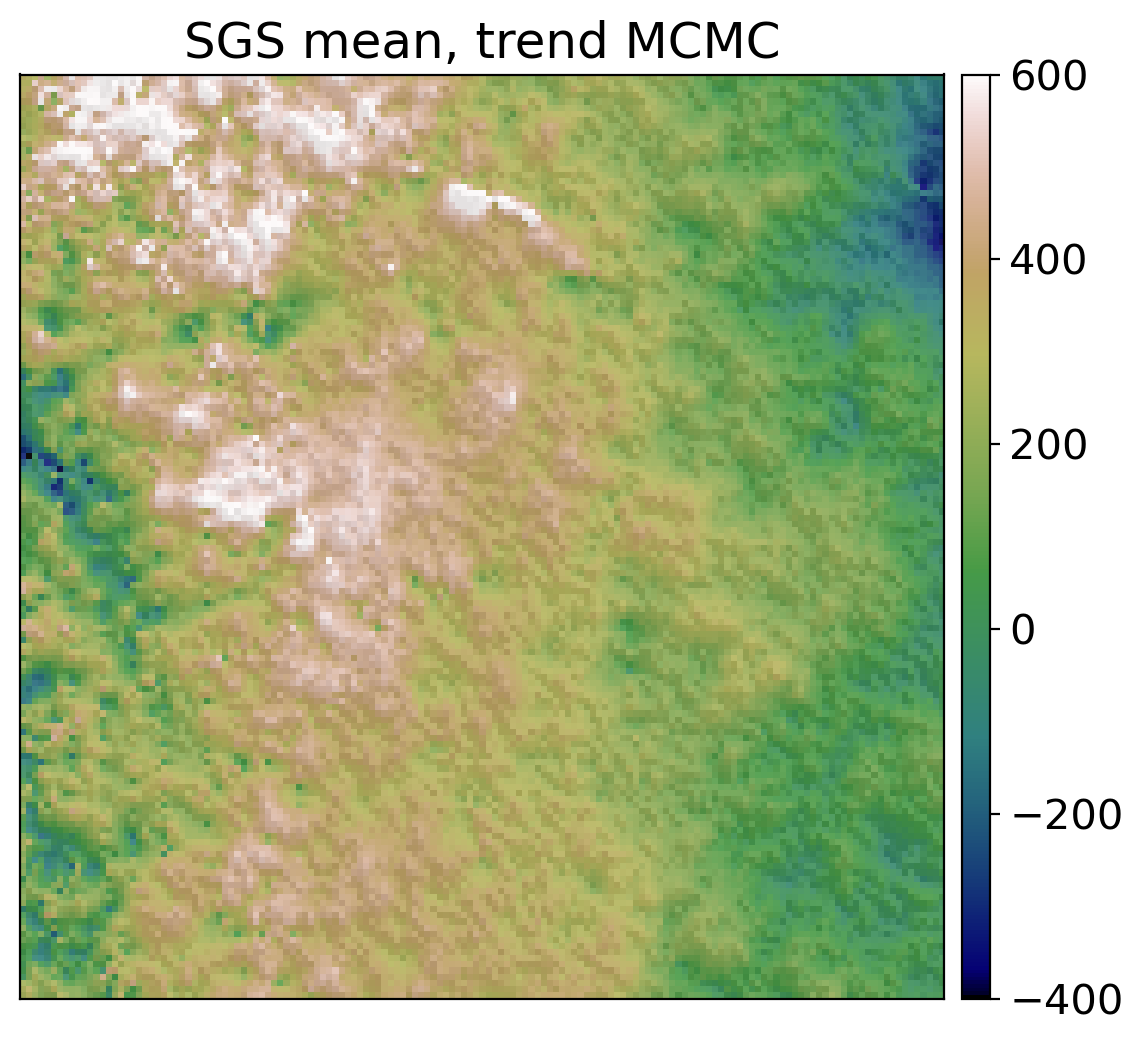

In [188]:
plot_image = np.mean(sgs_full,axis = 0)
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS mean, trend MCMC",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

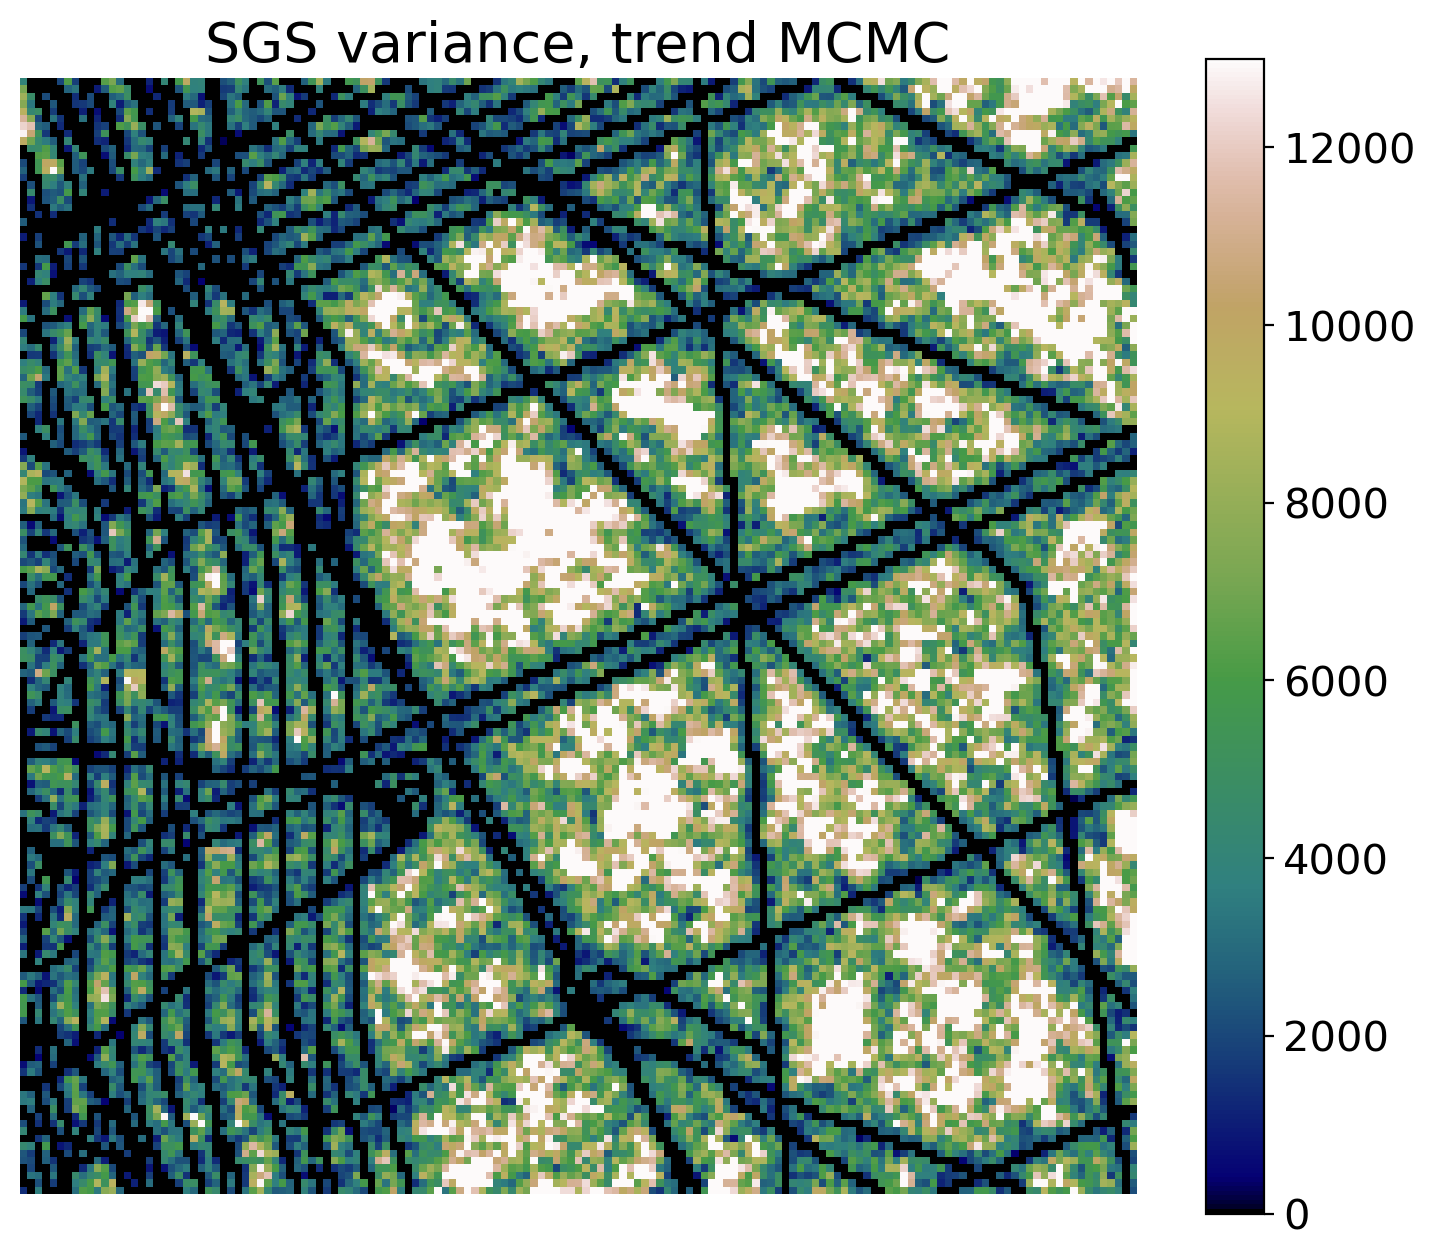

In [189]:
fig, ax = plt.subplots(figsize = (9,7.5)) 
plt.imshow(np.var(sgs_full,axis = 0).reshape(num_x,num_y),origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 13000)
plt.axis('off')
plt.title('SGS variance, trend MCMC',fontsize = 20) 
plt.colorbar()

## Deterministic trend

In [190]:
residual = data-trend_rbf
residual_df = np.vstack([np.where(~np.isnan(residual))[1],
                         np.where(~np.isnan(residual))[0],
                         residual[~np.isnan(residual)],
                         data[~np.isnan(residual)]]).T
residual_df = pd.DataFrame(residual_df,columns = ['X','Y','residual','data'])

In [191]:
# Kriging result
sgs_mean,sgs_var = skrige(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20)

100%|██████████| 22801/22801 [00:38<00:00, 586.61it/s]


In [192]:
# Simulation result
sgs_deterministic1 = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate
sgs_deterministic2 = skrige_SGS(pred_grid_, residual_df, 'X', 'Y', 'residual', k, vario, 20) # simulate

100%|██████████| 22801/22801 [00:52<00:00, 432.19it/s]


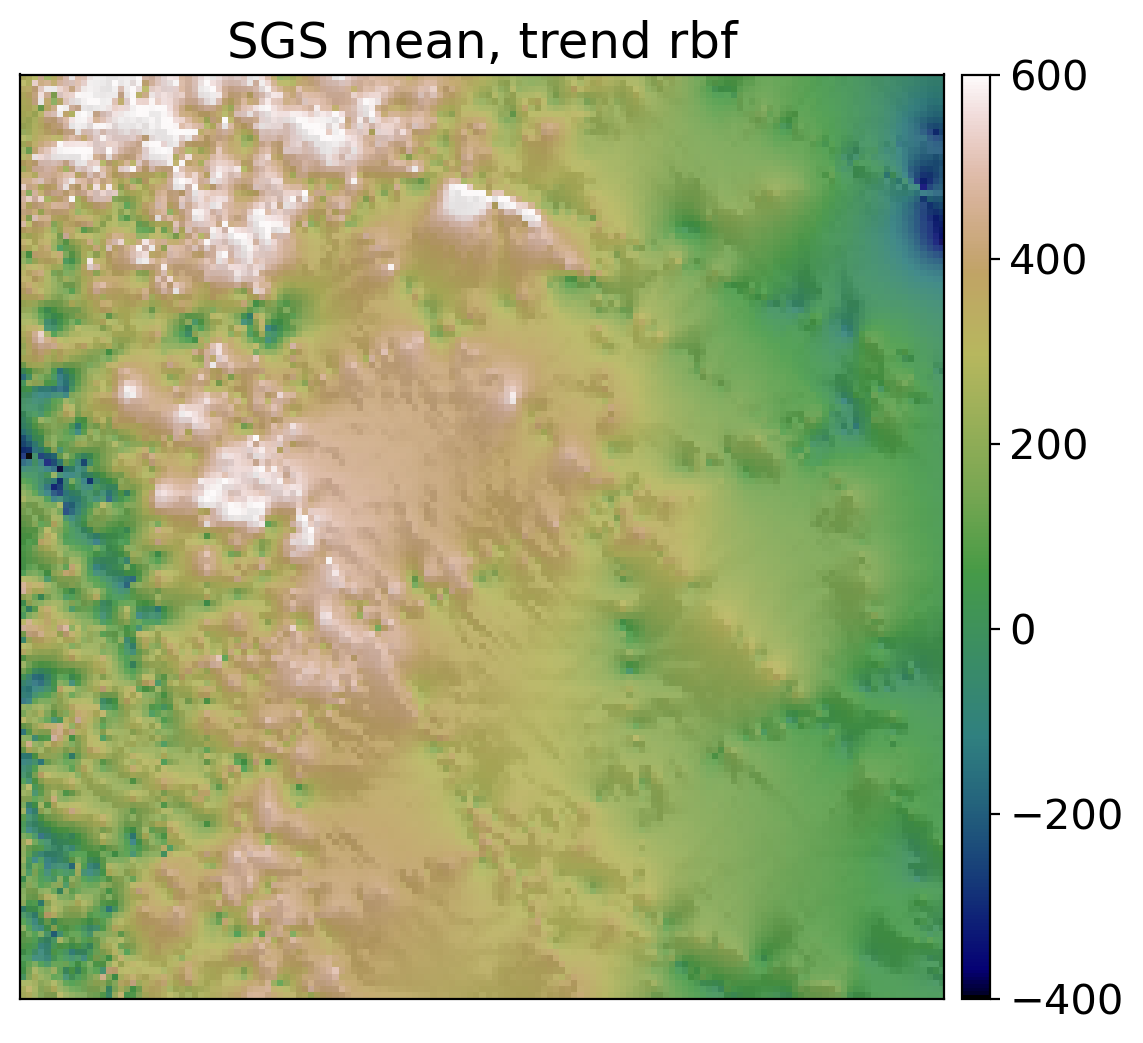

In [193]:
plot_image = sgs_mean.reshape(num_x,num_y)+trend_rbf
hillshade = es.hillshade(plot_image[::-1,:], azimuth = 210, altitude = 10) # hillshade

fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    plot_image[::-1,:],
    ax=ax,
    cmap="gist_earth",
    title="SGS mean, trend rbf",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

(-0.5, 150.5, -0.5, 150.5)

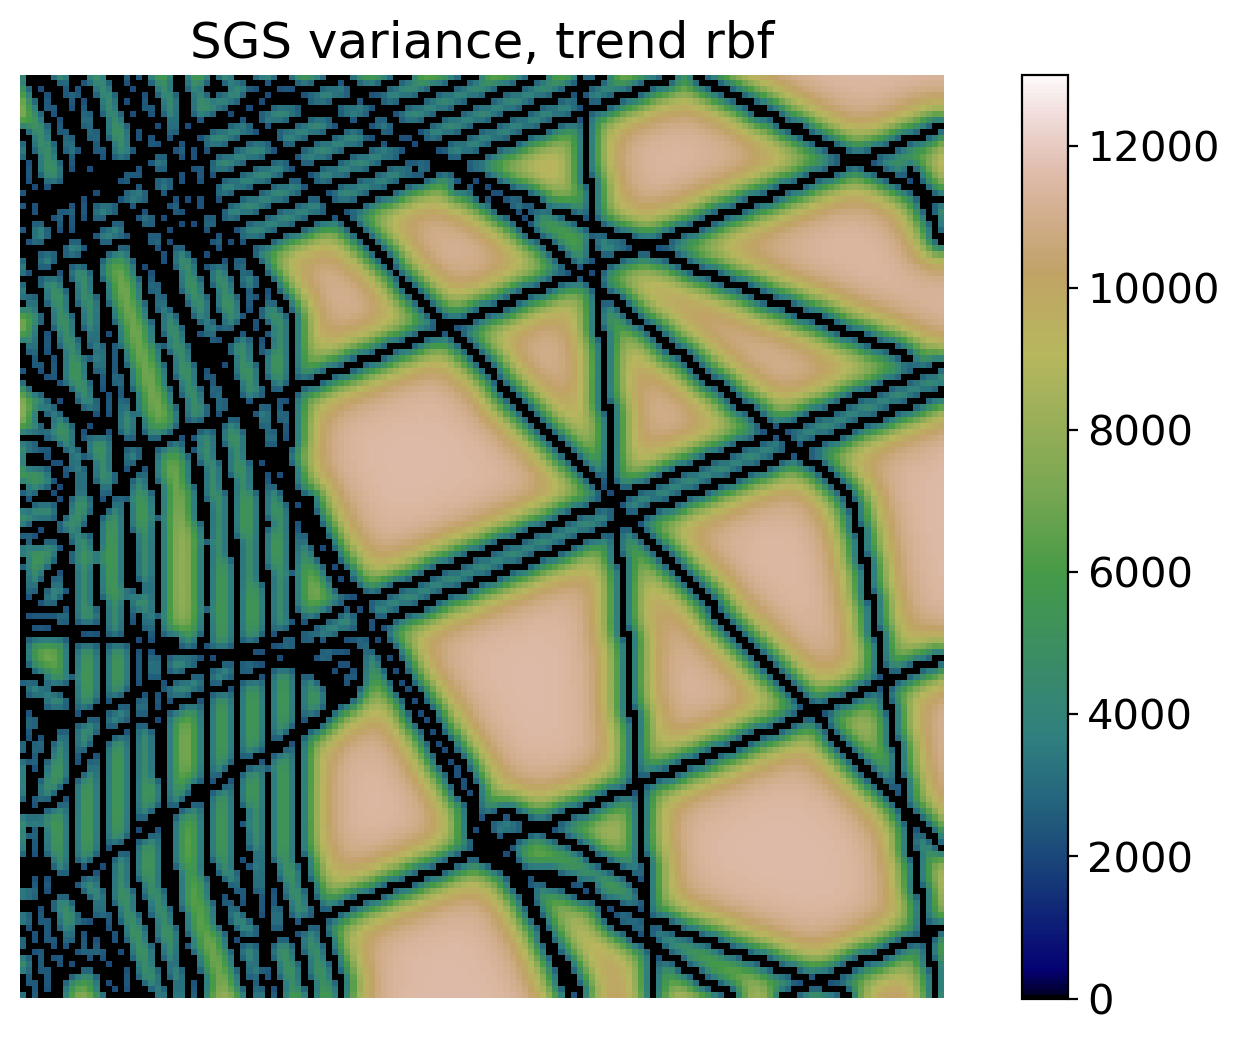

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.imshow(sgs_var.reshape(num_x,num_y),origin = 'lower',cmap = 'gist_earth',vmin = 0,vmax = 13000)
plt.colorbar()

plt.title('SGS variance, trend rbf')

plt.axis('off')